In [146]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import pickle as pk
#import pytz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from os import path
import sys
#from mmctools.plotting import TaylorDiagram
#from scipy.stats import pearsonr
import glob
#from mmctools.wrf.utils import tsout_seriesReader
#from mmctools.helper_functions import calc_wind,w_s,theta_to_T
from matplotlib.colors import Normalize
from string import ascii_lowercase
from matplotlib.legend_handler import HandlerBase
import matplotlib.gridspec as gridspec
import matplotlib
from scipy import stats
from matplotlib.ticker import MaxNLocator

In [150]:
#main_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/'
main_directory = '/glade/campaign/ral/wsap/hawbecker/MMC/NYSERDA/SENSITIVITY_SUITE/'

#obs_shift = '160min'
obs_shift = '0min'

#if obs_shift == '0min':
#    save_dir = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/production/img/'
#else:
#    save_dir = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/production/img/obs_shift/'
save_dir = '/glade/campaign/ral/wsap/hawbecker/MMC/NYSERDA/figures/d03/'

save_figs = True

icbc_type = 'MERRA2'  # ERAI, ERA5, FNL

from NYSERDA_case_dict import case_dict

cases = [case_dict[x]['case_str'] for x in list(case_dict.keys())]

# TESTING:
#cases = [cases[0]] + cases[3:6]# + [cases[-1]]
# SST Only:
cases = cases[:-1]

eta_level_testing = False
if eta_level_testing:
    main_directory += 'eta_level_test/'
    cases = cases[-3:]
    time_step = 5.0
else:
    cases = cases[:]
    failed_cases = []
    for case in failed_cases:
        cases.remove(case)
    time_step = 6.0

sim_start = '2020-04-04 06:00:00'
#case_start = '2020-04-05 16:00:00'
#case_end   = '2020-04-06 06:00:00'
case_start = '2020-04-06 02:00:00'
case_end   = '2020-04-06 06:00:00'

best_case  = 'WPS3_WRF1'
n_profiles = 8


# Colors for spread (red) and EME (blue)
meso_spread = 'lightcoral'
les_spread = 'darkred'
meso_eme = 'skyblue'
les_eme = 'royalblue'

dom_dict = {1: {'dt':15,
                #'color':'violet',
                'color':'lightcoral',
                #'marker': r'$ 1 $',
                'marker': 'o',
                'ls':'-'},
            2: {'dt':5,
                #'color':'deeppink',
                'color':'darkred',
                #'marker': r'$ 2 $',
                'marker': 'd',
                'ls':'--'},
            3: {'dt':1,
                'color':'goldenrod',
                #'marker': r'$ 3 $',
                'marker': '^',
                'ls':'-'},
            4: {'dt':0.2,
                #'color':'turquoise',
                'color':'skyblue',
                #'marker': r'$ 4 $',
                'marker': 's',
                'ls':'-.'},
            5: {'dt':0.04,
                #color':'steelblue',
                'color':'royalblue',
                #'marker': r'$ 5 $',
                'marker': '*',
                'ls':':'},
            }
#doms_of_interest = [1,2,3,4,5]
doms_of_interest = [1,2,3,4,5]

#for cc,case in enumerate(cases):
#    plt.plot(np.arange(0,10),np.arange(0,10)*cc,c=case_dict[case]['color'])

twr_lat = [ 39.969278,  39.546772]
twr_lon = [-72.716692, -73.428892]
twr_names = ['E05','E06']
twr_abbreviation = ['E05','E06']

uniform_wspd_min = 6.0
uniform_wspd_max = 19.0


variable_dict = {'low_shear':{'title':'Low-Level Shear','units':'s$^{-1}$'},
                 'hub_wspd':{'title':'Hub-Height Wind Speed','units':'m s$^{-1}$'},
                 'llj_height':{'title':'LLJ Nose Height','units':'m'},
                 'max_wspd':{'title':'Max Windspeed','units':'m s$^{-1}$'},
                 'delT':{'title':'$\Delta$T','units':'K'},
                 't2':{'title':'2 m Temperature','units':'K'},
                 'tsk':{'title':'SST','units':'K'},
                 'rews':{'title':'REWS','units':'m s$^{-1}$'},
                }

hub_height = 118.0 # 98.0 or 118.0
rotor_D = 160.0

In [4]:
marker_dict = {}
use_letters = False
markers = ['o','*','^','s','p','P','X','d','v']
for cc,case in enumerate(list(case_dict.keys())):
    if use_letters:
        m = case_dict[case]['case_name'][0]
        if '${}$'.format(m) in marker_dict.values():
            for i in case_dict[case]['case_name'][1:]:
                if '${}$'.format(i) not in marker_dict.values():
                    m = i
        marker = '${}$'.format(m)
    else:
        marker = markers[cc]
    marker_dict[case] = marker


# Get Obs:

/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/1317640353.py:18: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  lr_nyserda_obs = lr_nyserda_obs.sel(case='obs',Tlevels=2).drop('Tlevels')
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/1317640353.py:22: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  nyserda_obs = nyserda_obs.drop('T')
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/1317640353.py:23: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  nyserda_obs = nyserda_obs.squeeze().drop('Tlevels')


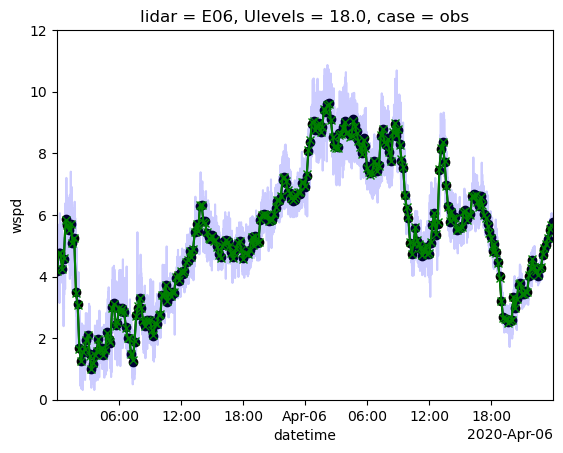

In [6]:
#obs_dir = '/glade/work/hawbecke/MMC/NYSERDA/obs/'
obs_dir = '/glade/campaign/ral/wsap/branko/MMC/NYSERDA/obs/'
obs_res = 'high' # 'low' or 'high'
#atlshrs_full = xr.open_dataset('{}ATLSHORES_lidars.nc'.format(obs_dir))
#atlshrs_obs = atlshrs_full.sel(case='obs').squeeze(dim='Tlevels')
#atlshrs_obs.T.data += 273.15
#atlshrs_obs.sst.data += 273.15

if obs_res == 'low':
    nyserda_full = xr.open_dataset('{}NYSERDA_lidars.nc'.format(obs_dir))
    nyserda_obs = nyserda_full.sel(case='obs')
    
    #best_case = 'WPS3_WRF1'
    #nyserda_opt = nyserda_full.sel(case=best_case)
    hr_nyserda_obs = xr.open_dataset('{}HR_NYSERDA_lidars.nc'.format(obs_dir))
else:
    lr_nyserda_obs = xr.open_dataset('{}NYSERDA_lidars.nc'.format(obs_dir))
    lr_nyserda_obs = lr_nyserda_obs.sel(case='obs',Tlevels=2).drop('Tlevels')

    nyserda_obs = xr.open_dataset('{}HR_NYSERDA_lidars.nc'.format(obs_dir))

    nyserda_obs = nyserda_obs.drop('T')
    nyserda_obs = nyserda_obs.squeeze().drop('Tlevels')

    sst = lr_nyserda_obs.sst.sel(datetime=slice(nyserda_obs.datetime[0],nyserda_obs.datetime[-1]))
    nyserda_obs = xr.merge([nyserda_obs,sst])
    t2 = lr_nyserda_obs.T.sel(datetime=slice(nyserda_obs.datetime[0],nyserda_obs.datetime[-1])).squeeze()
    nyserda_obs = xr.merge([nyserda_obs,t2])

    lr_nyserda_obs.wspd.sel(Ulevels=20,lidar='E06').plot(c='k',marker='o')
    nyserda_obs.wspd.sel(Ulevels=18,lidar='E06').dropna(how='any',dim='datetime').plot(c='b',alpha=0.2)
    nyserda_obs.wspd.sel(Ulevels=18,lidar='E06').resample({'datetime':'10min'}).mean().plot(c='g',marker='x')
    plt.xlim(pd.to_datetime(nyserda_obs.datetime.data[0]),pd.to_datetime(nyserda_obs.datetime.data[-1]))
    plt.ylim(0,12)

18.0 162.64627014925372
38.0 163.90981363636362
58.0 165.6895727411945
78.0 167.8628054474708
98.0 170.71557799547853
118.0 173.79569346356124
138.0 175.75589385898405
158.0 176.34226291793314
178.0 176.49741527987896
198.0 176.93104285714287


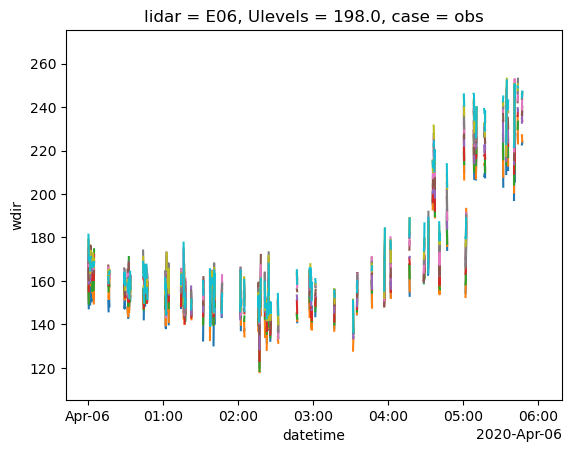

In [7]:
for lvl in nyserda_obs.Ulevels:
    data = nyserda_obs.wdir.sel(lidar='E06',Ulevels=lvl).sel(datetime=slice('2020-04-06 00:00','2020-04-06 06:00'))
    print(lvl.data,float(data.mean()))
    data.plot()
#plt.xlim(pd.to_datetime(nyserda_obs.datetime.data[0]),pd.to_datetime(nyserda_obs.datetime.data[-1]))


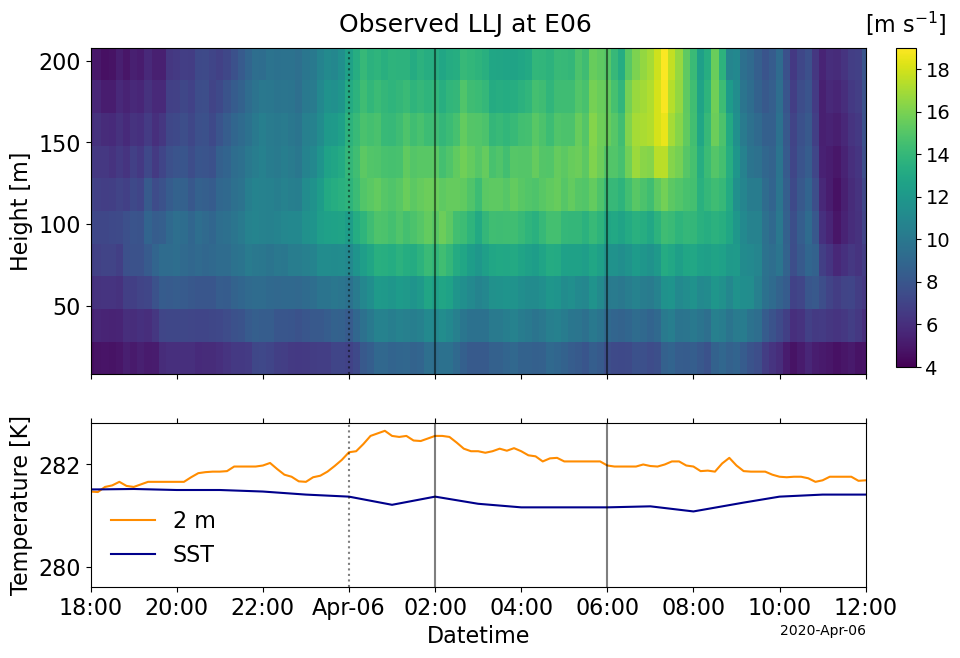

In [8]:
add_profiles = False

fig,ax = plt.subplots(nrows=2,figsize=(10,7),sharex=True,gridspec_kw={'height_ratios': [2, 1]})

resampled_obs = nyserda_obs.resample({'datetime':'10min'}).mean()

plt_levels = resampled_obs.Ulevels.data

plt_levels = 0.5*(plt_levels[1:] + plt_levels[:-1])

plt_times = list(resampled_obs.datetime.data - pd.to_timedelta('5min'))
plt_times += [plt_times[-1]+pd.to_timedelta('5min')]
plt_times = np.asarray(plt_times)

dz = np.mean(plt_levels[1:] - plt_levels[:-1])

plt_levels = [plt_levels[0] - dz] + list(plt_levels) + [plt_levels[-1] + dz]

wspd_plt = ax[0].pcolormesh(plt_times,
                            plt_levels,
                            resampled_obs.wspd.T.sel(lidar='E06'),
                            rasterized=True,
                            vmin=4.0,
                            vmax=19.0)

resampled_obs.sel(lidar='E06').T.dropna(how='any',dim='datetime').plot(ax=ax[1],c='darkorange',label='2 m')
resampled_obs.sel(lidar='E06').sst.dropna(how='any',dim='datetime').plot(ax=ax[1],c='darkblue',label='SST')

for axi in range(0,2):
    ax[axi].set_xlim(pd.to_datetime('2020-04-05 18:00'),pd.to_datetime('2020-04-06 12:00'))
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_title('')
    ax[axi].axvline(pd.to_datetime('2020-04-06 00:00'),c='k',ls=':',alpha=0.5)
    ax[axi].axvline(pd.to_datetime(case_start),c='k',ls='-',alpha=0.5)
    ax[axi].axvline(pd.to_datetime(case_end),c='k',ls='-',alpha=0.5)
    
ax[1].tick_params(top=True)
ax[0].set_ylabel('Height [m]',size=16)
ax[1].set_ylabel('Temperature [K]',size=16)

cax  = fig.add_axes([0.93,0.424,0.02,0.456])
cbar = plt.colorbar(wspd_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m s$^{-1}$]',size=16,y=1.02)

if add_profiles:
    plt.draw()
    xticks = ax[1].get_xticklabels()
    xtick_times = []
    for tt,ticktime in enumerate(xticks):
        ttime = '2020-{}:00:00'.format(ticktime.get_text())
        print(ticktime.get_text())
        xtick_times += [pd.to_datetime(ttime)]

    wspd_profiles = nyserda_obs.wspd.sel(lidar='E06').dropna(how='all',dim='datetime').sel(datetime=xtick_times,method='nearest')

    wax = ax[0].twiny()
    wspd_profiles -= wspd_profiles.isel(Ulevels=0)
    wspd_profiles /= 10
    wspd_profiles = wspd_profiles + np.arange(0,len(xtick_times))
    for dtime in wspd_profiles.datetime[:-1]:
        wspd_profiles.sel(datetime=dtime).dropna(how='any',dim='Ulevels').plot(y='Ulevels',ax=wax,c='lightblue')

    for vline in range(0,10):
        wax.axvline(vline,c='k',alpha=0.5,ls=':')
    wax.set_xlim(0,9)
    wax.tick_params(labeltop=False,top=False)
    wax.set_title('')
ax[0].set_xlabel('')
ax[1].set_xlabel('Datetime',size=16)
ax[1].legend(frameon=False,fontsize=16)
plt.suptitle('Observed LLJ at E06',size=18,y=0.93)

if obs_shift != '0min':
    for axi in range(0,2):
        ax[axi].axvline(pd.to_datetime('2020-04-06 00:00')+pd.Timedelta(obs_shift),c='r',ls=':',alpha=0.5,lw=2.0)
        ax[axi].axvline(pd.to_datetime(case_start)+pd.Timedelta(obs_shift),c='r',ls='-',alpha=0.5,lw=2.0)
        ax[axi].axvline(pd.to_datetime(case_end)+pd.Timedelta(obs_shift),c='r',ls='-',alpha=0.5,lw=2.0)
fig_name = '{}E06Obs_10min'.format(save_dir)
if add_profiles:
    fig_name += '_withProfiles'
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

# Domains:

In [9]:
wrfin_list = sorted(glob.glob('{}{}/wrfin*'.format(main_directory,cases[0])))
wrfin_dict = {}
for ff,wrfin_f in enumerate(wrfin_list):
    wrfin_dict['d0{}'.format(ff+1)] = xr.open_dataset(wrfin_f).squeeze()
    

In [10]:
def labelAtEdge(levels, cs, ax, fmt, side='both', pad=0.005, **kwargs):
    '''Label contour lines at the edge of plot
    Args:
        levels (1d array): contour levels.
        cs (QuadContourSet obj): the return value of contour() function.
        ax (Axes obj): matplotlib axis.
        fmt (str): formating string to format the label texts. E.g. '%.2f' for
            floating point values with 2 demical places.
    Keyword Args:
        side (str): on which side of the plot intersections of contour lines
            and plot boundary are checked. Could be: 'left', 'right', 'top',
            'bottom' or 'all'. E.g. 'left' means only intersections of contour
            lines and left plot boundary will be labeled. 'all' means all 4
            edges.
        pad (float): padding to add between plot edge and label text.
        **kwargs: additional keyword arguments to control texts. E.g. fontsize,
            color.
    '''
    from matplotlib.transforms import Bbox
    collections = cs.collections
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    bbox = Bbox.from_bounds(xlim[0], ylim[0], xlim[1]-xlim[0], ylim[1]-ylim[0])
    eps = 1e-5  # error for checking boundary intersection
    # -----------Loop through contour levels-----------
    for ii, lii in enumerate(levels):
        cii = collections[ii]  # contours for level lii
        pathsii = cii.get_paths()  # the Paths for these contours
        if len(pathsii) == 0:
            continue
        for pjj in pathsii:
            # check first whether the contour intersects the axis boundary
            if not pjj.intersects_bbox(bbox, False):  # False significant here
                continue
            xjj = pjj.vertices[:, 0]
            yjj = pjj.vertices[:, 1]
            # intersection with the left edge
            if side in ['left', 'all']:
                inter_idx = np.where(abs(xjj-xlim[0]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x-pad, inter_y, fmt % lii,
                            ha='right',
                            va='center',
                            **kwargs)
            # intersection with the right edge
            if side in ['right', 'all']:
                inter_idx = np.where(abs(xjj-xlim[1]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x+pad, inter_y, fmt % lii,
                            ha='left',
                            va='center',
                            **kwargs)
            # intersection with the bottom edge
            if side in ['bottom', 'all']:
                inter_idx = np.where(abs(yjj-ylim[0]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x, inter_y-pad, fmt % lii,
                            ha='center',
                            va='top',
                            **kwargs)
            # intersection with the top edge
            if side in ['top', 'all']:
                inter_idx = np.where(abs(yjj-ylim[-1]) <= eps)[0]
                for kk in inter_idx:
                    inter_x = xjj[kk]
                    inter_y = yjj[kk]
                    ax.text(inter_x, inter_y+pad, fmt % lii,
                            ha='center',
                            va='bottom',
                            **kwargs)
    return

def domain_plot(axi,domain_s,domain_e,number_lat_ticks=6,number_lon_ticks=6):
    pgr = 1
    i_s,j_s = 0,0
    for dom in range(domain_s,+domain_e+1):
        wrf_lat = wrfin_dict['d0{}'.format(dom)].XLAT
        wrf_lon = wrfin_dict['d0{}'.format(dom)].XLONG
        wrf_hgt = wrfin_dict['d0{}'.format(dom)].HGT
        wrf_sst = wrfin_dict['d0{}'.format(dom)].SST
        wrf_landmask = wrfin_dict['d0{}'.format(dom)].LANDMASK

        if dom == domain_s:
            min_lat = float(np.round(wrf_lat.min()))
            max_lat = float(wrf_lat.max())
            lat_span = max_lat - min_lat
            
            min_lon = float(np.round(wrf_lon.min()))
            max_lon = float(wrf_lon.max())
            lon_span = max_lon - min_lon
            
            if (lon_span < 10.0) or (lat_span < 10.0):
                num_dec = 1
            else:
                num_dec = 0
                
            lat_int = np.round(lat_span / number_lat_ticks, decimals=num_dec)
            lon_int = np.round(lon_span / number_lon_ticks,decimals=num_dec)

            #plt.contourf(wrf_hgt.where(wrf_landmask==1.0),cmap=plt.cm.terrain,alpha=0.25)
            #plt.contourf(wrf_sst.where(wrf_landmask==0.0),cmap=plt.cm.viridis,alpha=0.5,linewidths=None)
            axi.contourf(wrf_landmask,colors='lightgreen',levels=[0.5,1.0],alpha=0.5)
            axi.contourf(wrf_landmask,colors='lightskyblue',levels=[0.0,0.5],alpha=0.5)
            axi.contour(wrf_landmask,colors='grey',levels=[0.5],alpha=0.5)
            axi.set_ylim(wrf_landmask.south_north[0], wrf_landmask.south_north[-1])
            lat_cs = axi.contour(wrf_lat,levels=np.arange(min_lat,max_lat,lat_int),
                                 colors='k',alpha=0.25)

            lon_cs = axi.contour(wrf_lon,levels=np.arange(min_lon,max_lon,lon_int),
                                 colors='k',alpha=0.25,linestyles='solid')
            lat_levels = lat_cs.levels
            lon_levels = lon_cs.levels

            axi.tick_params(left=False,bottom=False,labelsize=0)
            labelAtEdge(lat_levels, lat_cs, axi, r'%.1f', side='left', pad=2,size=16)
            labelAtEdge(lon_levels, lon_cs, axi, r'%.1f', side='bottom', pad=5,size=16)
            axi.set_ylabel('Latitude',size=18,labelpad=40)
            axi.set_xlabel('Longitude',size=18,labelpad=20)
            axi.set_aspect('equal')

        else:
            i_s += wrfin_dict['d0{}'.format(dom)].I_PARENT_START/pgr
            j_s += wrfin_dict['d0{}'.format(dom)].I_PARENT_START/pgr
            pgr *= wrfin_dict['d0{}'.format(dom)].PARENT_GRID_RATIO

            n_x = len(wrfin_dict['d0{}'.format(dom)].west_east)/pgr
            n_y = len(wrfin_dict['d0{}'.format(dom)].south_north)/pgr

            dom_x = [i_s,i_s+n_x,i_s+n_x,i_s,i_s]
            dom_y = [j_s,j_s,j_s+n_y,j_s+n_y,j_s]
            axi.plot(dom_x,dom_y,c='k')
            axi.text((2*i_s+n_x)*0.5,j_s+n_y+5,'d0{}'.format(dom),size=18,ha='center')



/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3445222741.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  collections = cs.collections
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3445222741.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  collections = cs.collections


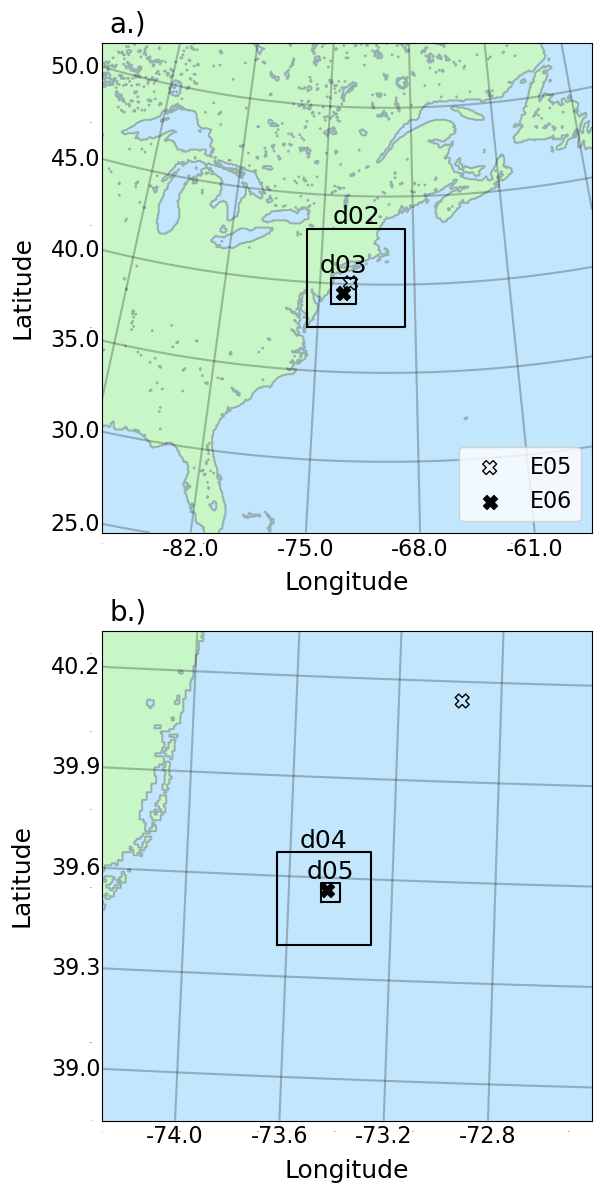

/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3445222741.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  collections = cs.collections
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3445222741.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  collections = cs.collections


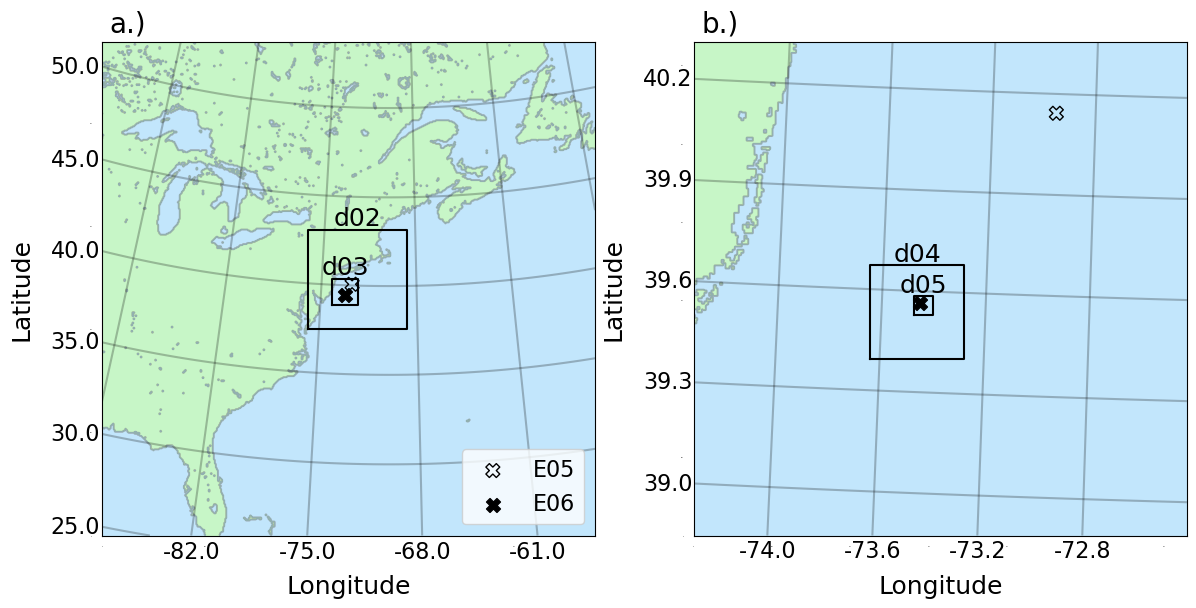

In [11]:
for fig_type in ['vert','horz']:

    if fig_type == 'vert':
        nrows = 2
        ncols = 1
        figsize = (7,14)
    else:
        nrows = 1
        ncols = 2
        figsize = (14,7)

        
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    domain_plot(ax[0],1,3)
    domain_plot(ax[1],3,5,number_lat_ticks=5,number_lon_ticks=4)
    ax[0].text(0.015,1.01,'a.)',size=20,transform=ax[0].transAxes,ha='left',va='bottom')#,bbox={'fc':'w','ec':'none'})
    ax[1].text(0.015,1.01,'b.)',size=20,transform=ax[1].transAxes,ha='left',va='bottom')#,bbox={'fc':'w','ec':'none'})

    twr_colors = ['none','k']
    twr_markers = ['X','X']

    for axi in range(0,2):
        for tt,twr in enumerate(twr_abbreviation):
            dom_lat = wrfin_dict['d0{}'.format(axi*2 + 1)].XLAT
            dom_lon = wrfin_dict['d0{}'.format(axi*2 + 1)].XLONG
            dist = ((twr_lat[tt]-dom_lat)**2 + (twr_lon[tt]-dom_lon)**2)**0.5

            min_dist = np.nanmin(dist)
            if min_dist < 0.1:
                twrj,twri = np.where(dist==np.nanmin(dist))
                ax[axi].scatter(twrj+0.5,twri+0.5,c=twr_colors[tt],
                                marker=twr_markers[tt],s=100,ec='k',
                                label=twr)

    ax[0].legend(loc=4,fontsize=16)
    fig_name = '{}Domains_{}'.format(save_dir,fig_type)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()


# Show SST Products:

In [12]:
#met_dir = '/glade/work/hawbecke/MMC/NYSERDA/met_em/MERRA2/'
met_dir = '/glade/campaign/ral/wsap/branko/MMC/NYSERDA/met_em/MERRA2/'
sst_datasets = ['orig','NAVO','CMC','OSPO','OSTIA','GOES16','MUR']

plt_order = sst_datasets.copy()

case_plot_order = []
for sst in plt_order:
    for case in cases:
        if sst == case_dict[case]['sst']: case_plot_order += [case]

In [13]:
wps_version = 'v3.9.1'
toi = '2020-04-05_00:00:00'
sst_data = {}
for ss,sst in enumerate(sst_datasets):
    if sst == 'orig':
        met_f = '{}{}/met_em.d02.{}.nc'.format(met_dir,sst,toi)
    else:
        met_f = '{}{}/{}/smooth-filled/met_em.d02.{}.nc'.format(met_dir,sst,wps_version,toi)
        
    met_ds = xr.open_dataset(met_f).squeeze()
    if ss == 0:
        wrf_lon = met_ds.XLONG_M
        wrf_lat = met_ds.XLAT_M
        wrf_landmask = met_ds.LANDMASK
    sst_data[sst] = met_ds.SKINTEMP.where(wrf_landmask == 0.0)


/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/4213382416.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sst_plt = sst_ax.pcolormesh(wrf_lon,wrf_lat,sst_data[sst],


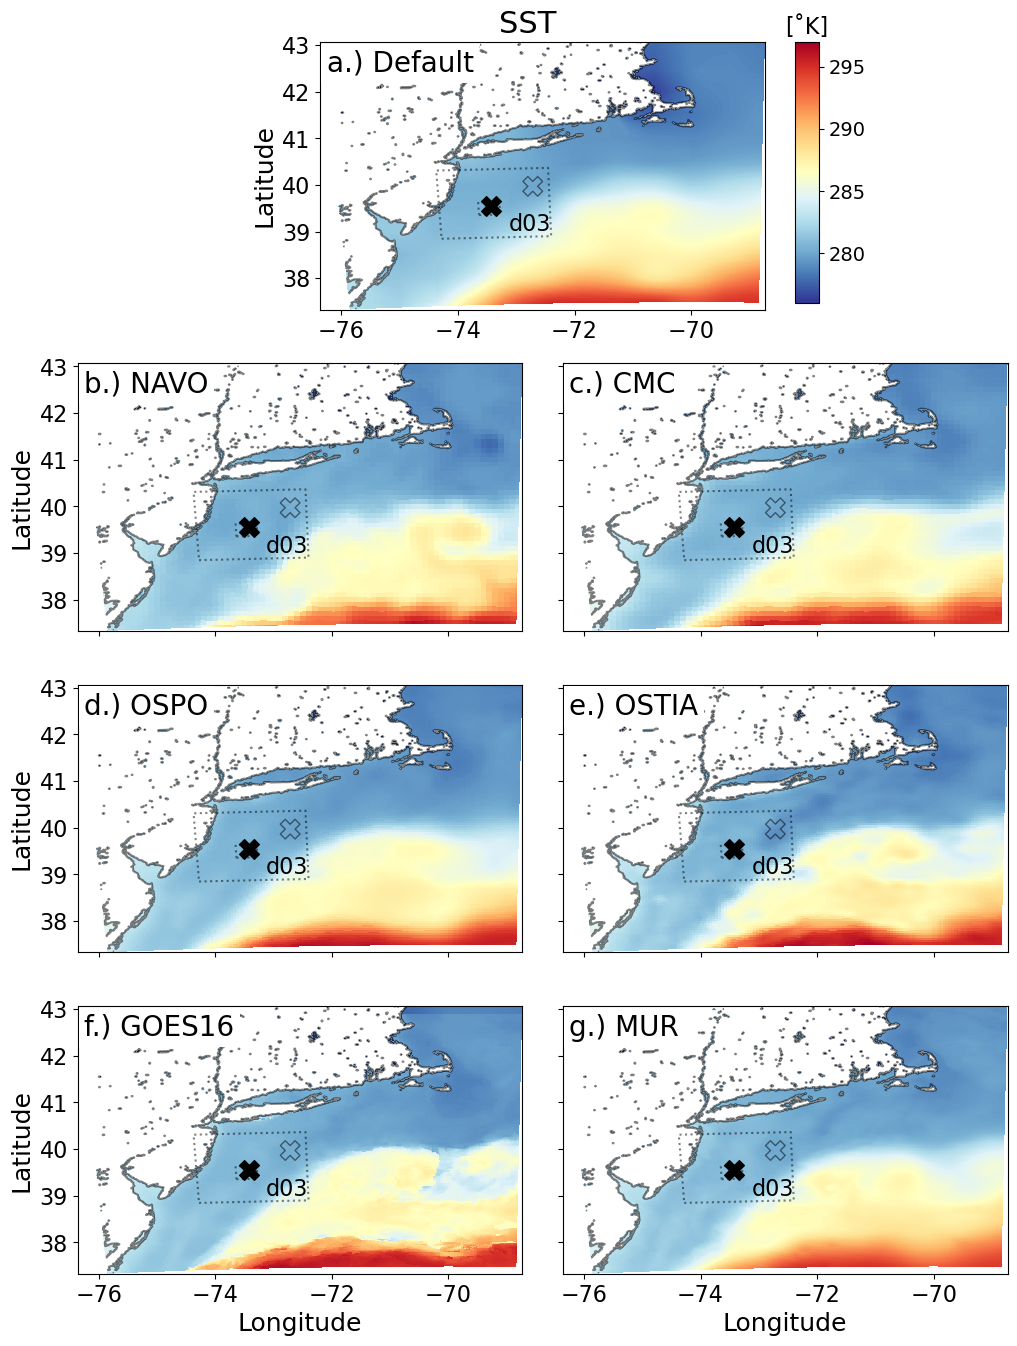

In [14]:
fig = plt.figure(figsize=(12,16))
row = 1
col = 0


pmin,pmax = 276,297
for ss,sst in enumerate(plt_order):

    if sst == 'orig':
        plt_pos = (0,1)
        plt_title = 'Default'
    else:
        plt_pos = (row,col)
        plt_title = sst

    if ss == 0:
        sst_ax = plt.subplot2grid((4,4),plt_pos,colspan=2)
    else:
        sst_ax = plt.subplot2grid((4,4),plt_pos,colspan=2,sharex=sst_ax,sharey=sst_ax)
    
    sst_plt = sst_ax.pcolormesh(wrf_lon,wrf_lat,sst_data[sst],
                                cmap=plt.cm.RdYlBu_r,norm=Normalize(pmin,pmax),
                                rasterized=True)
    sst_ax.contour(wrf_lon,wrf_lat,wrf_landmask,levels=[0.5],colors='k',alpha=0.5)

    #sst_ax.set_title(plt_title,size=18)
    sst_ax.tick_params(labelsize=16)
    
    #sst_ax.text(0.02,0.98,'a.) {}'.format(plt_title), 
    #           transform=sst_ax.transAxes,ha='left',va='top',size=16)
    sst_ax.text(0.015,0.972,'{}.) {}'.format(ascii_lowercase[ss],plt_title),size=20,
                 transform=sst_ax.transAxes,ha='left',va='top',bbox={'fc':'w','ec':'none'})
    if col == 2:
        sst_ax.tick_params(labelleft=False)
    else:
        sst_ax.set_ylabel('Latitude',size=18)

    if ((sst != 'orig') and (row < 3)):
        sst_ax.tick_params(labelbottom=False)
        
    if row == 3:
        sst_ax.set_xlabel('Longitude',size=18)
    if sst != 'orig':
        col += 2
        if col > 3:
            col = 0
            row += 1

    for tt,twr in enumerate(twr_names):
        alpha = 1.0
        fc = 'k'
        if twr == 'E05':
            fc = 'none'
            alpha = 0.5
        sst_ax.scatter(twr_lon[tt],twr_lat[tt],ec='k',
                       s=200,marker='X',
                       label=twr,
                       alpha=alpha,
                       color=fc)

    for dom in [3,4,5]:
        dom_lon = wrfin_dict['d0{}'.format(dom)].XLONG
        dom_lat = wrfin_dict['d0{}'.format(dom)].XLAT

        dom_x = [dom_lon[0,0],
                dom_lon[0,-1],
                dom_lon[-1,-1],
                dom_lon[-1,0],
                dom_lon[0,0]]
        dom_y = [dom_lat[0,0],
                dom_lat[0,-1],
                dom_lat[-1,-1],
                dom_lat[-1,0],
                dom_lat[0,0]]
        
        sst_ax.plot(dom_x,dom_y,c='k',alpha=0.5,ls=':')
        if dom == 3:
            sst_ax.text(dom_lon[0,-1],dom_lat[0,-1],'d03',ha='right',va='bottom',size=16)

cax  = fig.add_axes([0.723,0.717,0.02,0.163])
cbar = plt.colorbar(sst_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[˚K]',size=16)
plt.suptitle('SST',size=22,y=0.9)
fig_name = '{}SSTDatasets'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

# Merge obs and WRF:

In [15]:
HAVE_TO_RERUN = False

interp_data = True
resample_time = '10min'

# Ignore ATS for now:
#lidar_ds = xr.merge([atlshrs_obs,nyserda_obs])
lidar_ds = nyserda_obs.copy()

if resample_time is not None:
    lidar_ds = lidar_ds.resample({'datetime':resample_time}).mean()

lidar_ds['datetime'] = lidar_ds.datetime - pd.Timedelta(obs_shift)

lidar_ds = lidar_ds.sel(datetime=slice(case_start,case_end))
have_seconds = False
for dd in lidar_ds.datetime.data:
    if pd.to_datetime(dd).second != 0: have_seconds = True
if have_seconds: 
    time_str = 's'
    time_fact = 1.0
else:
    time_str = 'min'
    time_fact = 60.0
lidar_obs_dt = pd.to_timedelta(np.min(lidar_ds.datetime.data[1:] - lidar_ds.datetime.data[:-1]))
lidar_obs_dt_str = '{}{}'.format(int(lidar_obs_dt.total_seconds()/time_fact),time_str)
lidar_ds['t2'] = lidar_ds.T

if 'ATS' in lidar_ds.lidar.data:
    lidar_ds = lidar_ds.drop_vars(['T','relh'])
else:
    lidar_ds = lidar_ds.drop_vars(['T'])
lidar_ds = lidar_ds.rename({'sst':'tsk','lidar':'station','Ulevels':'level'}).expand_dims(dim='case')
lidar_ds = lidar_ds.sel(station='E06').drop_vars(['station'])

for cc,case in enumerate(cases[:]):
    if interp_data:
        case_ds_fname = '{}extracted_data/{}_interpolated_extracted_data.nc'.format(main_directory,case)
        #case_ds_fname = '{}extracted_data/{}_interpolated_extracted_data_largeSubsection.nc'.format(main_directory,case)
        
        case_ds = xr.open_dataset(case_ds_fname)
    else:
        case_ds_fname = '{}extracted_data/{}_extracted_data.nc'.format(main_directory,case)
        case_ds = xr.open_dataset(case_ds_fname)
        case_ds = case_ds.assign_coords({'level':case_ds.zs.mean(dim=['datetime','dom'])}).rename({'bottom_top':'level'})
        case_ds = case_ds.interp(coords={'level':lidar_ds.level},method='linear')
        
    case_ds = case_ds.sel(datetime=slice(pd.to_datetime(case_start),
                                         pd.to_datetime(case_end)))

    for dd,dom in enumerate([1,2,3,4,5]):
        dom_ds = case_ds.sel(dom=dom)
        dom_str = 'd0{}'.format(dom)
        case_str = '{}_{}'.format(case,dom_str)
        if HAVE_TO_RERUN:
            if dom <= 3:
                dom_ds = dom_ds.dropna(dim='datetime',how='any')
                dom_ds = dom_ds.interp(coords={'datetime':lidar_ds.datetime},method='linear')

        dom_ds = dom_ds.expand_dims({'case':[case_str]},axis=0)
        dom_ds = dom_ds.drop_vars(['dom'])
        if dd == 0:
            case_ds_int = dom_ds.copy()
        else:
            case_ds_int = xr.merge([case_ds_int,dom_ds])            
            
    #case_ds = case_ds.expand_dims({'case':[case]},axis=0)
    if cc == 0:
        wrf_ds = case_ds_int.copy()
    else:
        wrf_ds = xr.merge([wrf_ds,case_ds_int])
        
wrf_ds_full = wrf_ds.copy()
wrf_ds = wrf_ds.rename({'TSK':'tsk','T2':'t2','wa':'w'})
wrf_ds = wrf_ds[list(lidar_ds.data_vars)]

lidar_ds_full = xr.merge([lidar_ds,wrf_ds])

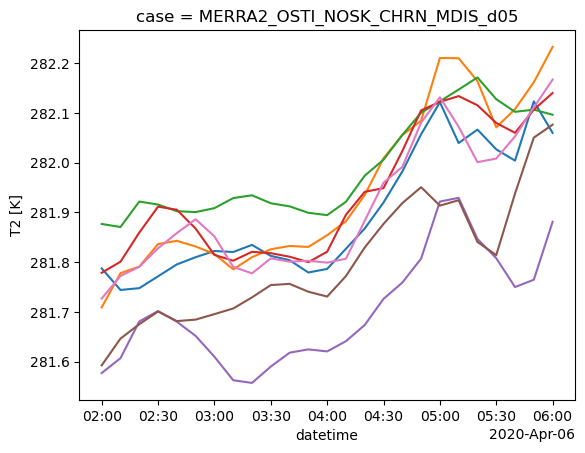

In [145]:
for case in wrf_ds_full.case:
    if 'd05' in str(case.data):
        wrf_ds_full.T2.sel(case=case).plot()

# Calculate some metrics:

In [16]:
def is_odd(num):
    return(num % 2 != 0)

def calc_slice_heights(n_slices=5,
                       D=100,
                       H=80):
    if not (is_odd(n_slices)): raise ValueError('n_slices must be odd')
        
    heights = np.zeros(n_slices)
    
    for i in range(1,n_slices + 1):
        heights[i-1] = H + (1.0/float(n_slices))*(i-np.ceil(n_slices/2))*D
    return(np.asarray(heights))
    

def calc_partial_area(D=100,
                      heights=None,
                      show_plot=True):
    
    if heights is None: raise ValueError('Calculate heights first')
        
    n_slices = len(heights)
    h = np.mean(heights[1:] - heights[:-1])
    R = D/2.0
    A = (np.pi*R**2)
    half_ind = int((n_slices+1)/2) # middle slice index
    slice_area = np.zeros(n_slices)
    
    H = heights[half_ind-1] # hub height

    if show_plot:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.set_aspect('equal')
        theta = np.linspace( 0 , 2 * np.pi , 720 )
        radius = R
        a = radius * np.cos( theta )
        b = radius * np.sin( theta ) + H
        plt.plot( a, b ,c='k')

    
    for n in range(0,half_ind):
        h_n = h*(n+1)

        if show_plot:
            if is_odd(n+1):
                fill_color = 'b'
            else:
                fill_color = 'grey'
        area_h_full = (R**2)*np.arccos((R-h_n)/R) - (R-h_n)*np.sqrt(2*R*h_n - h_n**2)
        if n == 0:
            slice_area[n] = area_h_full
            slice_area[n_slices-1] = slice_area[n]
            if show_plot:
                line_bottom = (H-(R-h_n))
                line_top = (H+(R-h_n))
                plt.fill_between(a[np.where(b<=line_bottom)],
                                 b[np.where(b<=line_bottom)],
                                 line_bottom,ec=None,fc=fill_color,alpha=0.2)
                plt.fill_between(a[np.where(b>=line_top)],
                                 b[np.where(b>=line_top)],
                                 line_top,ec=None,fc=fill_color,alpha=0.2)
        elif n == half_ind -1:
            slice_area[n] = A - 2.0*(np.sum(slice_area[:half_ind-1]))
            if show_plot:
                h_n_0 = h*(n)
                line_bottom_B = (H-(R-h_n_0))
                line_top_B = (H-(R-h_n))
                plt_conds = np.where((b>=line_bottom_B) & (b<=line_top_B)) 
                plt.fill_between(a[plt_conds],b[plt_conds],line_top_B,
                                 ec=None,fc=fill_color,alpha=0.2)
        else:
            slice_area[n] = area_h_full - sum(slice_area[:n])
            slice_area[len(heights) - n - 1] = area_h_full - sum(slice_area[:n])
            if show_plot:
                h_n_0 = h*(n)
                line_bottom_B = (H-(R-h_n_0))
                line_top_B = (H-(R-h_n))
                plt_conds = np.where((b>=line_bottom_B) & (b<=line_top_B)) 
                plt.fill_between(a[plt_conds],b[plt_conds],line_top_B,
                                 ec=None,fc=fill_color,alpha=0.2)
                
                line_top_T = (H+(R-h_n_0))
                line_bottom_T = (H+(R-h_n))
                plt_conds = np.where((b>=line_bottom_T) & (b<=line_top_T)) 
                plt.fill_between(a[plt_conds],b[plt_conds],line_bottom_T,
                                 ec=None,fc=fill_color,alpha=0.2)

    if show_plot:
        for kk,z in enumerate(heights):
            plt.text(0.0,z,'{0:4.2f}%'.format(100.0*(slice_area[kk]/A)),
                     ha='center',va='center')
        plt.ylabel('Height')
        plt.xlabel('Distance')
        plt.title('Area of Each Segment')
        plt.show()
    return(np.asarray(slice_area))
    
def interpolate_var_to_Heights(var,var_z,heights):
    var_interp = np.interp(heights,var_z,var)
    return(var_interp)

def RotorEquivalentWindSpeed(rotor_diameter=100, # rotor Diameter 
                             hub_height=80,  # rotor height
                             n_slices=5, # Number of slices to use
                             U_profile=None,   # U (same size as n_slices)
                             U_heights=None, # Heights of U
                             show_plot=False,
                             include_veer=False,
                             dir_profile=None,
                            ):
    
    heights = calc_slice_heights(n_slices=n_slices,D=rotor_diameter,H=hub_height)

    U_interp = interpolate_var_to_Heights(U_profile,U_heights,heights)
    if include_veer:
        if dir_profile is not None:
            dir_interp = interpolate_var_to_Heights(dir_profile,U_heights,heights)
        else:
            raise ValueError('dir_profile needs to be specified to include veer')

    if show_plot:
        plt.plot(U_profile,U_heights,c='k',marker='x',label='Orig')
        plt.plot(U_interp,heights,c='g',marker='o',label='interp')
        plt.legend(frameon=False)
        plt.ylabel('Height')
        plt.xlabel('Wind speed')
        plt.show()
        if include_veer:
            plt.plot(dir_profile,U_heights,c='k',marker='x',label='Orig')
            plt.plot(dir_interp,heights,c='g',marker='o',label='interp')
            plt.legend(frameon=False)
            plt.ylabel('Height')
            plt.xlabel('Wind speed')
            plt.show()
        
    partial_areas = calc_partial_area(D=rotor_diameter,heights=heights,show_plot=show_plot)
    
    R = rotor_diameter/2.0
    A = (np.pi*R**2)
    Ai_over_A = partial_areas/A
    
    if include_veer:
        #rews = np.sum(Ai_over_A*(np.asarray(U_interp)**3.0))**(1/3.0)
        hub_dir = dir_interp[np.where(heights==hub_height)]
        dir_diff = np.deg2rad(dir_interp - hub_dir)
        rews = np.sum(Ai_over_A*np.abs(U_interp)*np.cos(dir_diff))
    else:
        #rews = np.sum(Ai_over_A*(np.asarray(U_interp)**3.0))**(1/3.0)
        rews = np.sum(Ai_over_A*(np.abs(U_interp)))

    return(rews)
    

In [17]:
rotor_rad = rotor_D/2

low_z = hub_height - rotor_rad
up_z = hub_height + rotor_rad

shear = (lidar_ds_full.wspd.sel(level=up_z) - lidar_ds_full.wspd.sel(level=low_z))/(up_z-low_z)
shear.name = 'rotor_shear'
lidar_ds_full['rotor_shear'] = shear

delT = lidar_ds_full.t2 - lidar_ds_full.tsk
delT.name = 'delT'
lidar_ds_full['delT'] = delT

max_wspd = lidar_ds_full.wspd.max(dim='level')
max_wspd.name = 'max_wspd'
lidar_ds_full['max_wspd'] = max_wspd

hub_wspd = lidar_ds_full.wspd.sel(level=hub_height)
hub_wspd.name = 'hub_wspd'
lidar_ds_full['hub_wspd'] = hub_wspd

low_shear = (lidar_ds_full.wspd.sel(level=hub_height) - lidar_ds_full.wspd.sel(level=low_z))/rotor_rad
low_shear.name = 'low_shear'
lidar_ds_full['low_shear'] = low_shear

# Not sure if there's a better way than looping... but loop to find LLJ height:
stations_of_interest = ['E06']
llj_height = np.zeros(np.shape(lidar_ds_full.t2))
rews = np.zeros(np.shape(lidar_ds_full.t2))
for tt,time in enumerate(lidar_ds_full.datetime):
    wind_profile = lidar_ds_full.sel(datetime=time).wspd
    for cc,case in enumerate(lidar_ds_full.case.data):
        wind_profile = lidar_ds_full.sel(datetime=time,case=case).wspd
        height_profile = lidar_ds_full.sel(datetime=time,case=case).level
        dir_profile = lidar_ds_full.sel(datetime=time,case=case).wdir

        if np.isnan(wind_profile.max().data):
            llj_height[cc,tt] = np.nan
        else:
            llj_height[cc,tt] = height_profile[np.where(wind_profile==wind_profile.max())].data[0]
            rews[cc,tt] = RotorEquivalentWindSpeed(rotor_diameter=rotor_D, 
                                                   hub_height=hub_height, 
                                                   n_slices=7, 
                                                   U_profile=wind_profile, 
                                                   U_heights=height_profile, 
                                                   show_plot=False,
                                                   include_veer=True,
                                                   dir_profile=dir_profile)
llj_height_da = xr.DataArray(
                            data=llj_height,
                            dims=['case', 'datetime'],#, 'station'],
                            coords=dict(
                                case=lidar_ds_full.case.data,
                                #station=lidar_ds_full.station.sel(station=stations_of_interest).data,
                                datetime=lidar_ds_full.datetime.data,
                            ),
                        )
lidar_ds_full['llj_height'] = llj_height_da

rews_da = xr.DataArray(
                       data=rews,
                       dims=['case', 'datetime'],#, 'station'],
                       coords=dict(
                           case=lidar_ds_full.case.data,
                           #station=lidar_ds_full.station.sel(station=stations_of_interest).data,
                           datetime=lidar_ds_full.datetime.data,
                       ),
                   )
lidar_ds_full['rews'] = rews_da

In [160]:
def calculate_wind_power(wind_speeds, air_density, blade_radius, cp):
    """
    Calculates wind power from a time series of wind speeds.

    Args:
        wind_speeds (list or np.array): Time series of wind speeds in m/s.
        air_density (float): Air density in kg/m³.
        blade_radius (float): Blade radius of the turbine in meters.
        cp (float): Coefficient of performance of the turbine.

    Returns:
        np.array: Time series of wind power in Watts.
    """
    swept_area = np.pi * (blade_radius**2)
    power_output = 0.5 * air_density * swept_area * (wind_speeds**3) * cp
    return power_output

{'d01': [array(15080959.58597882), array(15491347.74352829), array(14620515.07142758), array(15158742.15093991), array(14738181.99922913), array(14958243.79955135), array(15179057.13372277)], 'd02': [array(13997642.06043628), array(14200470.11431625), array(13778674.28420395), array(13919986.03567873), array(14205643.30947671), array(14605273.48141332), array(13834984.65371049)], 'd03': [array(15630805.0309338), array(16149701.01481552), array(15313189.56311894), array(15910570.15797216), array(16340953.02023591), array(16136937.1572705), array(15769960.95877621)], 'd04': [array(15759851.99131013), array(16466564.61789404), array(15491420.82902496), array(16263492.38839843), array(16625254.42112437), array(16456407.09761305), array(16140838.45642472)], 'd05': [array(15870534.13928482), array(16627251.66403491), array(15649194.47138199), array(16402378.0922758), array(16789065.18800414), array(16591471.60597085), array(16277601.47572261)], 'obs': [array(13299098.07519109)]}


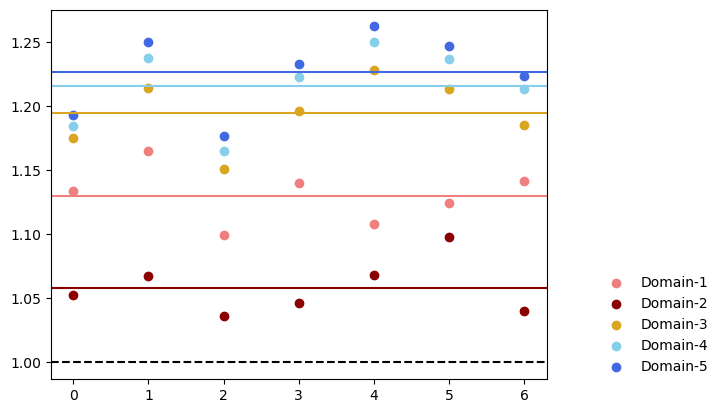

In [199]:
# Example Usage:
wind_speed_series = lidar_ds_full.rews
rho = 1.225  # kg/m³
R = 80  # meters
Cp = 0.4  # typical value for a real turbine

power_series = calculate_wind_power(wind_speed_series, rho, R, Cp)
power_series_mean = power_series.mean(dim='datetime')
d01_power = []
d02_power = []
d03_power = []
d04_power = []
d05_power = []

power_doms = np.arange(1,6)
power_dict = {}
for dom in power_doms:
    power_dict['d0{}'.format(dom)] = []
for dom in power_doms:
    for case in power_series_mean.case.data:
        if ('d0{}'.format(dom) in case):
            power_dict['d0{}'.format(dom)] += [power_series_mean.sel(case=case).data]

power_dict['obs'] = [power_series_mean.sel(case='obs').data]

print(power_dict)
for dom in power_doms:
    plt.scatter(np.arange(7),power_dict['d0{}'.format(dom)]/power_dict['obs'][0],color=dom_dict[dom]['color'],label='Domain-{}'.format(dom))
    plt.axhline(np.mean(power_dict['d0{}'.format(dom)])/power_dict['obs'][0],color=dom_dict[dom]['color'])
#plt.axhline(power_dict['obs'],ls='--',c='k')
plt.axhline(1.0,ls='--',c='k')
plt.legend(frameon=False,ncols=1,loc=(1.1,0.0))
plt.show()

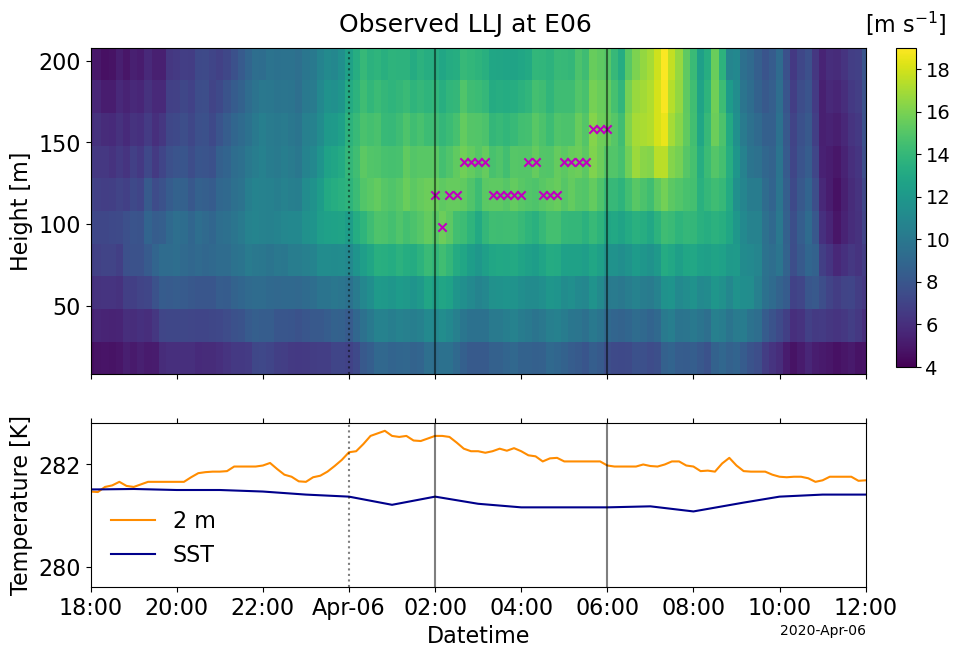

In [18]:
add_profiles = False

fig,ax = plt.subplots(nrows=2,figsize=(10,7),sharex=True,gridspec_kw={'height_ratios': [2, 1]})

resampled_obs = nyserda_obs.resample({'datetime':'10min'}).mean()

plt_levels = resampled_obs.Ulevels.data

plt_levels = 0.5*(plt_levels[1:] + plt_levels[:-1])

plt_times = list(resampled_obs.datetime.data - pd.to_timedelta('5min'))
plt_times += [plt_times[-1]+pd.to_timedelta('5min')]
plt_times = np.asarray(plt_times)

dz = np.mean(plt_levels[1:] - plt_levels[:-1])

plt_levels = [plt_levels[0] - dz] + list(plt_levels) + [plt_levels[-1] + dz]

wspd_plt = ax[0].pcolormesh(plt_times,
                            plt_levels,
                            resampled_obs.wspd.T.sel(lidar='E06'),
                            rasterized=True,
                            vmin=4.0,
                            vmax=19.0)
ax[0].scatter(lidar_ds_full.sel(case='obs').datetime,lidar_ds_full.sel(case='obs').llj_height,marker='x',c='m')
resampled_obs.sel(lidar='E06').T.dropna(how='any',dim='datetime').plot(ax=ax[1],c='darkorange',label='2 m')
resampled_obs.sel(lidar='E06').sst.dropna(how='any',dim='datetime').plot(ax=ax[1],c='darkblue',label='SST')

for axi in range(0,2):
    ax[axi].set_xlim(pd.to_datetime('2020-04-05 18:00'),pd.to_datetime('2020-04-06 12:00'))
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_title('')
    ax[axi].axvline(pd.to_datetime('2020-04-06 00:00'),c='k',ls=':',alpha=0.5)
    ax[axi].axvline(pd.to_datetime(case_start),c='k',ls='-',alpha=0.5)
    ax[axi].axvline(pd.to_datetime(case_end),c='k',ls='-',alpha=0.5)
    
ax[1].tick_params(top=True)
ax[0].set_ylabel('Height [m]',size=16)
ax[1].set_ylabel('Temperature [K]',size=16)

cax  = fig.add_axes([0.93,0.424,0.02,0.456])
cbar = plt.colorbar(wspd_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m s$^{-1}$]',size=16,y=1.02)

if add_profiles:
    plt.draw()
    xticks = ax[1].get_xticklabels()
    xtick_times = []
    for tt,ticktime in enumerate(xticks):
        ttime = '2020-{}:00:00'.format(ticktime.get_text())
        print(ticktime.get_text())
        xtick_times += [pd.to_datetime(ttime)]

    wspd_profiles = nyserda_obs.wspd.sel(lidar='E06').dropna(how='all',dim='datetime').sel(datetime=xtick_times,method='nearest')

    wax = ax[0].twiny()
    wspd_profiles -= wspd_profiles.isel(Ulevels=0)
    wspd_profiles /= 10
    wspd_profiles = wspd_profiles + np.arange(0,len(xtick_times))
    for dtime in wspd_profiles.datetime[:-1]:
        wspd_profiles.sel(datetime=dtime).dropna(how='any',dim='Ulevels').plot(y='Ulevels',ax=wax,c='lightblue')

    for vline in range(0,10):
        wax.axvline(vline,c='k',alpha=0.5,ls=':')
    wax.set_xlim(0,9)
    wax.tick_params(labeltop=False,top=False)
    wax.set_title('')
ax[0].set_xlabel('')
ax[1].set_xlabel('Datetime',size=16)
ax[1].legend(frameon=False,fontsize=16)
plt.suptitle('Observed LLJ at E06',size=18,y=0.93)

if obs_shift != '0min':
    for axi in range(0,2):
        ax[axi].axvline(pd.to_datetime('2020-04-06 00:00')+pd.Timedelta(obs_shift),c='r',ls=':',alpha=0.5,lw=2.0)
        ax[axi].axvline(pd.to_datetime(case_start)+pd.Timedelta(obs_shift),c='r',ls='-',alpha=0.5,lw=2.0)
        ax[axi].axvline(pd.to_datetime(case_end)+pd.Timedelta(obs_shift),c='r',ls='-',alpha=0.5,lw=2.0)
fig_name = '{}E06Obs_10min_lljz'.format(save_dir)
if add_profiles:
    fig_name += '_withProfiles'
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

# Visualize model output:

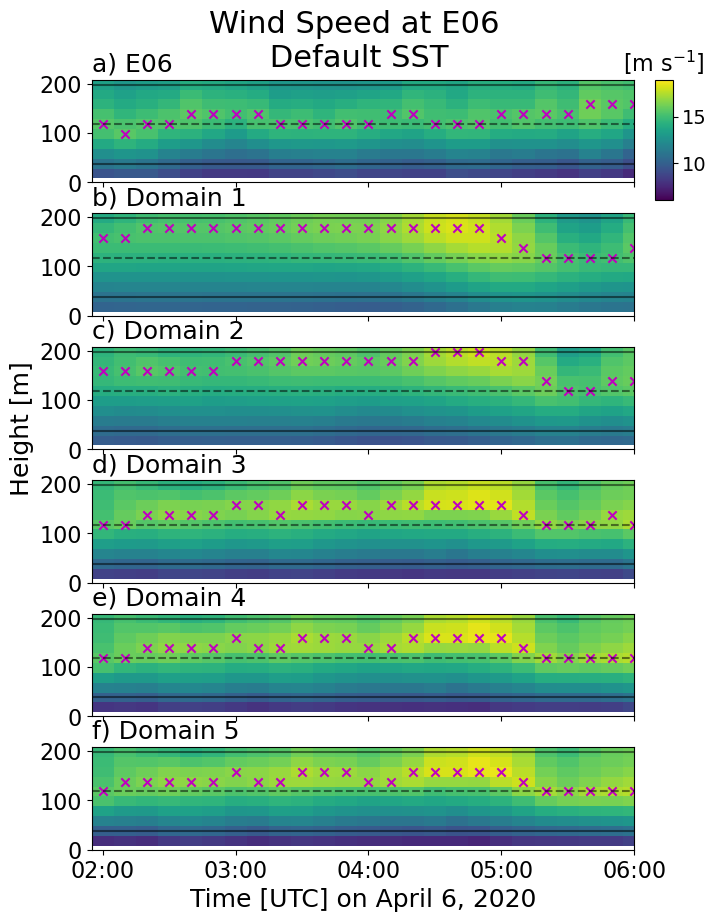

In [19]:
xticks = pd.date_range(start=pd.to_datetime(case_start),
                       end=pd.to_datetime(case_end),
                       freq=pd.Timedelta('1h'))
xticklabels = []
for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]

for cc,case in enumerate(cases[:1]):
    doms_to_plot = [1,2,3,4,5]
    
    nrows = len(doms_to_plot) + 1
    fig,ax = plt.subplots(nrows=nrows,figsize=(7,10),sharex=True)
    plt.subplots_adjust(hspace=0.3)
    
    cases_to_sel = []
    for case_str in lidar_ds_full.case:
        case_str = str(case_str.data)
        if case in case_str:
            if int(case_str.split('_')[-1][-1]) in doms_to_plot:
                cases_to_sel += [case_str]

    #vmin = lidar_ds_full.sel(case=cases_to_sel).wspd.min()
    #vmax = lidar_ds_full.sel(case=cases_to_sel).wspd.max()
    
    vmin = uniform_wspd_min
    vmax = uniform_wspd_max
    
    obs_ds = lidar_ds_full.sel(case='obs')
    plt_times = list(obs_ds.datetime.data - pd.to_timedelta('5min'))
    plt_times += [plt_times[-1]+pd.to_timedelta('5min')]
    plt_times = np.asarray(plt_times)
    obs_plt = ax[0].pcolormesh(plt_times,plt_levels,obs_ds.wspd.T,
                               vmin=vmin,vmax=vmax,rasterized=True)
    ax[0].scatter(dom_ds.datetime,obs_ds.llj_height,marker='x',c='m')
    ax[0].set_title('{}) E06'.format(ascii_lowercase[0]),size=18,x=0.0,ha='left')
    for dd,dom in enumerate(doms_to_plot):
        dom_str = 'd0{}'.format(dom)
        dom_ds = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str))
        #twr_plt = ax[dd+1].pcolormesh(dom_ds.datetime,dom_ds.level,dom_ds.wspd.T,
        #                              vmin=vmin,vmax=vmax,rasterized=True)
        twr_plt = ax[dd+1].pcolormesh(plt_times,plt_levels,dom_ds.wspd.T,
                                      vmin=vmin,vmax=vmax,rasterized=True)
        ax[dd+1].scatter(dom_ds.datetime,dom_ds.llj_height,marker='x',c='m')
        ax[dd+1].set_title('{}) Domain {}'.format(ascii_lowercase[dd+1],dom),size=18,x=0.0,ha='left')

    for dd in range(0,nrows):
        ax[dd].tick_params(labelsize=16)
        #ax[dd].set_title(dom_str,size=22)
        ax[dd].set_ylabel('')
        ax[dd].set_xticks(xticks)
        ax[dd].set_xticklabels(xticklabels)
        ax[dd].set_yticks(np.arange(0,201,100))
        ax[dd].set_ylim(0,220)
        ax[dd].plot([plt_times[0],plt_times[-1]],
                    [low_z,low_z],c='k',alpha=0.5)
        ax[dd].plot([plt_times[0],plt_times[-1]],
                    [hub_height,hub_height],c='k',alpha=0.5,ls='--')
        ax[dd].plot([plt_times[0],plt_times[-1]],
                    [up_z,up_z],c='k',alpha=0.5)
        ax[dd].set_xlim(plt_times[0],plt_times[-1])
        ax[dd].set_ylim(0.0,plt_levels[-1])
    ax[3].set_ylabel('Height [m]',size=18,y=1.5)

    ax[nrows-1].set_xlabel('Time [UTC] on April 6, 2020',size=18)
    cax  = fig.add_axes([0.93,0.76,0.025,0.12])

    cbar = plt.colorbar(twr_plt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
    if cc == 0:
        case_str = 'Default'
    else:
        case_str = case_dict[case]['sst']
    plt.suptitle('Wind Speed at E06\n {} SST'.format(case_str),size=22,y=0.95)
    plt.draw()
    xticklabels = ax[nrows-1].get_xticklabels()
    #new_xlabels = []
    #for lbl in xticklabels:
    #    new_xlabels += ['{}'.format(lbl.get_text()[-2:])]
    #ax[nrows-1].set_xticklabels(new_xlabels, rotation = 0, ha="center")
    
    fig_name = '{}DomainCompare_{}'.format(save_dir,case_str)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    
    plt.show()

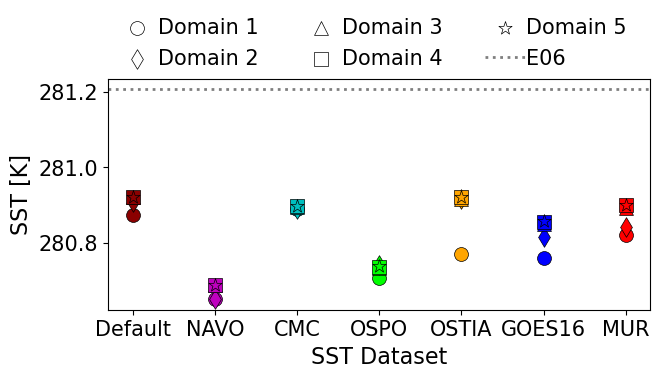

In [20]:
plt.figure(figsize=(7,3))
varn = 'tsk'
xlabels = []
for cc,case in enumerate(case_plot_order):
    cases_of_interest_case = []
    for dom in [1,2,3,4,5]:
        dom_str = 'd0{}'.format(dom)
        case_str = '{}_{}'.format(case,dom_str)


        dom_ds = lidar_ds_full.sel(case=case_str)
        #plt.scatter(lidar_ds_full.sel(case='obs')[varn],dom_ds[varn])
        plt.scatter(cc,dom_ds[varn].mean(dim='datetime'),
                    c=case_dict[case]['color'],
                    marker=dom_dict[dom]['marker'],
                    ec='k',
                    lw=0.5,
                    s=100)
        if cc == 0:
            plt.scatter([],[],c='w',ec='k',lw=0.5,s=100,marker=dom_dict[dom]['marker'],label='Domain {}'.format(dom))
    case_title = case_dict[case]['sst']
    if case_title == 'orig': case_title = 'Default'
    xlabels += [case_title]
    
plt.xticks(np.arange(0,len(cases)),xlabels)
plt.axhline(lidar_ds_full.sel(case='obs')[varn].mean(dim='datetime'),
            c='k',alpha=0.5,ls=':',lw=2.0,label='E06')
plt.tick_params(labelsize=15)
plt.ylabel('SST [K]',size=16)
plt.xlabel('SST Dataset',size=16)
plt.legend(frameon=False,fontsize=15,ncol=3,loc=(0.0,1.01),
           handletextpad=0.01)
fig_name = '{}SSTCompare'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

plt.show()


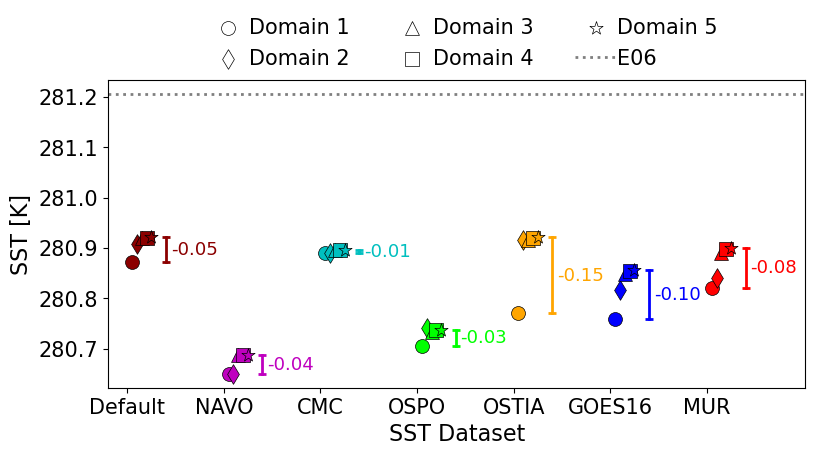

In [21]:
fig,ax = plt.subplots(figsize=(9,4))
varn = 'tsk'
xlabels = []

for cc,case in enumerate(case_plot_order):
    cases_of_interest_case = []
    for dom in [1,2,3,4,5]:
        dom_str = 'd0{}'.format(dom)
        case_str = '{}_{}'.format(case,dom_str)


        dom_ds = lidar_ds_full.sel(case=case_str)
        #plt.scatter(lidar_ds_full.sel(case='obs')[varn],dom_ds[varn])
        plt.scatter(cc+dom*0.05,dom_ds[varn].mean(dim='datetime'),
                    c=case_dict[case]['color'],
                    marker=dom_dict[dom]['marker'],
                    ec='k',
                    lw=0.5,
                    s=100)
        if cc == 0:
            plt.scatter([],[],c='w',ec='k',lw=0.5,s=100,marker=dom_dict[dom]['marker'],label='Domain {}'.format(dom))
            #if dom == 1: plt.plot([],[],c='w',label=' ')    

            
    d01_val = lidar_ds_full.sel(case='{}_{}'.format(case,'d01'))[varn].mean(dim='datetime')
    d05_val = lidar_ds_full.sel(case='{}_{}'.format(case,'d05'))[varn].mean(dim='datetime')
    diff_val = d01_val - d05_val
    
    sep = 0.4
    plt.plot([cc+sep,cc+sep],[d01_val,d05_val],
             c=case_dict[case]['color'],lw=2.0)
    plt.scatter(cc+sep,d01_val,marker='_',
                c=case_dict[case]['color'],lw=2.0)
    plt.scatter(cc+sep,d05_val,marker='_',
                c=case_dict[case]['color'],lw=2.0)
    text_loc_x = cc+sep+0.05
    text_loc_y = d01_val-diff_val/2
        
    ax.text(text_loc_x,text_loc_y,'{0:3.2f}'.format(float(diff_val.data)),
            fontsize=13,va='center',c=case_dict[case]['color'])

    case_title = case_dict[case]['sst']
    if case_title == 'orig': case_title = 'Default'
    xlabels += [case_title]

plt.xticks(np.arange(0,len(cases)),xlabels)
plt.axhline(lidar_ds_full.sel(case='obs')[varn].mean(dim='datetime'),
            c='k',alpha=0.5,ls=':',lw=2.0,label='E06')

plt.tick_params(labelsize=15)
plt.ylabel('SST [K]',size=16)
plt.xlabel('SST Dataset',size=16)
plt.legend(frameon=False,fontsize=15,ncol=3,loc=(0.13,1.01),
           handletextpad=0.01)
plt.xlim(-0.2,cc+1.02)
fig_name = '{}SSTCompareRanges'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

plt.show()

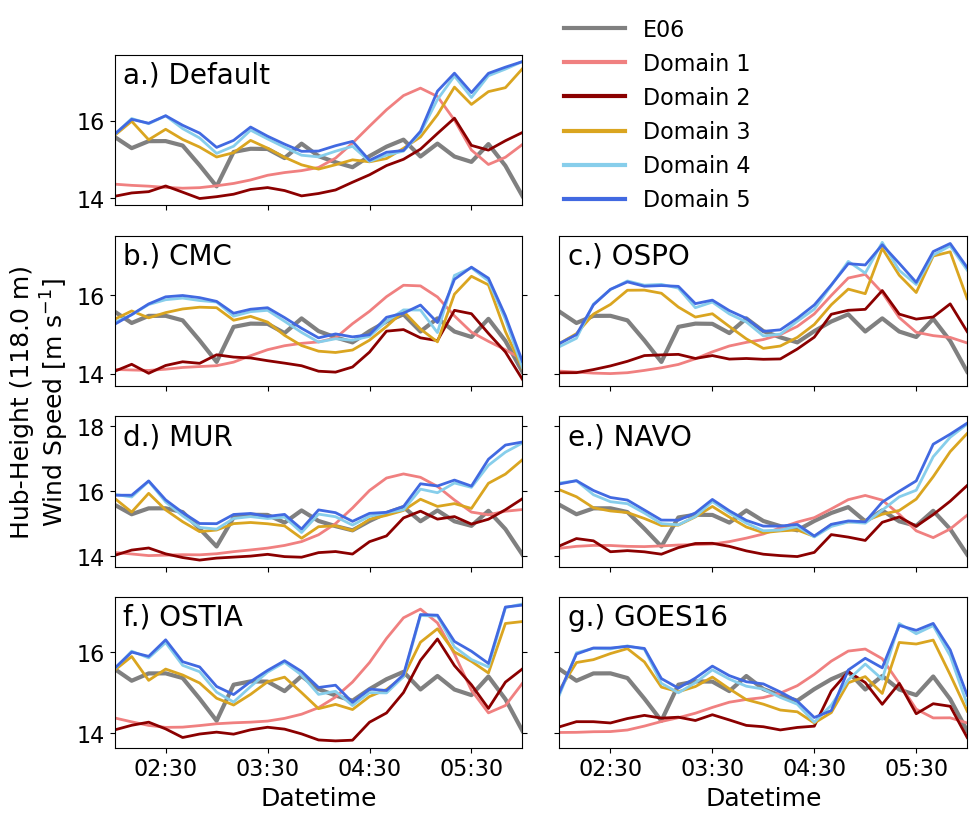

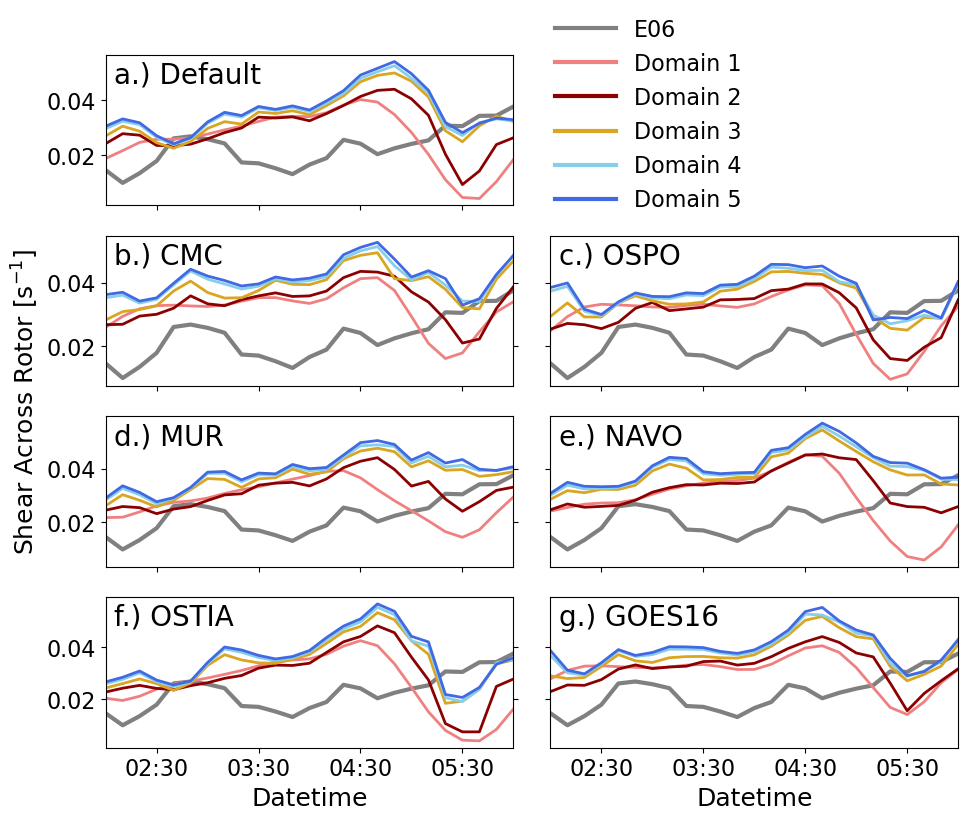

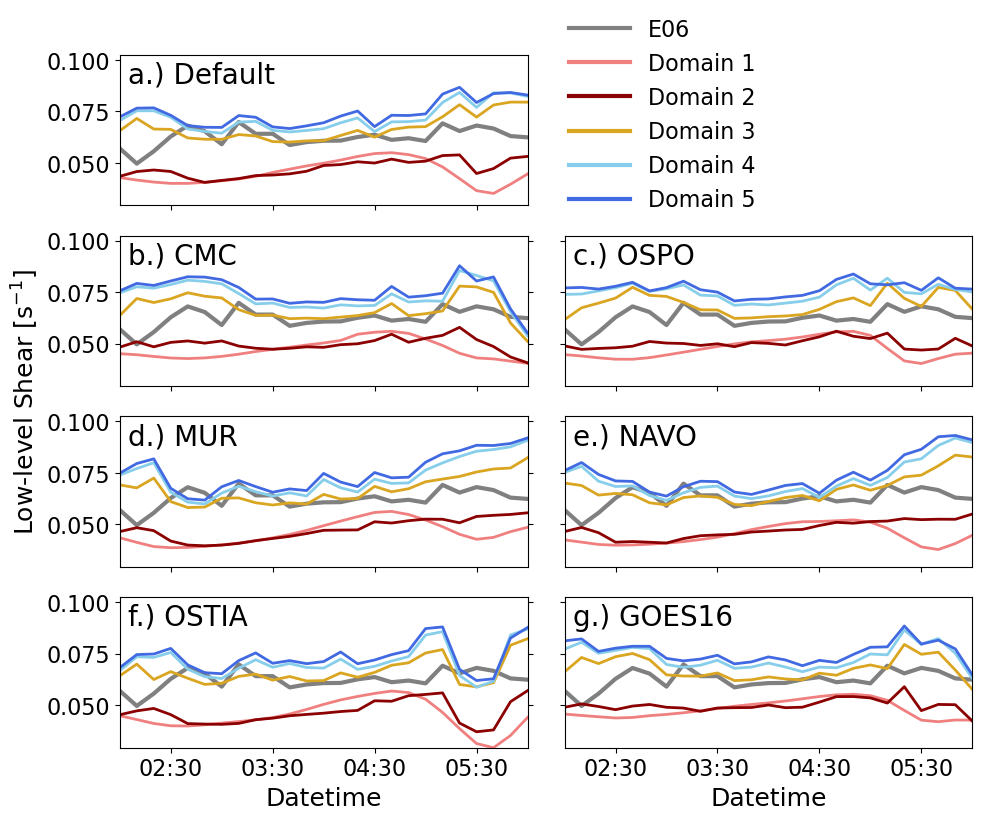

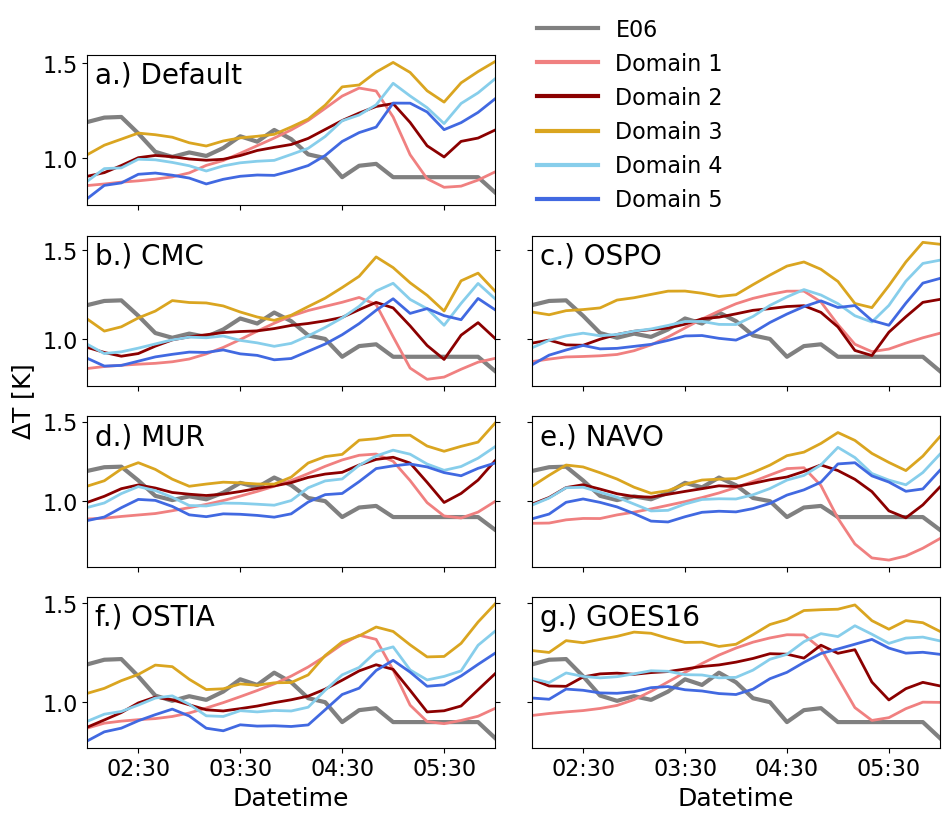

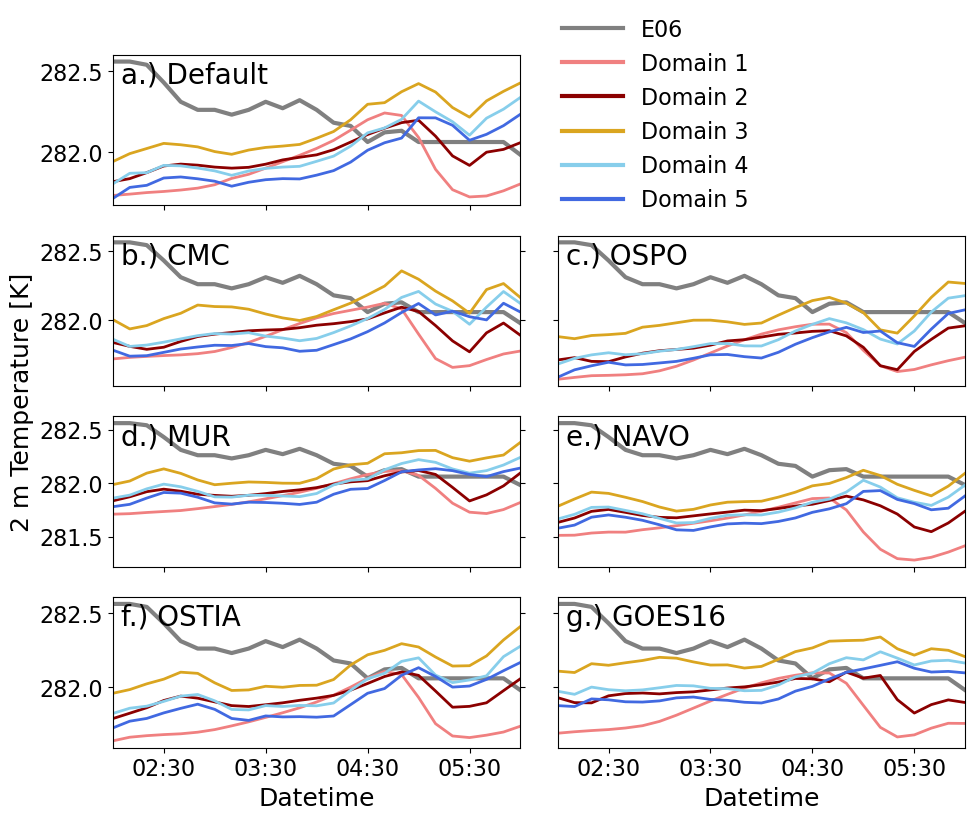

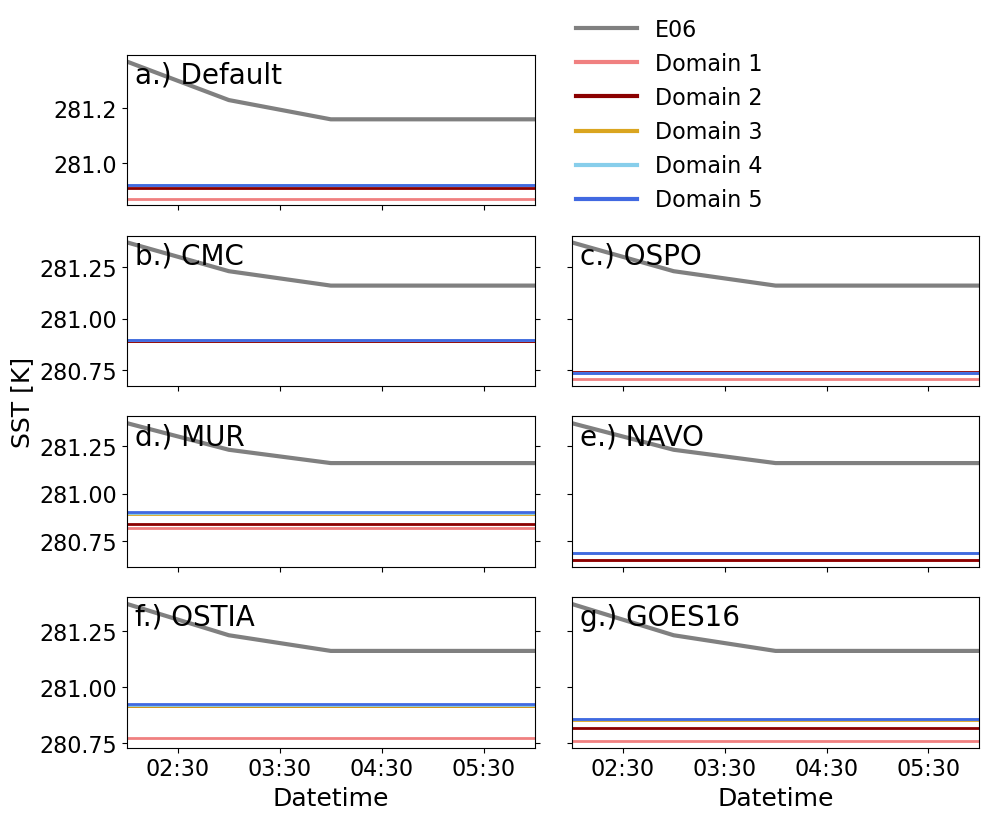

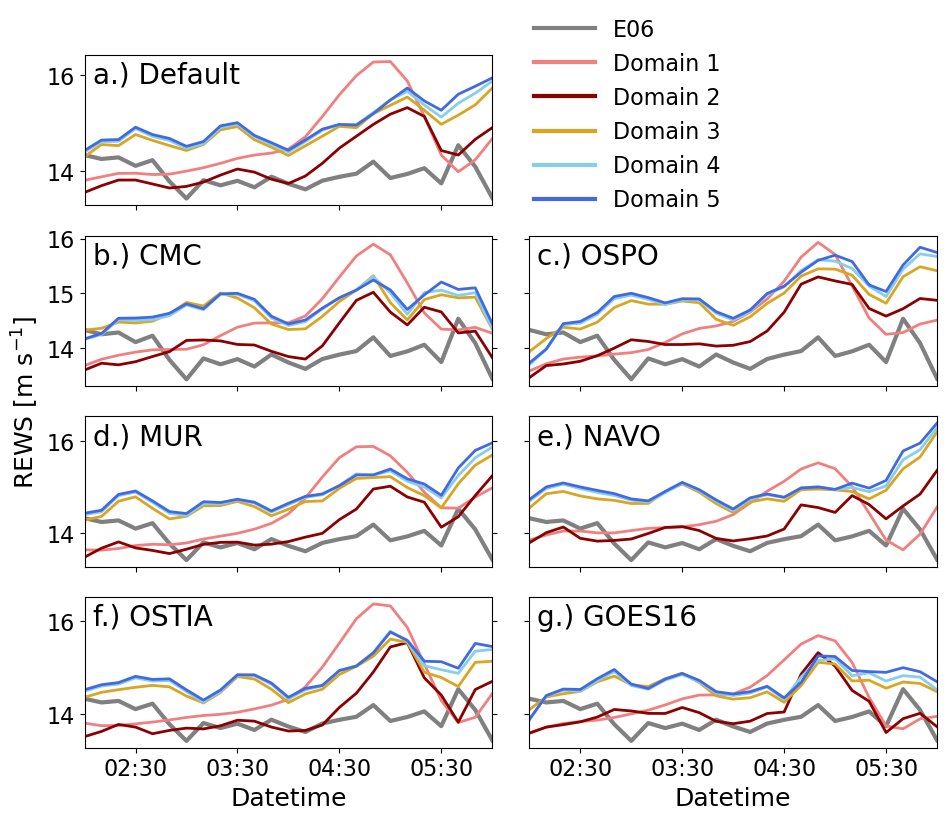

In [208]:
doms_to_plot = [1,2,3,4,5]

var_plot_dict = {'wspd':{'ylabel':'Hub-Height ({0:3.1f} m)\nWind Speed '.format(hub_height) + '[m s$^{-1}$]',
                         'title':'Hub-Height Wind Speed ({0:3.1f} m)'.format(hub_height)},
          'rotor_shear':{'ylabel':'Shear Across Rotor [s$^{-1}$]',
                         'title':'Shear Across Rotor'},
            'low_shear':{'ylabel':'Low-level Shear [s$^{-1}$]',
                         'title':'Low-level Shear'},
                 'delT':{'ylabel':'$\Delta$T [K]',
                         'title':'$\Delta$T [K]'},
                   't2':{'ylabel':'2 m Temperature [K]',
                         'title':'2 m Temperature [K]'},
                  'tsk':{'ylabel':'SST [K]',
                         'title':'SST [K]'},
                 'rews':{'ylabel':'REWS [m s$^{-1}$]',
                         'title':'REWS'},
                }
vars_to_plot = list(var_plot_dict.keys())

#hub_height = 98.0 # 98.0 or 118.0

show_shear = False 

xticks = pd.date_range(start=pd.to_datetime(case_start)+pd.to_timedelta(30,'min'),
                       end=pd.to_datetime(case_end)-pd.to_timedelta(30,'min'),
                       freq=pd.Timedelta('1h'))
xticklabels = []
for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]


for varn in vars_to_plot:

    row,col = 0,0

    fig = plt.figure(figsize=(11,9))
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    for cc,case in enumerate(cases):
        plt_pos = (row,col)
        if cc == 0:
            plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2)
            plt_title = 'Default'
        else:
            plt_title = case_dict[case]['sst']
            plt_pos = (row,col)
            if col == 0:
                plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2,sharex=plt_ax)#,sharey=plt_ax)
            else:
                plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2,sharex=plt_ax,sharey=plt_ax)

        obs_ds = lidar_ds_full.sel(case='obs').sel(datetime=slice(case_start,case_end))
        obs_var = obs_ds[varn]
        if 'level' in obs_var.dims:
            obs_var = obs_var.sel(level=hub_height)
        obs_plt = obs_var.plot(ax=plt_ax,c='grey',lw=3.0,label='Obs')
        for dom in doms_to_plot:
            dom_str = 'd0{}'.format(dom)
            dom_ds = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str)).sel(datetime=slice(case_start,case_end))
            plt_var = dom_ds[varn]
            if 'level' in plt_var.dims:
                plt_var = plt_var.sel(level=hub_height)
            
            plt_var.plot(ax=plt_ax,
                         #c=case_dict[case]['color'],
                         c=dom_dict[dom]['color'],
                         #ls=dom_dict[dom]['ls'],
                         ls='-',
                         lw=2.0,
                         #label='Domain {}'.format(dom)
                         )

        plt_ax.set_title('')
        plt_ax.set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
        if varn == 'low_shear':
            plt_ax.set_ylim(lidar_ds_full[varn].min(),lidar_ds_full[varn].max()*1.1)
        plt_ax.tick_params(labelsize=16)
        plt_ax.text(0.02,0.96,'{}.) {}'.format(ascii_lowercase[cc],plt_title),size=20,
                     transform=plt_ax.transAxes,ha='left',va='top')
        plt_ax.set_xticks(xticks)
        plt_ax.set_xticklabels(xticklabels,rotation=0,ha='center')
        if cc == 0:
            leg_handles = plt.plot([], [], c='grey', 
                                   ls='-',
                                   lw=3.0,
                                   label='E06')
            for dom in doms_to_plot:
                leg_handles += plt.plot([], [], c=dom_dict[dom]['color'], 
                                        ls='-',
                                        lw=3.0,
                                        label='Domain {}'.format(dom))


            plt_ax.legend(handles=leg_handles,
                          handlelength=2.75,
                          frameon=False,
                          fontsize=16,
                          loc=(1.08,-0.1))
        if col == 2:
            plt_ax.tick_params(labelleft=False)
            plt_ax.set_ylabel('',size=18)
        else:
            if (col == 0):
                if (row > 0):
                    plt_ax.tick_params(right=True)
            if row == 2:
                plt_ax.set_ylabel(var_plot_dict[varn]['ylabel'],size=18,y=1.1)
            else:
                plt_ax.set_ylabel('',size=18)

        if row < 3:
            plt_ax.tick_params(labelbottom=False)

        if row == 3:
            plt_ax.set_xlabel('Datetime',size=18)
        else:
            plt_ax.set_xlabel('',size=18)

        if cc == 0:
            col += 3
        else:
            col += 2
        if col >= 3:
            col = 0
            row += 1

        if show_shear:
            tax = plt_ax.twinx()


    #plt.suptitle(var_plot_dict[varn]['title'],size=22,y=0.93)
    fig_name = '{}timeseries_{}_new'.format(save_dir,varn)

    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

Default-d01	-0.402	0.046
CMC-d01	-0.423	0.035
CMC-d03	0.446	0.026
CMC-d04	0.438	0.029
CMC-d05	0.446	0.026
NAVO-d01	-0.456	0.022
OSTIA-d01	-0.425	0.034
GOES16-d01	-0.340	0.096
GOES16-d03	0.406	0.044
9 0.2571428571428571


/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3325677294.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,p = stats.pearsonr(plt_x,plt_y)


0 0.0


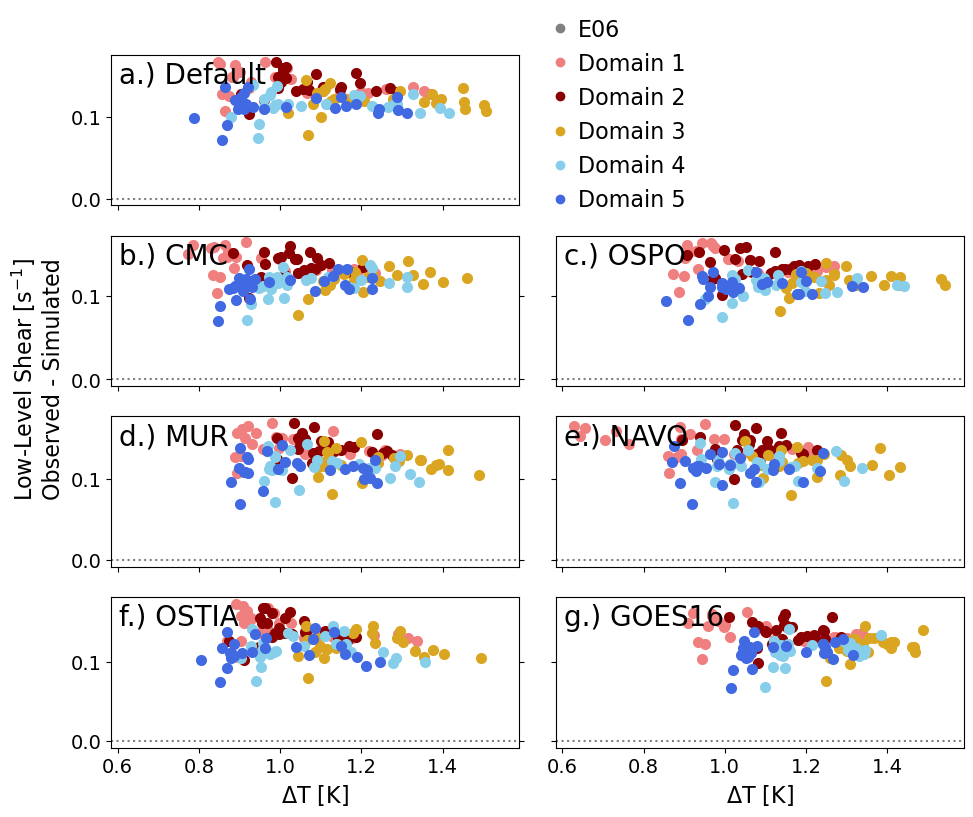

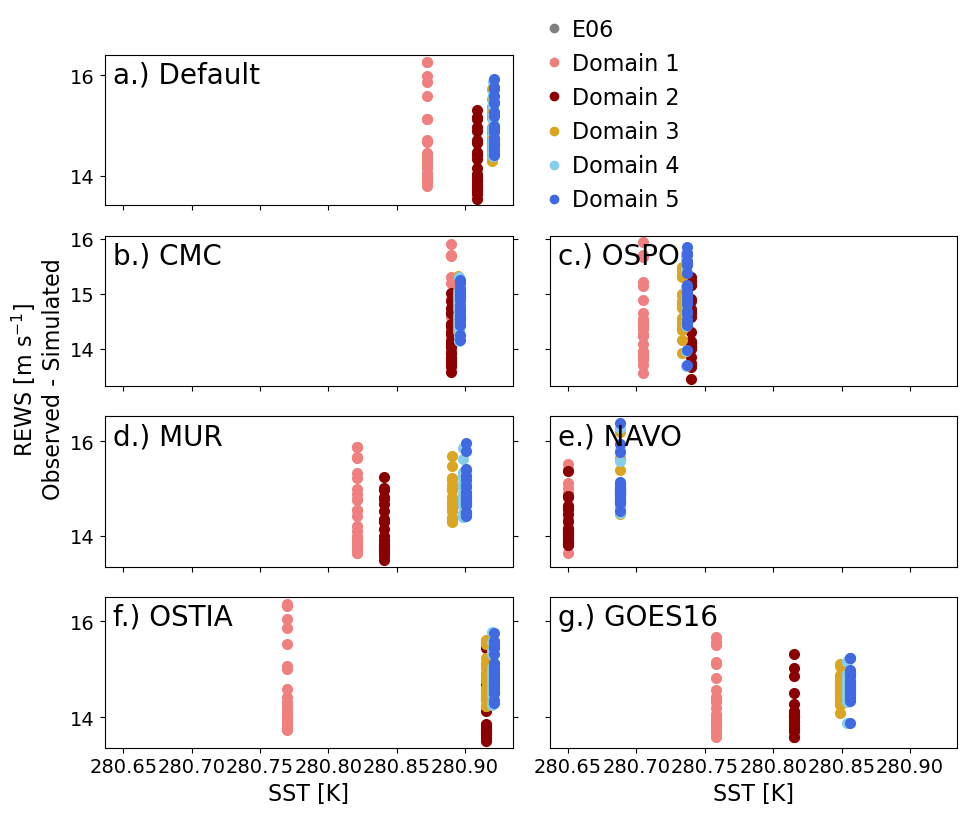

In [245]:
doms_to_plot = [1,2,3,4,5]

var_pairs = {'delT':'low_shear',
             'tsk':'rews'}

x_vars = list(var_pairs.keys())
y_vars = list(var_pairs.values())

#hub_height = 98.0 # 98.0 or 118.0

for x_varn,y_varn in zip(x_vars,y_vars):
    row,col = 0,0
    sig_count = 0
    fig = plt.figure(figsize=(11,9))
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    for cc,case in enumerate(cases):
        plt_pos = (row,col)
        if cc == 0:
            plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2)
            plt_title = 'Default'
        else:
            plt_title = case_dict[case]['sst']
            plt_pos = (row,col)
            if col == 0:
                plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2,sharex=plt_ax)#,sharey=plt_ax)
            else:
                plt_ax = plt.subplot2grid((4,4),plt_pos,colspan=2,sharex=plt_ax,sharey=plt_ax)

        obs_ds = lidar_ds_full.sel(case='obs').sel(datetime=slice(case_start,case_end))
        obs_x = obs_ds[x_varn]
        obs_y = obs_ds[y_varn]

        #obs_plt = plt_ax.scatter(obs_x,obs_y, c='grey',label='Obs')
        for dom in doms_to_plot:
            dom_str = 'd0{}'.format(dom)
            dom_ds = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str)).sel(datetime=slice(case_start,case_end))
            plt_x = dom_ds[x_varn]
            plt_y = dom_ds[y_varn]
            if y_varn == 'low_shear':
                plt_y = obs_y - plt_y
            
            plt_ax.scatter(plt_x,plt_y,
                         #c=case_dict[case]['color'],
                         c=dom_dict[dom]['color'],
                         #ls=dom_dict[dom]['ls'],
                         ls='-',
                         lw=2.0,
                         #label='Domain {}'.format(dom)
                         )
            corr,p = stats.pearsonr(plt_x,plt_y)

            if p <= 0.1:
                sig_count += 1
                print('{2}-{3}\t{0:4.3f}\t{1:4.3f}'.format(corr,p,plt_title,dom_str))
        if y_varn == 'low_shear':
            plt_ax.axhline(0.0,ls=':',alpha=0.5,c='k')
        plt_ax.text(0.02,0.96,'{}.) {}'.format(ascii_lowercase[cc],plt_title),size=20,
                     transform=plt_ax.transAxes,ha='left',va='top')
        if cc == 0:
            leg_handles = plt.plot([], [], c='grey', 
                                   #ls='-',
                                   #lw=3.0,
                                   marker='o',lw=None,

                                   label='E06')
            for dom in doms_to_plot:
                leg_handles += plt.plot([], [], c=dom_dict[dom]['color'], 
                                        #ls='-',
                                        #lw=3.0,
                                        marker='o',lw=None,
                                        label='Domain {}'.format(dom))


            plt_ax.legend(handles=leg_handles,
                          handlelength=0,
                          frameon=False,
                          fontsize=16,
                          loc=(1.08,-0.1))

        plt_ax.tick_params(labelsize=14)
        if col == 0:
            if row == 2:
                plt_ax.set_ylabel('{} [{}]\nObserved - Simulated'.format(variable_dict[y_varn]['title'],variable_dict[y_varn]['units']),size=16,y=1.25)
            if cc != 0:
                plt_ax.tick_params(right=True)
        else:
            plt_ax.tick_params(labelleft=False)
        if row == 3:
            plt_ax.set_xlabel('{} [{}]'.format(variable_dict[x_varn]['title'],variable_dict[x_varn]['units']),size=16)
        else:
            plt_ax.tick_params(labelbottom=False)
        if cc == 0:
            col += 3
        else:
            col += 2
        if col >= 3:
            col = 0
            row += 1
    print(sig_count,sig_count/(len(cases)*5))


In [ ]:
        wefwef

        plt_ax.set_title('')
        plt_ax.set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
        if varn == 'low_shear':
            plt_ax.set_ylim(lidar_ds_full[varn].min(),lidar_ds_full[varn].max()*1.1)
        plt_ax.tick_params(labelsize=16)
        plt_ax.text(0.02,0.96,'{}.) {}'.format(ascii_lowercase[cc],plt_title),size=20,
                     transform=plt_ax.transAxes,ha='left',va='top')
        plt_ax.set_xticks(xticks)
        plt_ax.set_xticklabels(xticklabels,rotation=0,ha='center')
        if cc == 0:
            leg_handles = plt.plot([], [], c='grey', 
                                   ls='-',
                                   lw=3.0,
                                   label='E06')
            for dom in doms_to_plot:
                leg_handles += plt.plot([], [], c=dom_dict[dom]['color'], 
                                        ls='-',
                                        lw=3.0,
                                        label='Domain {}'.format(dom))


            plt_ax.legend(handles=leg_handles,
                          handlelength=2.75,
                          frameon=False,
                          fontsize=16,
                          loc=(1.08,-0.1))
        if col == 2:
            plt_ax.tick_params(labelleft=False)
            plt_ax.set_ylabel('',size=18)
        else:
            if (col == 0):
                if (row > 0):
                    plt_ax.tick_params(right=True)
            if row == 2:
                plt_ax.set_ylabel(var_plot_dict[varn]['ylabel'],size=18,y=1.1)
            else:
                plt_ax.set_ylabel('',size=18)

        if row < 3:
            plt_ax.tick_params(labelbottom=False)

        if row == 3:
            plt_ax.set_xlabel('Datetime',size=18)
        else:
            plt_ax.set_xlabel('',size=18)

        if cc == 0:
            col += 3
        else:
            col += 2
        if col >= 3:
            col = 0
            row += 1

        if show_shear:
            tax = plt_ax.twinx()


    #plt.suptitle(var_plot_dict[varn]['title'],size=22,y=0.93)
    fig_name = '{}timeseries_{}_new'.format(save_dir,varn)

    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

# Calculate Ensemble Statistics:

In [23]:
def ensemble_statistics(ds,
                        variables=None,
                        observation_key='obs',
                        members_dim=None,
                        members=None,
                        ):

    if members_dim is None:
        raise ValueError ('Must specify dimension that defines the members (members_dim)')
    else:
        if members is None:
            members = list(ds[members_dim].data)
            members.remove(observation_key)
        
    if variables is None:
        variables = list(ds.variables)
        for coord in list(ds.coords):
            variables.remove(coord)

    new_ds = ds.copy()
    for varn in variables:
        data = ds[varn].sel({members_dim:members})
        ens_mean = data.mean(dim=members_dim)
        ens_mean_str = 'ens_mean_{}'.format(varn)
        ens_mean.name = ens_mean_str
        new_ds[ens_mean_str] = ens_mean
        
        ens_spread = (((data - ens_mean)**2).mean(dim=members_dim))**0.5
        ens_spread_str = 'ens_spread_{}'.format(varn)
        ens_spread.name = ens_spread_str
        new_ds[ens_spread_str] = ens_spread
        
        ens_error = ((ds[varn].sel({members_dim:observation_key}) - ens_mean)**2)**0.5
        ens_error_str = 'ens_error_{}'.format(varn)
        ens_error.name = ens_error_str
        new_ds[ens_error_str] = ens_error
        
    return(new_ds)


In [24]:
cases_of_interest = ['obs']
for cc,case in enumerate(cases):
    for dom in [1,2,3,4,5]:
        dom_str = 'd0{}'.format(dom)
        cases_of_interest += [case+'_'+dom_str]

#cases_of_interest = lidar_ds_full.case.data

ens_ds = lidar_ds_full.sel(case=cases_of_interest).copy()
ens_ds_avg = ens_ds.mean(dim='datetime')

ens_dict = {}
ens_dict_avg = {}
#for dom in doms_of_interest:
for dom in [1,2,3,4,5]:
    dom_str = 'd0{}'.format(dom)
    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    ens_ds_dom = ens_ds.sel(case=cases_of_interest_dom + ['obs'])
    ens_dict[dom_str] = ensemble_statistics(ens_ds_dom,
                                            members_dim='case')
    
    ens_ds_avg_dom = ens_ds_avg.sel(case=cases_of_interest_dom + ['obs'])
    ens_dict_avg[dom_str] = ensemble_statistics(ens_ds_avg_dom,
                                                members_dim='case')

In [25]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           color=orig_handle[0])
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[1])
        return [l1, l2]


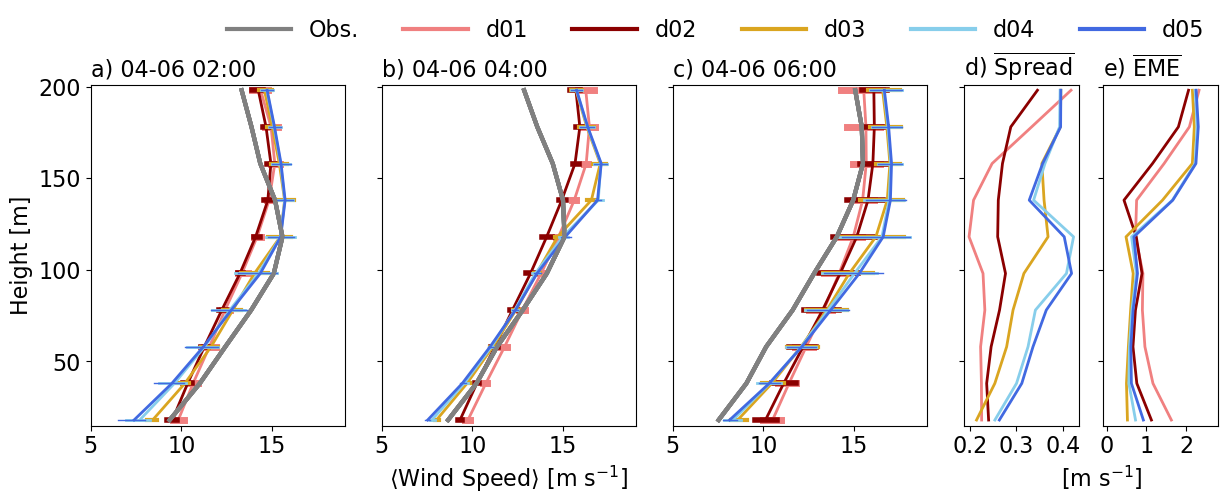

In [26]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)

plt_ntimes = 3
ptimes = pd.date_range(plt_start,plt_end,periods=plt_ntimes)

fig = plt.figure(figsize=(12,4))
gs1 = gridspec.GridSpec(1, 8)

gs1.update(left=0.05, right=0.95, wspace=0.3)

ax1 = plt.subplot(gs1[0, 0:2])
ax2 = plt.subplot(gs1[0, 2:4], sharey=ax1)
ax3 = plt.subplot(gs1[0, 4:6], sharey=ax1)
ax4 = plt.subplot(gs1[0, 6], sharey=ax1) 
ax5 = plt.subplot(gs1[0, 7], sharey=ax1)

for axi in [ax2,ax3,ax4,ax5]:
    axi.tick_params(labelleft=False)

gs1.tight_layout(fig)

nbins = len(ax5.get_xticklabels())
ax5.xaxis.set_major_locator(MaxNLocator(nbins=nbins))
ax4.xaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

# change axis location of ax5
pos4 = ax4.get_position()
pos5 = ax5.get_position()

points4 = pos4.get_points()
points5 = pos5.get_points()

mid_x = 0.5*(points4[1][0] + points5[0][0])

points4[1][0] = mid_x - 0.01
points5[0][0] = mid_x + 0.01

pos4.set_points(points4)
pos5.set_points(points5)

ax4.set_position(pos4)
ax5.set_position(pos5)

ax = [ax1,ax2,ax3,ax4,ax5]

varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
#for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    mean_ls = '-'
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=ptimes)
    data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    for tt,ptime in enumerate(data_toi.datetime):
        data_varn = data_toi.sel(case=cases_of_interest_dom,datetime=ptime)[varn]
        dom_min = data_varn.min(dim='case')
        dom_max = data_varn.max(dim='case')

        for lvl in data_toi.level:

            ax[tt].plot([dom_min.sel(level=lvl),dom_max.sel(level=lvl)],
                     #[lvl+dd*2,lvl+dd*2],c=dom_dict[dom]['color'],lw=2.0)
                     [lvl,lvl],c=dom_dict[dom]['color'],lw=5-dd)
        #ax[tt].fill_betweenx(dom_min.level,dom_min,dom_max,hatch='-')
        data_toi['ens_mean_{}'.format(varn)].sel(datetime=ptime).plot(y='level',
                                                                      c=dom_dict[dom]['color'],
                                                                      lw=2.0,
                                                                      ax=ax[tt],
                                                                      ls=mean_ls,
                                                                      alpha=1.0)
        data_toi.sel(case='obs',datetime=ptime)[varn].dropna(how='all',dim='level').plot(y='level',
                                                                                         ax=ax[tt],
                                                                                         c='grey',
                                                                                         ls=ls,
                                                                                         lw=3.0)
    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = les_spread
        err_c = les_eme
    else:
        spr_c = meso_spread
        err_c = meso_eme
        
    data_avg_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                                #c=err_c,
                                                                                c=dom_dict[dom]['color'],
                                                                                ax=ax[-1],
                                                                                label=err_str,
                                                                                #ls=dom_dict[dom]['ls'],
                                                                                ls=mean_ls,
                                                                                lw=2.0)
    data_avg_ds['ens_spread_{}'.format(varn)].plot(y='level',
                                                   #c=spr_c,
                                                   c=dom_dict[dom]['color'],
                                                   ax=ax[-2],
                                                   label=sprd_str,
                                                   #ls=dom_dict[dom]['ls'],
                                                   ls=mean_ls,
                                                   lw=2.0)
    for axi in range(0,plt_ntimes+2):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        if axi < plt_ntimes:
            title_str = '{}) {}'.format(ascii_lowercase[axi],str(ptimes[axi])[5:-3])
        elif axi == plt_ntimes:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\mathrm{Spread}}$'
        else:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\mathrm{EME}}$'
        ax[axi].set_title(title_str,size=16,x=0.0,ha='left')
        #if dd == 0:
        #    ax[axi].fill_between([0,30],low_z,up_z,fc='k',ec='none',alpha=0.1)


    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='grey',ls=ls,label='Obs.',lw=3.0)#,marker='o')
    ax[0].plot([-10,-11],[1,1],
               #c='k',
               c=dom_dict[dom]['color'],
               #ls=dom_dict[dom]['ls'],
               ls=mean_ls,
               label=dom_str,lw=3.0)#,marker='o')

    ax[0].set_ylabel('Height [m]',size=16)
    ax[-1].set_xlim(-0.1,2.8)

var_min,var_max = 5,19

for axi in range(0,plt_ntimes):
    if axi == 1:
        ax[axi].set_xlabel(r'$\langle$Wind Speed$\rangle$ [m s$^{-1}$]',size=16)
    else:
        ax[axi].set_xlabel('')
    ax[axi].set_xlim(var_min,var_max)
ax[-1].set_xlabel('[m s$^{-1}$]',size=16,x=-0.01)
ax[0].set_ylim(15,201)

leg = ax[0].legend(loc=(0.5,1.10),frameon=False,ncol=6,fontsize=16,handlelength=2.9)
#for dd,text in enumerate(leg.get_texts()):
#    if dd == 0:
#        text.set_color('k')
#    else:
#        text.set_color(dom_dict[doms_of_interest[dd-1]]['color'])

fig_name = '{}SpreadError3times_wspd_noMembers_new'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

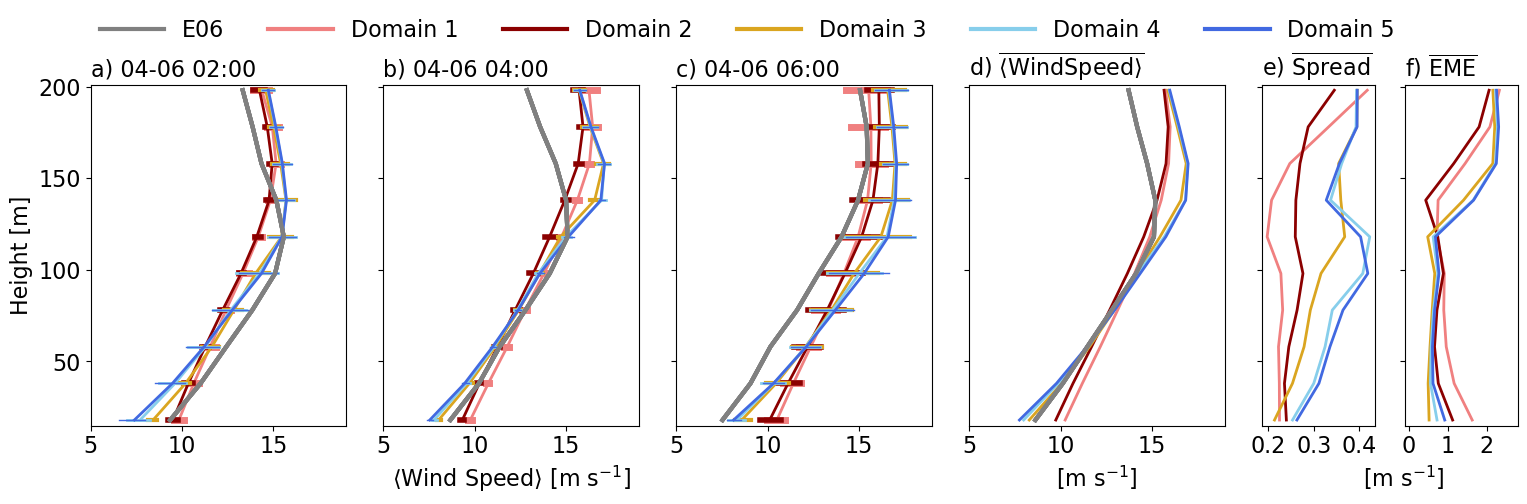

In [27]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)

plt_ntimes = 3
ptimes = pd.date_range(plt_start,plt_end,periods=plt_ntimes)

fig = plt.figure(figsize=(15,4))
gs1 = gridspec.GridSpec(1, 10)

gs1.update(left=0.05, right=0.95, wspace=0.3)

ax1 = plt.subplot(gs1[0, 0:2])
ax2 = plt.subplot(gs1[0, 2:4], sharey=ax1)
ax3 = plt.subplot(gs1[0, 4:6], sharey=ax1)
axM = plt.subplot(gs1[0, 6:8], sharey=ax1)
ax4 = plt.subplot(gs1[0, 8], sharey=ax1) 
ax5 = plt.subplot(gs1[0, 9], sharey=ax1)

ax = [ax1,ax2,ax3,axM,ax4,ax5]

for axi in ax[1:]:
    axi.tick_params(labelleft=False)

gs1.tight_layout(fig)

nbins = len(ax5.get_xticklabels())
ax5.xaxis.set_major_locator(MaxNLocator(nbins=nbins))
ax4.xaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

# change axis location of ax5
pos4 = ax4.get_position()
pos5 = ax5.get_position()

points4 = pos4.get_points()
points5 = pos5.get_points()

mid_x = 0.5*(points4[1][0] + points5[0][0])

points4[1][0] = mid_x - 0.01
points5[0][0] = mid_x + 0.01

pos4.set_points(points4)
pos5.set_points(points5)

ax4.set_position(pos4)
ax5.set_position(pos5)


varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
#for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    mean_ls = '-'
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=ptimes)
    data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

    cases_of_interest_dom = []
    for cc,case in enumerate(cases_of_interest):
        if dom_str in case:
            cases_of_interest_dom += [case]

    for tt,ptime in enumerate(data_toi.datetime):
        data_varn = data_toi.sel(case=cases_of_interest_dom,datetime=ptime)[varn]
        dom_min = data_varn.min(dim='case')
        dom_max = data_varn.max(dim='case')

        for lvl in data_toi.level:

            ax[tt].plot([dom_min.sel(level=lvl),dom_max.sel(level=lvl)],
                     #[lvl+dd*2,lvl+dd*2],c=dom_dict[dom]['color'],lw=2.0)
                     [lvl,lvl],c=dom_dict[dom]['color'],lw=5-dd)
        #ax[tt].fill_betweenx(dom_min.level,dom_min,dom_max,hatch='-')
        data_toi['ens_mean_{}'.format(varn)].sel(datetime=ptime).plot(y='level',
                                                                      c=dom_dict[dom]['color'],
                                                                      lw=2.0,
                                                                      ax=ax[tt],
                                                                      ls=mean_ls,
                                                                      alpha=1.0)
        data_toi.sel(case='obs',datetime=ptime)[varn].dropna(how='all',dim='level').plot(y='level',
                                                                                         ax=ax[tt],
                                                                                         c='grey',
                                                                                         ls=ls,
                                                                                         lw=3.0)
    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = les_spread
        err_c = les_eme
    else:
        spr_c = meso_spread
        err_c = meso_eme

    data_avg_ds['ens_mean_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                                #c=err_c,
                                                                                c=dom_dict[dom]['color'],
                                                                                ax=ax[-3],
                                                                                label=err_str,
                                                                                #ls=dom_dict[dom]['ls'],
                                                                                ls=mean_ls,
                                                                                lw=2.0)
    #data_varn = ens_dom_ds.sel(case=cases_of_interest_dom)[varn]
    #dom_min = data_varn.min(dim='case')
    #dom_max = data_varn.max(dim='case')
    #for lvl in data_toi.level:
    #    ax[-3].plot([dom_min.sel(level=lvl),dom_max.sel(level=lvl)],
    #             #[lvl+dd*2,lvl+dd*2],c=dom_dict[dom]['color'],lw=2.0)
    #             [lvl,lvl],c=dom_dict[dom]['color'],lw=5-dd)
    
    
    data_avg_ds.sel(case='obs')[varn].dropna(how='all',dim='level').plot(y='level',
                                                                         ax=ax[-3],
                                                                         c='grey',
                                                                         ls=ls,
                                                                         lw=3.0)
    
        
    data_avg_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='level').plot(y='level',
                                                                                #c=err_c,
                                                                                c=dom_dict[dom]['color'],
                                                                                ax=ax[-1],
                                                                                label=err_str,
                                                                                #ls=dom_dict[dom]['ls'],
                                                                                ls=mean_ls,
                                                                                lw=2.0)
    data_avg_ds['ens_spread_{}'.format(varn)].plot(y='level',
                                                   #c=spr_c,
                                                   c=dom_dict[dom]['color'],
                                                   ax=ax[-2],
                                                   label=sprd_str,
                                                   #ls=dom_dict[dom]['ls'],
                                                   ls=mean_ls,
                                                   lw=2.0)
    for axi in range(0,plt_ntimes+3):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        if axi < plt_ntimes:
            title_str = '{}) {}'.format(ascii_lowercase[axi],str(ptimes[axi])[5:-3])
        elif axi == plt_ntimes:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\langle\mathrm{Wind Speed}\rangle}$'            
        elif axi == plt_ntimes+1:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\mathrm{Spread}}$'
        else:
            title_str = '{}) '.format(ascii_lowercase[axi]) + r'$\overline{\mathrm{EME}}$'
        ax[axi].set_title(title_str,size=16,x=0.0,ha='left')
        #if dd == 0:
        #    ax[axi].fill_between([0,30],low_z,up_z,fc='k',ec='none',alpha=0.1)


    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='grey',ls=ls,label='E06',lw=3.0)#,marker='o')
    ax[0].plot([-10,-11],[1,1],
               #c='k',
               c=dom_dict[dom]['color'],
               #ls=dom_dict[dom]['ls'],
               ls=mean_ls,
               label='Domain {}'.format(dom),lw=3.0)#,marker='o')

    ax[0].set_ylabel('Height [m]',size=16)
    ax[-1].set_xlim(-0.1,2.8)

var_min,var_max = 5,19

for axi in range(0,plt_ntimes):
    if axi == 1:
        ax[axi].set_xlabel(r'$\langle$Wind Speed$\rangle$ [m s$^{-1}$]',size=16)
    else:
        ax[axi].set_xlabel('')
    ax[axi].set_xlim(var_min,var_max)
ax[-3].set_xlim(var_min,var_max)
ax[-3].set_xlabel('[m s$^{-1}$]',size=16)
ax[-1].set_xlabel('[m s$^{-1}$]',size=16,x=-0.01)
ax[0].set_ylim(15,201)

leg = ax[0].legend(loc=(0.0,1.10),frameon=False,ncol=6,fontsize=16,handlelength=2.9)
#for dd,text in enumerate(leg.get_texts()):
#    if dd == 0:
#        text.set_color('k')
#    else:
#        text.set_color(dom_dict[doms_of_interest[dd-1]]['color'])

fig_name = '{}SpreadError3times_wspd_noMembers_new'.format(save_dir)
if save_figs: 
    for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
plt.show()

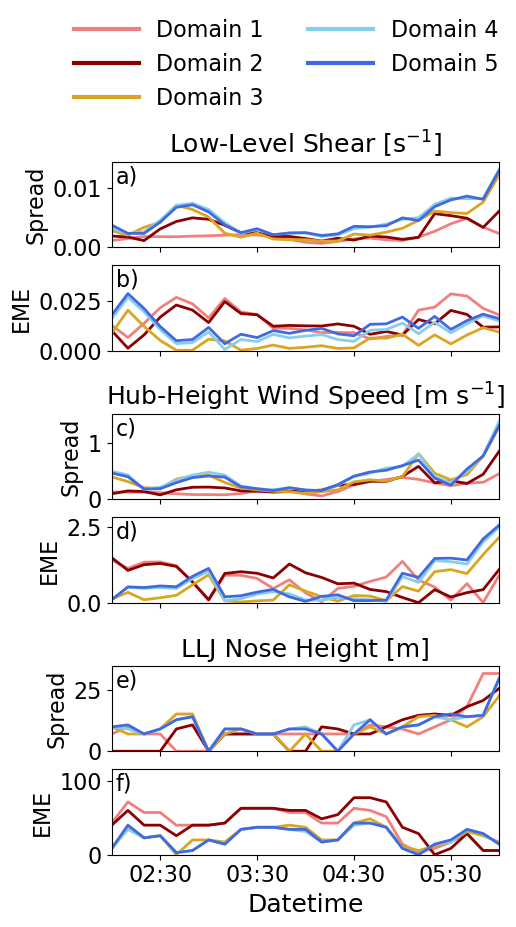

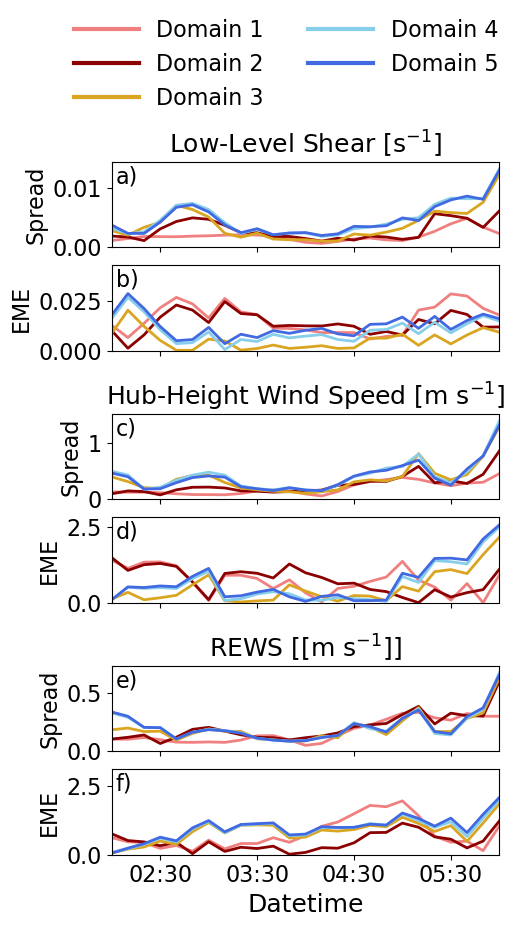

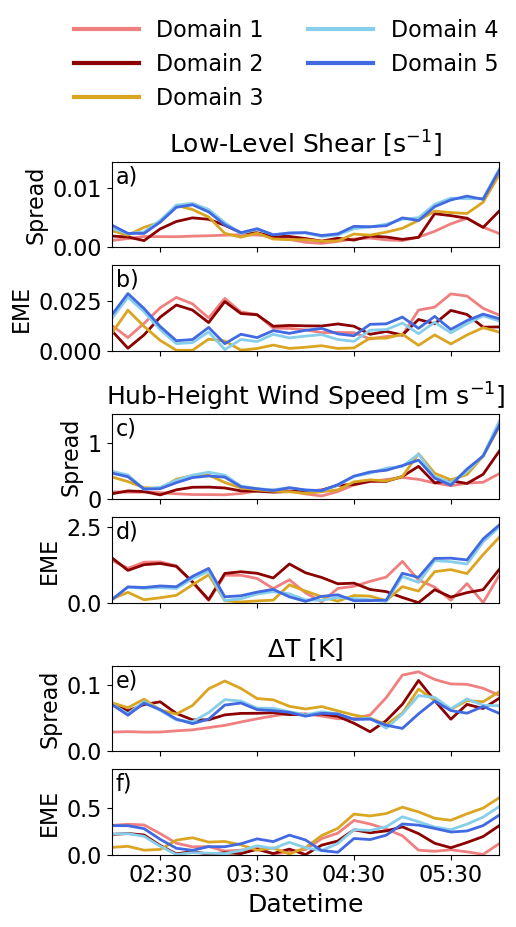

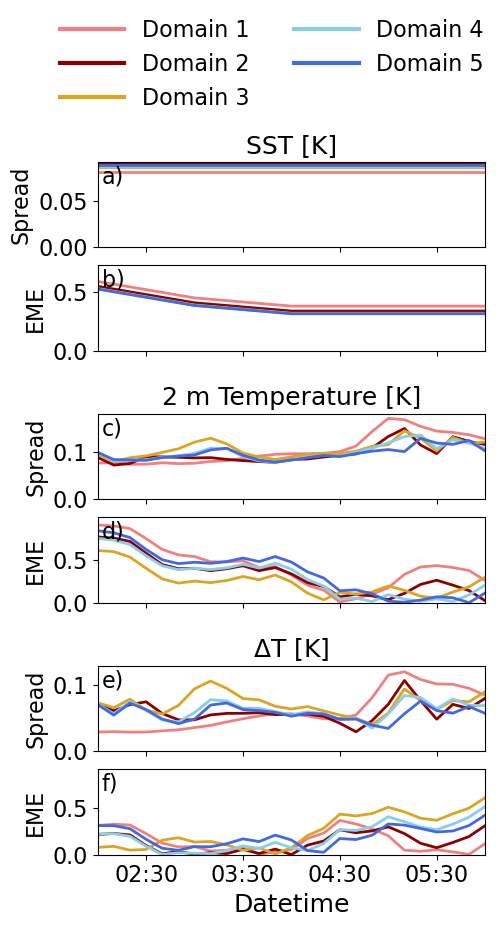

In [147]:
variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['low_shear','hub_wspd','rews'],
                   ['low_shear','hub_wspd','delT'],
                   ['tsk','t2','delT',]]


for variables in variable_groups:
    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig = plt.figure(figsize=(5,9))
    gs1 = gridspec.GridSpec(6, 1)

    gs1.update(hspace=1)

    ax1 = plt.subplot(gs1[0,0])
    ax2 = plt.subplot(gs1[1,0], sharex=ax1)
    ax3 = plt.subplot(gs1[2,0], sharex=ax1)
    ax4 = plt.subplot(gs1[3,0], sharex=ax1) 
    ax5 = plt.subplot(gs1[4,0], sharex=ax1)
    ax6 = plt.subplot(gs1[5,0], sharex=ax1)

    ax = [ax1,ax2,ax3,ax4,ax5,ax6]
    for axi in ax[:-1]:
        axi.tick_params(labelbottom=False)

    #gs1.tight_layout(fig)

    for col in range(0,3):
        a1 = col*2
        a2 = a1+1
        pos1 = ax[a1].get_position()
        pos2 = ax[a2].get_position()

        points1 = pos1.get_points()
        points2 = pos2.get_points()

        mid_y = 0.5*(points1[0][1] + points2[1][1])

        points1[0][1] = mid_y + 0.01
        points2[1][1] = mid_y - 0.01

        pos1.set_points(points1)
        pos2.set_points(points2)

        ax[a1].set_position(pos1)
        ax[a2].set_position(pos2)
    
    lid = 'E06'

    xticks = pd.date_range(start=pd.to_datetime(case_start)+pd.to_timedelta(30,'min'),
                           end=pd.to_datetime(case_end)-pd.to_timedelta(30,'min'),
                           freq=pd.Timedelta('1h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]


    sprd_min_dict = {}
    sprd_max_dict = {}
    eme_min_dict = {}
    eme_max_dict = {}
    for vv,varn in enumerate(variables):
        sprd_min_dict[varn] = 999
        sprd_max_dict[varn] = -999
        eme_min_dict[varn] = 999
        eme_max_dict[varn] = -999

    for dd,dom in enumerate(doms_of_interest):
    #for dd,dom in enumerate([1,2,4,5]):

        mean_ls = dom_dict[dom]['ls']
        ls = '-'

        dom_str = 'd0{}'.format(dom)
        ens_dom_ds = ens_dict[dom_str]
        data_toi = ens_dom_ds.sel(datetime=ptimes)
        data_avg_ds = ens_dom_ds.sel(datetime=slice(case_start,case_end)).mean(dim='datetime')

        cases_of_interest_dom = []
        for cc,case in enumerate(cases_of_interest):
            if dom_str in case:
                cases_of_interest_dom += [case]


        for vv,varn in enumerate(variables):
            
            if (dd == 10):
                err_str  = 'EME'
                sprd_str = 'Spread'
            else:
                err_str,sprd_str = None,None

            if dom >= 3:
                spr_c = les_spread
                err_c = les_eme
            else:
                spr_c = meso_spread
                err_c = meso_eme

            eme = ens_dom_ds['ens_error_{}'.format(varn)].dropna(how='all',dim='datetime')
            eme.plot(#c=err_c,
                     c=dom_dict[dom]['color'],
                     ax=ax[(vv*2)+1],
                     label=err_str,
                     #ls=mean_ls,
                     ls=ls,
                     lw=2.0)
            
            sprd = ens_dom_ds['ens_spread_{}'.format(varn)].dropna(how='all',dim='datetime')
            sprd.plot(#c=spr_c,
                      c=dom_dict[dom]['color'],
                      ax=ax[(vv*2)],
                      label=sprd_str,
                      #ls=mean_ls,
                      ls=ls,
                      lw=2.0)

            for axi in range(0,2):
                ax[vv*2 + axi].tick_params(labelsize=16)
                ax[vv*2 + axi].set_ylabel('')
                ax[vv*2 + axi].set_xlabel('')
                ax[vv*2 + axi].set_xticks(xticks)
                ax[vv*2 + axi].set_xticklabels(xticklabels,rotation=0,ha='center')
                if dd == 0:
                    ax[vv*2 + axi].text(0.01,0.96,'{})'.format(ascii_lowercase[vv*2 + axi]),
                                        ha='left',va='top',size=16,
                                        transform = ax[vv*2 + axi].transAxes)



            eme_min = eme.min()
            eme_max = eme.max()
            sprd_min = sprd.min()
            sprd_max = sprd.max()
            if eme_min < eme_min_dict[varn]: eme_min_dict[varn] = eme_min
            if eme_max > eme_max_dict[varn]: eme_max_dict[varn] = eme_max
            
            if sprd_min < sprd_min_dict[varn]: sprd_min_dict[varn] = sprd_min
            if sprd_max > sprd_max_dict[varn]: sprd_max_dict[varn] = sprd_max

            var_str = variable_dict[varn]['title']
            ax[vv*2].set_title('{} [{}]'.format(var_str,variable_dict[varn]['units']),
                             size=18)

        for vv,varn in enumerate(variables):
            #if dd == 0:
            #    ens_dom_ds.sel(case='obs')[varn].dropna(how='all',dim='datetime').plot(ax=ax[0,vv],c='grey',ls='-',
            #                                                                       lw=3.0,zorder=101,
            #                                                                       label='Obs.')
            ax[vv].plot([pd.to_datetime(case_start),
                         pd.to_datetime(case_end)],[-100,-100],
                        c=dom_dict[dom]['color'],
                        ls=ls,
                        label='Domain {}'.format(dom),
                        lw=3.0)#,marker='o')

    ax[0].legend(loc=(-0.12,1.5),frameon=False,ncol=2,fontsize=16,handlelength=2.9)
    for vv,varn in enumerate(variables):
        eme_range = eme_max_dict[varn] - eme_min_dict[varn]
        sprd_range = sprd_max_dict[varn] - sprd_min_dict[varn]
        ax[vv*2].set_ylabel('Spread',size=16)
        ax[vv*2+1].set_ylabel('EME',size=16)
        #for axi in range(0,2):
        ##ax[vv].set_ylim(var_min_dict[varn] - var_range*0.1,var_max_dict[varn] + var_range*0.1)
        #    ax[vv*2 + axi].set_ylim(0.0,var_max_dict[varn] + var_range*0.1)
        sprd_range_fct = 0.1
        eme_range_fct = 0.1
        
        if (vv == 0) or (vv == 2):
            eme_range_fct = 0.5
        
        ax[vv*2].set_ylim(0.0,sprd_max_dict[varn]+sprd_range*sprd_range_fct)
        ax[vv*2+1].set_ylim(0.0,eme_max_dict[varn]+eme_range*eme_range_fct)
        
        
    ax[0].set_xlim(plt_start,plt_end)
    ax[-1].set_xlabel('Datetime',size=18)

    fig_name = '{}OnlySpreadError_{}_new'.format(save_dir,'_'.join(variables))
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

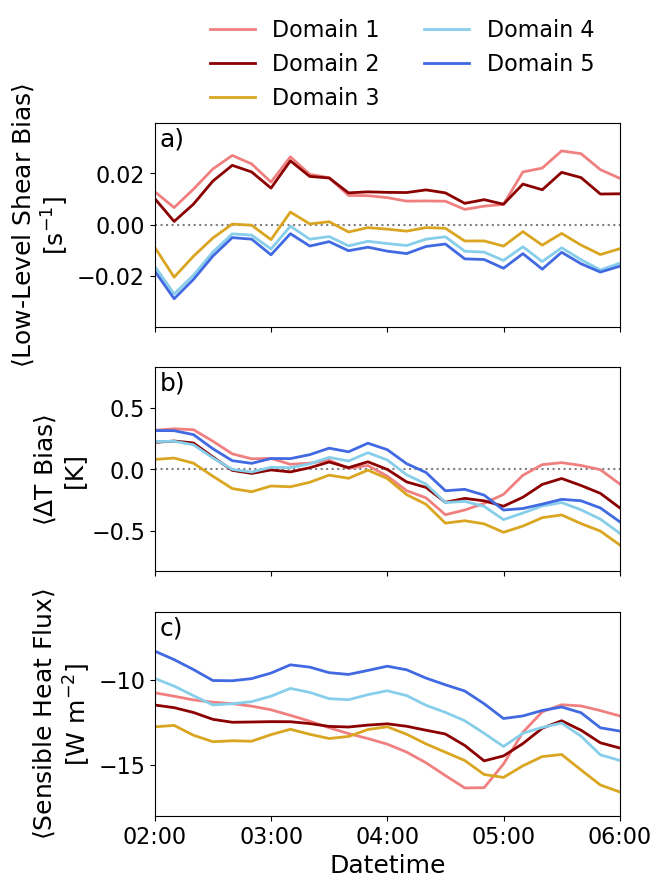

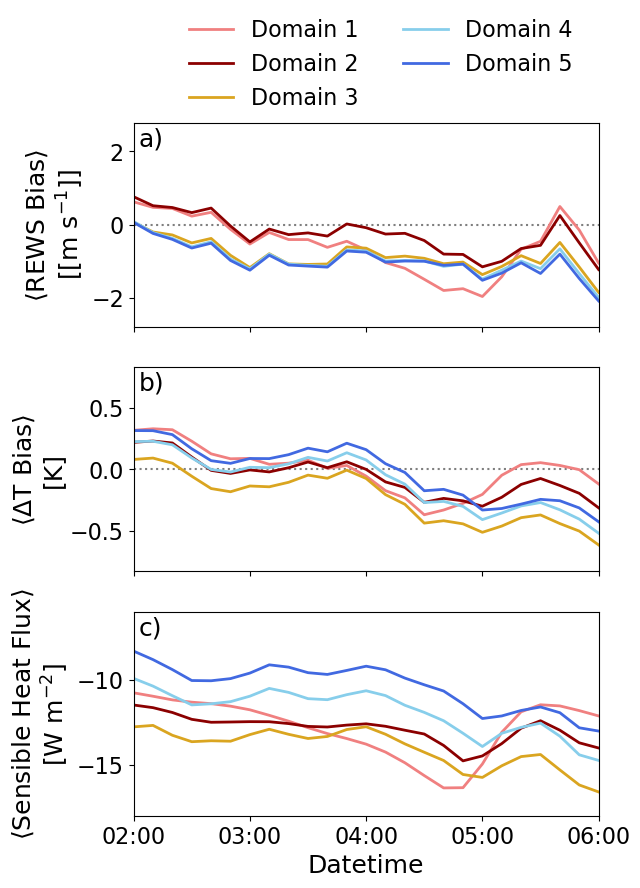

In [106]:
varnB = 'delT'

for varnA in ['low_shear','rews']:
    fig,ax = plt.subplots(nrows=3,figsize=(6,9),sharex=True)

    xticks = pd.date_range(start=pd.to_datetime(case_start),#+pd.to_timedelta(30,'min'),
                           end=pd.to_datetime(case_end),#-pd.to_timedelta(30,'min'),
                           freq=pd.Timedelta('1h'))
    xticklabels = []
    for xtick in xticks: xticklabels += [str(xtick)[-8:-3]]

    for dd,dom in enumerate(doms_of_interest):
        dom_str = 'd0{}'.format(dom)
        cases_of_interest_dom = []
        for case in ens_ds.case:
            if dom_str in str(case.data): cases_of_interest_dom += [str(case.data)]
        ens_dom_ds = ens_ds.sel(case=cases_of_interest_dom)
        
        vA = ens_dom_ds[varnA]
        biasA = ens_ds.sel(case='obs')[varnA] - vA
        bias_avgA = biasA.mean(dim='case')
        
        vB = ens_dom_ds[varnB]
        biasB =  ens_ds.sel(case='obs')[varnB] - vB
        bias_avgB = biasB.mean(dim='case')

        bias_avgA.plot(ax=ax[0],
                       c=dom_dict[dom]['color'],
                       label='Domain {}'.format(dom),
                       lw=2.0)


        bias_avgB.plot(ax=ax[1],
                       c=dom_dict[dom]['color'],
                       label='Domain {}'.format(dom),
                       lw=2.0)
        
        dom_ds = wrf_ds_full.sel(case=cases_of_interest_dom)
        mean_ds = dom_ds.mean(dim='case')
        mean_ds.HFX.plot(ax=ax[2],
                         c=dom_dict[dom]['color'],
                         lw=2.0,
                         label='Domain {}'.format(dom))
        
        
        
    for axi in range(0,3):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_xticks(xticks)
        ax[axi].text(0.01,0.98,'{})'.format(ascii_lowercase[axi]),
                     ha='left',va='top',fontsize=18,
                     transform = ax[axi].transAxes)
        yabs_max = abs(max(ax[axi].get_ylim(), key=abs))*1.25
        if axi < 2:
            ax[axi].set_ylim(ymin=-yabs_max, ymax=yabs_max)
            ax[axi].axhline(0.0,alpha=0.5,ls=':',c='k',zorder=0)
            ax[axi].set_xlabel('',size=18)

        else:
            ax[axi].set_ylim(-18,-6)
            ax[axi].set_xlabel('Datetime',size=18)

        

        
    ax[2].set_xticklabels(xticklabels,rotation=0,ha='center')
    ax[2].set_xlim(pd.to_datetime(case_start),pd.to_datetime(case_end))
    ax[0].set_ylabel(r'$\langle${} Bias$\rangle$'.format(variable_dict[varnA]['title']) +\
                     '\n[{}]'.format(variable_dict[varnA]['units']),size=18)
    ax[1].set_ylabel(r'$\langle${} Bias$\rangle$'.format(variable_dict[varnB]['title'])+\
                                     '\n[{}]'.format(variable_dict[varnB]['units']),size=18)
    ax[2].set_ylabel(r'$\langle$Sensible Heat Flux$\rangle$'+'\n[W m$^{-2}$]',size=18)

    ax[0].legend(frameon=False,fontsize=16,ncol=2,loc=(0.1,1.02))



    fig_name = '{}Bias{}_Bias{}_wHFX'.format(save_dir,varnA,varnB)
    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')

    plt.show()

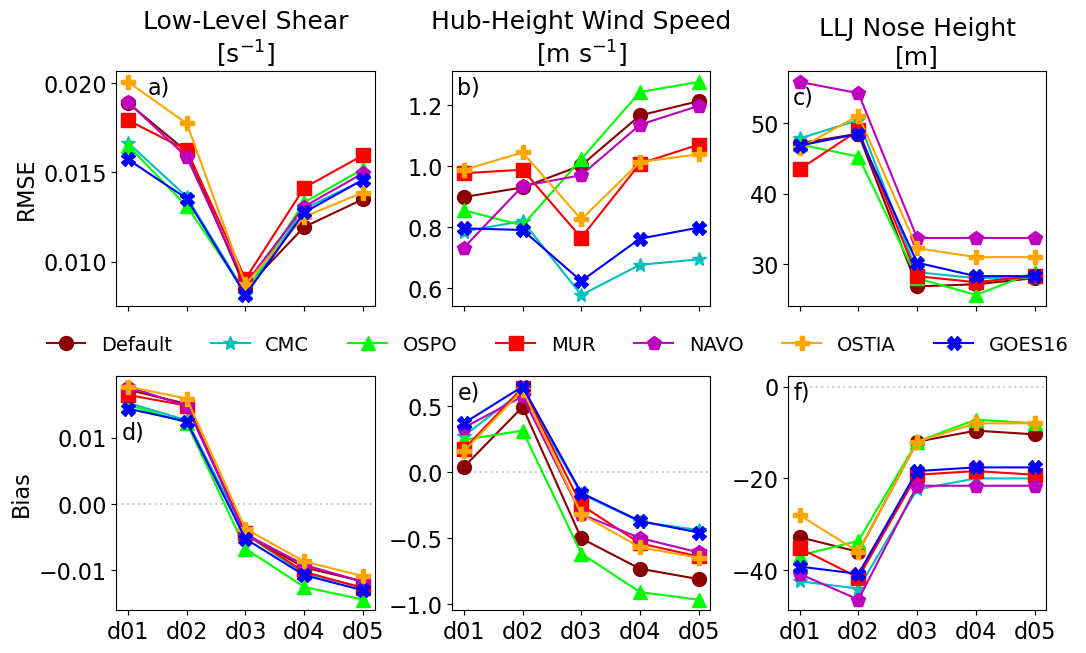

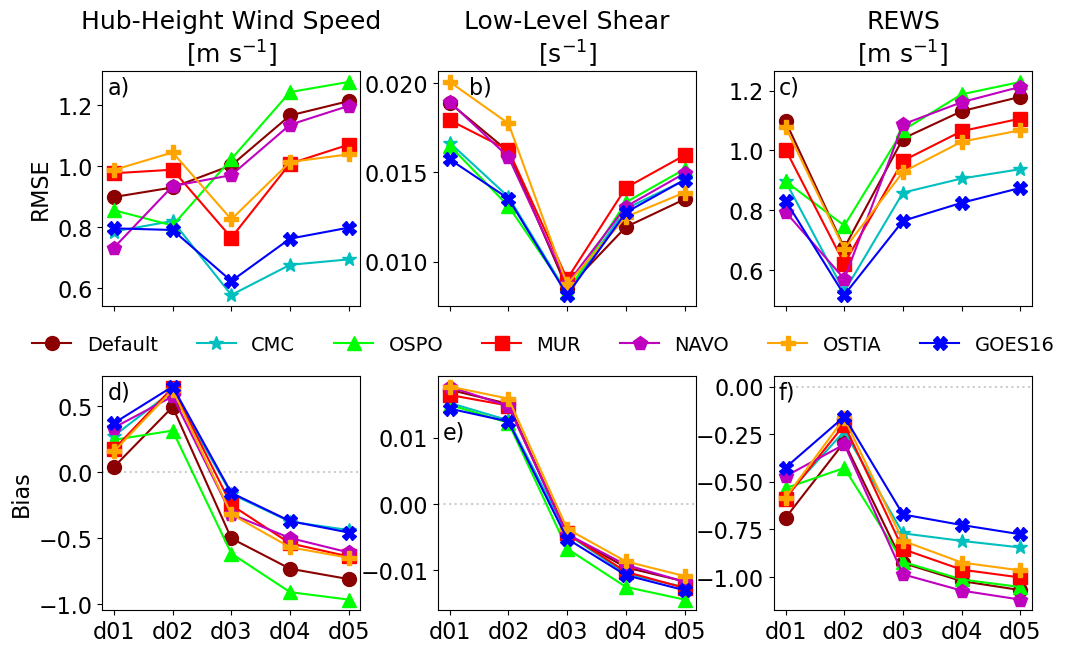

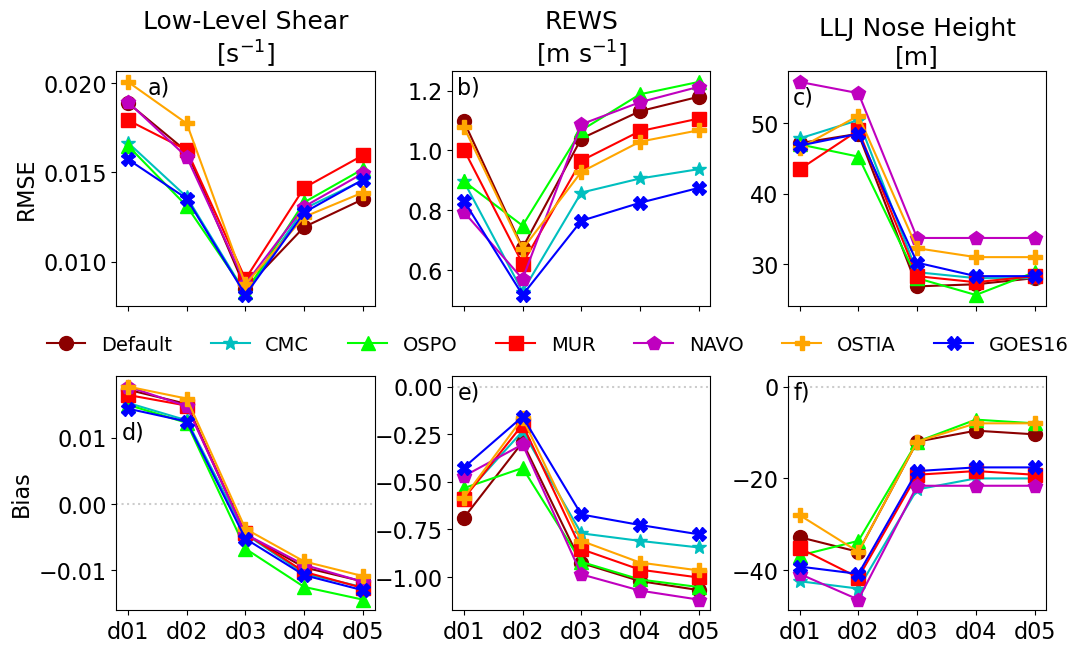

/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3927961615.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval = stats.pearsonr(obs.data,sim.data)
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3927961615.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval = stats.pearsonr(obs.data,sim.data)
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3927961615.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval = stats.pearsonr(obs.data,sim.data)
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3927961615.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval = stats.pearsonr(obs.data,sim.data)
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/3927961615.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is n

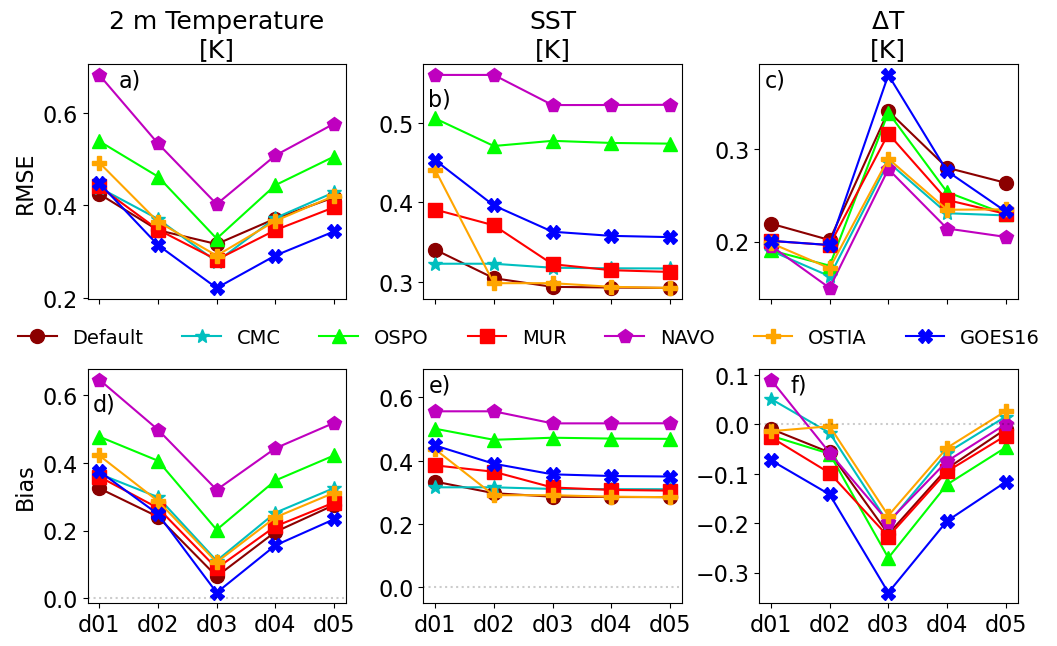

In [158]:
#variables = ['t2','sst','delT','low_shear','max_wspd','hub_wspd','llj_height']

variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['hub_wspd','low_shear','rews'],
                   ['low_shear','rews','llj_height'],
                   ['t2','tsk','delT',]]

#doms_of_interest = [1,2,3,4,5]

limit_dict = {}
bias_dict_full = {}
rmse_dict_full = {}
corr_dict_full = {}
pval_dict_full = {}
for vg,variables in enumerate(variable_groups):

    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(4*len(variables),7),sharex=True)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)

    lid = 'E06'

    var_min_dict = {}
    var_max_dict = {}
    for vv,varn in enumerate(variables):
        var_min_dict[varn] = 999
        var_max_dict[varn] = -999

    cases_of_interest_dom = cases.copy()
    bias_dict = {}
    rmse_dict = {}
    corr_dict = {}
    pval_dict = {}
    limit_dict[vg] = {}
    for vv,varn in enumerate(variables):
        bias_dict[varn] = {}
        rmse_dict[varn] = {}
        corr_dict[varn] = {}
        pval_dict[varn] = {}
        for cc,case in enumerate(cases_of_interest_dom):
            case_str = case.replace('_{}'.format(dom_str),'')
            bias_dict[varn][case] = []
            rmse_dict[varn][case] = []
            corr_dict[varn][case] = []
            pval_dict[varn][case] = []
            for dd,dom in enumerate(doms_of_interest):
                mean_ls = dom_dict[dom]['ls']
                ls = '-'

                dom_str = 'd0{}'.format(dom)

                sim = ens_dict[dom_str].sel(case='{}_{}'.format(case,dom_str))[varn]
                obs = ens_ds.sel(case='obs')[varn]

                sim = sim.where(~np.isnan(obs)).dropna(how='all',dim='datetime')
                obs = obs.dropna(how='all',dim='datetime')

                sim = sim.sel(datetime=slice(case_start,case_end))
                obs = obs.sel(datetime=slice(case_start,case_end))

                bias = float(obs.mean() - sim.mean())
                rmse = float(np.sqrt(((sim - obs)**2).mean()))
                corr,pval = stats.pearsonr(obs.data,sim.data)
                bias_dict[varn][case] += [bias]
                rmse_dict[varn][case] += [rmse]
                corr_dict[varn][case] += [corr]
                pval_dict[varn][case] += [pval]
                
            if vv == 0:
                plt_lbl = case_dict[case_str]['case_name']
                if 'DFLT' in case:
                    plt_lbl = 'Default'
                else:
                    plt_lbl = case_dict[case_str]['sst']
            else:
                plt_lbl = None
                
            ax[0,vv].plot(range(0,len(doms_of_interest)),
                          rmse_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          marker=marker_dict[case_str],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            ax[1,vv].plot(range(0,len(doms_of_interest)),
                          bias_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          marker=marker_dict[case_str],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            

        xlbl = []
        for dd,dom in enumerate(doms_of_interest):
            xlbl += ['d0{}'.format(dom)]
        ax[1,vv].set_xticks(np.arange(0,len(doms_of_interest)))
        ax[1,vv].set_xticklabels(xlbl)
        limit_dict[vg][vv] = {}
        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            txt_x = 0.02
            txt_y = 0.98
            if (varn == 'low_shear') and (axi == 0): txt_x = 0.12
            if (varn == 'low_shear') and (axi == 1): txt_y = 0.81
            if (varn == 'llj_height') and (axi == 0): txt_y = 0.94
            if (varn == 'tsk') and (axi == 0): txt_y = 0.90
            if (varn == 't2') and (axi == 0): txt_x = 0.12
            if (varn == 't2') and (axi == 1): txt_y = 0.90
            if (varn == 'delT') and (axi == 1): txt_x = 0.12
            if (varn == 'tsk') and (axi == 1): ax[axi,vv].set_ylim(-0.05,0.69)

            ax[axi,vv].text(txt_x,txt_y,'{})'.format(ascii_lowercase[vv + axi*3]),
                            ha='left',va='top',fontsize=16,
                            transform = ax[axi,vv].transAxes)
            left_limit, right_limit = ax[axi, vv].get_xlim()
            low_limit, up_limit = ax[axi, vv].get_ylim()
            limit_dict[vg][vv][axi] = {'x1':left_limit,'x2':right_limit,
                                       'y1':low_limit,'y2':up_limit}
            
            
        var_str = variable_dict[varn]['title']
        ax[0,vv].set_title('{}\n[{}]'.format(var_str,variable_dict[varn]['units']),size=18)
        

        ax[1,vv].axhline(0.0,c='k',alpha=0.2,ls=':')

    ax[0,0].set_ylabel('RMSE',size=16)
    ax[1,0].set_ylabel('Bias',size=16)
    ax[1,0].legend(frameon=False,ncol=7,fontsize=14,loc=(-0.3,1.06))
    left_limit, right_limit = ax[0, 0].get_xlim()
    low_limit, up_limit = ax[0, 0].get_ylim()
    fig_name = '{}ErrorBias_{}'.format(save_dir,'_'.join(variables))

    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()
    
    bias_dict_full[vg] = bias_dict
    rmse_dict_full[vg] = rmse_dict
    corr_dict_full[vg] = corr_dict
    pval_dict_full[vg] = pval_dict

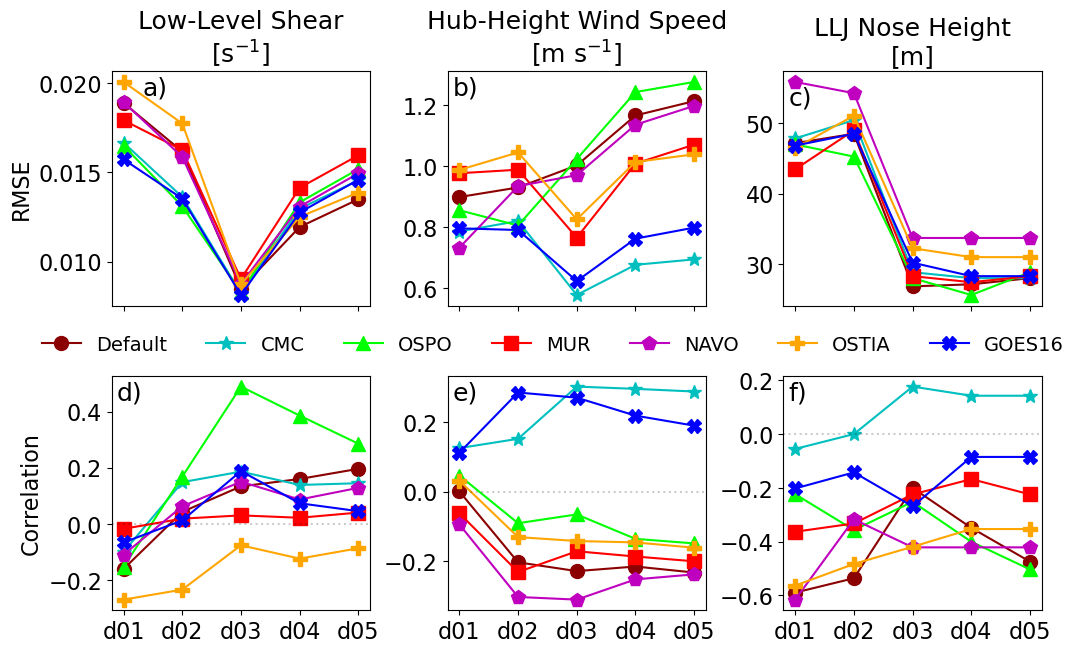

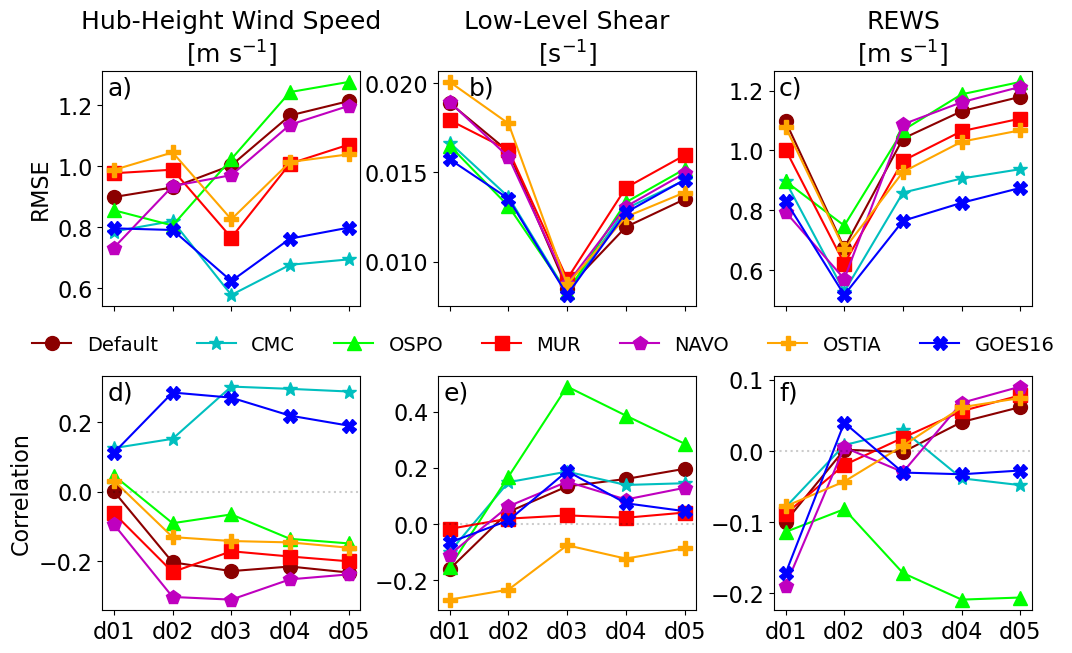

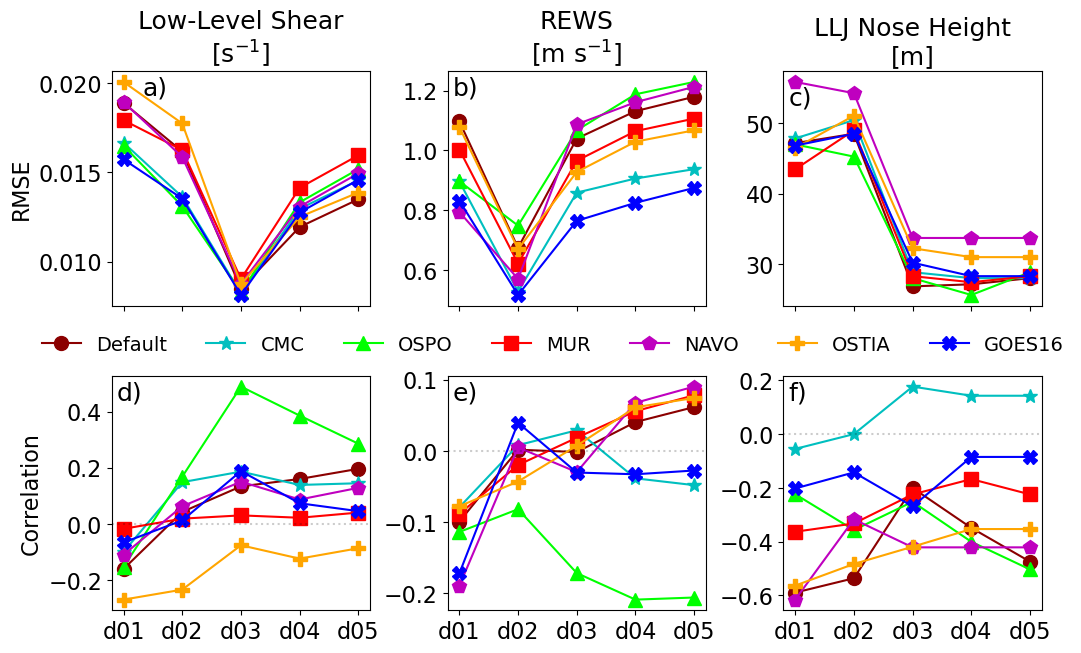

/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/2625693421.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval = stats.pearsonr(obs.data,sim.data)
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/2625693421.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval = stats.pearsonr(obs.data,sim.data)
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/2625693421.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval = stats.pearsonr(obs.data,sim.data)
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/2625693421.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,pval = stats.pearsonr(obs.data,sim.data)
/glade/derecho/scratch/hawbecker/tmp/ipykernel_6481/2625693421.py:56: ConstantInputWarning: An input array is constant; the correlation coefficient is n

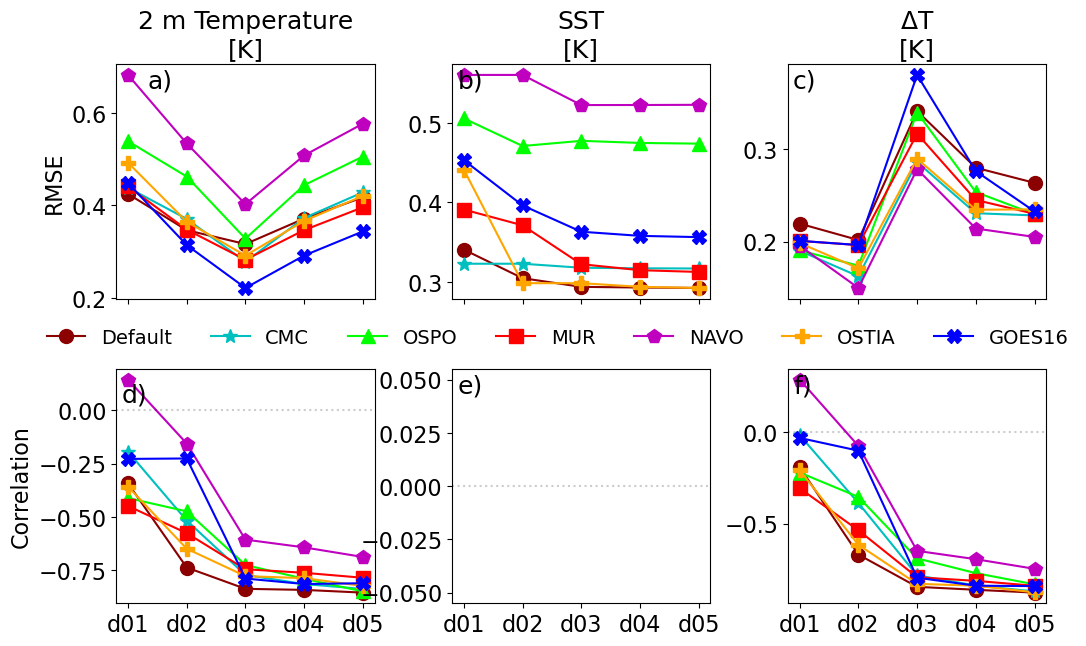

In [152]:
#variables = ['t2','sst','delT','low_shear','max_wspd','hub_wspd','llj_height']

variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['hub_wspd','low_shear','rews'],
                   ['low_shear','rews','llj_height'],
                   ['t2','tsk','delT',]]

#doms_of_interest = [1,2,3,4,5]


for vg,variables in enumerate(variable_groups):
    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(4*len(variables),7),sharex=True)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)

    lid = 'E06'


    cases_of_interest_dom = cases.copy()
    bias_dict = {}
    rmse_dict = {}
    corr_dict = {}
    pval_dict = {}

    for vv,varn in enumerate(variables):
        bias_dict[varn] = {}
        rmse_dict[varn] = {}
        corr_dict[varn] = {}
        pval_dict[varn] = {}
        for cc,case in enumerate(cases_of_interest_dom):
            bias_dict[varn][case] = []
            rmse_dict[varn][case] = []
            corr_dict[varn][case] = []
            pval_dict[varn][case] = []
            for dd,dom in enumerate(doms_of_interest):
                mean_ls = dom_dict[dom]['ls']
                ls = '-'

                dom_str = 'd0{}'.format(dom)
                case_str = case.replace('_{}'.format(dom_str),'')

                sim = ens_dict[dom_str].sel(case='{}_{}'.format(case,dom_str))[varn]
                obs = ens_ds.sel(case='obs')[varn]

                sim = sim.where(~np.isnan(obs)).dropna(how='all',dim='datetime')
                obs = obs.dropna(how='all',dim='datetime')

                sim = sim.sel(datetime=slice(case_start,case_end))
                obs = obs.sel(datetime=slice(case_start,case_end))

                bias = float(obs.mean() - sim.mean())
                rmse = float(np.sqrt(((sim - obs)**2).mean()))
                corr,pval = stats.pearsonr(obs.data,sim.data)
                bias_dict[varn][case] += [bias]
                rmse_dict[varn][case] += [rmse]
                corr_dict[varn][case] += [corr]
                pval_dict[varn][case] += [pval]
                
            if vv == 0:
                plt_lbl = case_dict[case_str]['case_name']
                if 'DFLT' in case:
                    plt_lbl = 'Default'
                else:
                    plt_lbl = case_dict[case_str]['sst']
            else:
                plt_lbl = None
                
            ax[0,vv].plot(range(0,len(doms_of_interest)),
                          rmse_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          marker=marker_dict[case_str],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            ax[1,vv].plot(range(0,len(doms_of_interest)),
                          corr_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          marker=marker_dict[case_str],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            

        xlbl = []
        for dd,dom in enumerate(doms_of_interest):
            xlbl += ['d0{}'.format(dom)]
        ax[1,vv].set_xticks(np.arange(0,len(doms_of_interest)))
        ax[1,vv].set_xticklabels(xlbl)

        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            txt_x = 0.02
            txt_y = 0.98
            if (varn == 'low_shear') and (axi == 0): txt_x = 0.12
            if (varn == 'llj_height') and (axi == 0): txt_y = 0.94
            if (varn == 't2') and (axi == 0): txt_x = 0.12
            if (varn == 't2') and (axi == 1): txt_y = 0.94
            ax[axi,vv].text(txt_x,txt_y,'{})'.format(ascii_lowercase[vv + axi*3]),
                            ha='left',va='top',fontsize=18,
                            transform = ax[axi,vv].transAxes)
            left_limit, right_limit = ax[axi, vv].get_xlim()
            low_limit, up_limit = ax[axi, vv].get_ylim()
            
            
        var_str = variable_dict[varn]['title']
        ax[0,vv].set_title('{}\n[{}]'.format(var_str,variable_dict[varn]['units']),size=18)
        

        ax[1,vv].axhline(0.0,c='k',alpha=0.2,ls=':')

    ax[0,0].set_ylabel('RMSE',size=16)
    ax[1,0].set_ylabel('Correlation',size=16)
    ax[1,0].legend(frameon=False,ncol=7,fontsize=14,loc=(-0.3,1.06))
    fig_name = '{}ErrorCorr_{}'.format(save_dir,'_'.join(variables))

    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()
    bias_dict_full[vg] = bias_dict
    rmse_dict_full[vg] = rmse_dict
    corr_dict_full[vg] = corr_dict
    pval_dict_full[vg] = pval_dict
    

In [118]:
def create_latex_table(headers, data, caption=None, label=None):
    latex_string = "\\begin{table}[h!]\n"
    if caption:
        latex_string += f"\\caption{{{caption}}}\n"
    if label:
        latex_string += f"\\label{{{label}}}\n"
    
    # Determine column alignment (e.g., 'l' for left, 'c' for center, 'r' for right)
    # Here, we'll use 'l' for all columns for simplicity
    column_alignment = "l" * len(headers)
    latex_string += f"\\begin{{tabular}}{{{column_alignment}}}\n"
    latex_string += "\\hline\n"
    
    # Add headers
    latex_string += " & ".join(headers) + " \\\\\n"
    latex_string += "\\hline\n"
    
    # Add data rows
    for row in data:
        latex_string += " & ".join(map(str, row)) + " \\\\\n"
    
    latex_string += "\\hline\n"
    latex_string += "\\end{tabular}\n"
    latex_string += "\\end{table}\n"
    return latex_string
    

In [119]:
print('CORRELATION')

for vg,variables in enumerate(variable_groups):
    data = []
    label_str = ''
    for varn in variables:
        var_str = variable_dict[varn]['title']

        label_str += '& \multicolumn{5}{c|}{'+var_str + '} '
    print(label_str)

    for cc,case in enumerate(cases_of_interest_dom):

        plt_lbl = case_dict[case]['case_name']
        if 'DFLT' in case:
            plt_lbl = 'Default'
        else:
            plt_lbl = case_dict[case]['sst']
        row = [plt_lbl]
        corr_dict = corr_dict_full[vg]
        for vv,varn in enumerate(variables):
            line = corr_dict[varn][case]
            line = ['{0:4.3f}'.format(l) for l in line]
            row += line

        if cc == 0:
            data = row
        else:
            data = np.vstack([data,row])

    headers = ['case'] + ['d01','d02','d03','d04','d05']*len(variables)
    latex_output = create_latex_table(headers, data, caption=varn, label="tab:stats")
    if vg == 1:
        print(latex_output)

CORRELATION
& \multicolumn{5}{c|}{Low-Level Shear} & \multicolumn{5}{c|}{Hub-Height Wind Speed} & \multicolumn{5}{c|}{LLJ Nose Height} 
& \multicolumn{5}{c|}{Hub-Height Wind Speed} & \multicolumn{5}{c|}{Low-Level Shear} & \multicolumn{5}{c|}{REWS} 
\begin{table}[h!]
\caption{rews}
\label{tab:stats}
\begin{tabular}{llllllllllllllll}
\hline
case & d01 & d02 & d03 & d04 & d05 & d01 & d02 & d03 & d04 & d05 & d01 & d02 & d03 & d04 & d05 \\
\hline
Default & 0.001 & -0.203 & -0.228 & -0.215 & -0.232 & -0.161 & 0.043 & 0.134 & 0.160 & 0.196 & -0.099 & 0.002 & -0.002 & 0.041 & 0.062 \\
CMC & 0.125 & 0.152 & 0.302 & 0.295 & 0.288 & -0.100 & 0.149 & 0.186 & 0.139 & 0.145 & -0.079 & 0.008 & 0.029 & -0.038 & -0.048 \\
OSPO & 0.047 & -0.090 & -0.065 & -0.135 & -0.148 & -0.154 & 0.168 & 0.490 & 0.386 & 0.286 & -0.114 & -0.082 & -0.172 & -0.209 & -0.206 \\
MUR & -0.062 & -0.231 & -0.171 & -0.186 & -0.200 & -0.018 & 0.019 & 0.030 & 0.022 & 0.040 & -0.088 & -0.020 & 0.019 & 0.056 & 0.078 \\
NAVO & -0.09

In [120]:
print('P-VAL of CORRELATION')

for vg,variables in enumerate(variable_groups):
    data = []
    label_str = ''
    for varn in variables:
        var_str = variable_dict[varn]['title']

        label_str += '& \multicolumn{5}{c|}{'+var_str + '} '
    print(label_str)

    for cc,case in enumerate(cases_of_interest_dom):

        plt_lbl = case_dict[case]['case_name']
        if 'DFLT' in case:
            plt_lbl = 'Default'
        else:
            plt_lbl = case_dict[case]['sst']
        row = [plt_lbl]
        pval_dict = pval_dict_full[vg]
        for vv,varn in enumerate(variables):
            line = pval_dict[varn][case]
            line = ['{0:4.3f}'.format(l) for l in line]
            row += line

        if cc == 0:
            data = row
        else:
            data = np.vstack([data,row])

    headers = ['case'] + ['d01','d02','d03','d04','d05']*len(variables)
    latex_output = create_latex_table(headers, data, caption=varn, label="tab:stats")
    if vg == 1:
        print(latex_output)

P-VAL of CORRELATION
& \multicolumn{5}{c|}{Low-Level Shear} & \multicolumn{5}{c|}{Hub-Height Wind Speed} & \multicolumn{5}{c|}{LLJ Nose Height} 
& \multicolumn{5}{c|}{Hub-Height Wind Speed} & \multicolumn{5}{c|}{Low-Level Shear} & \multicolumn{5}{c|}{REWS} 
\begin{table}[h!]
\caption{rews}
\label{tab:stats}
\begin{tabular}{llllllllllllllll}
\hline
case & d01 & d02 & d03 & d04 & d05 & d01 & d02 & d03 & d04 & d05 & d01 & d02 & d03 & d04 & d05 \\
\hline
Default & 0.997 & 0.331 & 0.273 & 0.302 & 0.264 & 0.443 & 0.840 & 0.524 & 0.445 & 0.347 & 0.637 & 0.993 & 0.994 & 0.847 & 0.770 \\
CMC & 0.551 & 0.468 & 0.142 & 0.152 & 0.163 & 0.635 & 0.478 & 0.373 & 0.508 & 0.489 & 0.707 & 0.969 & 0.890 & 0.855 & 0.820 \\
OSPO & 0.825 & 0.667 & 0.757 & 0.519 & 0.479 & 0.463 & 0.421 & 0.013 & 0.057 & 0.166 & 0.588 & 0.698 & 0.412 & 0.317 & 0.324 \\
MUR & 0.768 & 0.267 & 0.414 & 0.373 & 0.338 & 0.933 & 0.929 & 0.886 & 0.918 & 0.849 & 0.675 & 0.925 & 0.930 & 0.791 & 0.710 \\
NAVO & 0.655 & 0.142 & 0.132 & 0

In [121]:
print('BIAS')

for vg,variables in enumerate(variable_groups):
    data = []
    label_str = ''
    for varn in variables:
        var_str = variable_dict[varn]['title']

        label_str += '& \multicolumn{5}{c|}{'+var_str + '} '
    print(label_str)

    for cc,case in enumerate(cases_of_interest_dom):

        plt_lbl = case_dict[case]['case_name']
        if 'DFLT' in case:
            plt_lbl = 'Default'
        else:
            plt_lbl = case_dict[case]['sst']
        row = [plt_lbl]
        bias_dict = bias_dict_full[vg]
        for vv,varn in enumerate(variables):
            line = bias_dict[varn][case]
            line = ['{0:4.3f}'.format(l) for l in line]
            row += line

        if cc == 0:
            data = row
        else:
            data = np.vstack([data,row])

    headers = ['case'] + ['d01','d02','d03','d04','d05']*len(variables)
    latex_output = create_latex_table(headers, data, caption=varn, label="tab:stats")
    if vg == 1:
        print(latex_output)

BIAS
& \multicolumn{5}{c|}{Low-Level Shear} & \multicolumn{5}{c|}{Hub-Height Wind Speed} & \multicolumn{5}{c|}{LLJ Nose Height} 
& \multicolumn{5}{c|}{Hub-Height Wind Speed} & \multicolumn{5}{c|}{Low-Level Shear} & \multicolumn{5}{c|}{REWS} 
\begin{table}[h!]
\caption{rews}
\label{tab:stats}
\begin{tabular}{llllllllllllllll}
\hline
case & d01 & d02 & d03 & d04 & d05 & d01 & d02 & d03 & d04 & d05 & d01 & d02 & d03 & d04 & d05 \\
\hline
Default & 0.041 & 0.496 & -0.500 & -0.729 & -0.808 & 0.017 & 0.015 & -0.005 & -0.010 & -0.012 & -0.689 & -0.292 & -0.927 & -1.022 & -1.069 \\
CMC & 0.276 & 0.617 & -0.163 & -0.373 & -0.436 & 0.015 & 0.013 & -0.005 & -0.011 & -0.013 & -0.575 & -0.234 & -0.771 & -0.810 & -0.845 \\
OSPO & 0.247 & 0.316 & -0.614 & -0.907 & -0.963 & 0.015 & 0.012 & -0.007 & -0.013 & -0.014 & -0.533 & -0.428 & -0.921 & -1.013 & -1.053 \\
MUR & 0.175 & 0.641 & -0.247 & -0.537 & -0.637 & 0.016 & 0.015 & -0.004 & -0.010 & -0.013 & -0.588 & -0.200 & -0.854 & -0.961 & -1.003 \\
NAVO

In [122]:
print('ERROR')

for vg,variables in enumerate(variable_groups):
    data = []
    label_str = ''
    for varn in variables:
        var_str = variable_dict[varn]['title']

        label_str += '& \multicolumn{5}{c|}{'+var_str + '} '
    print(label_str)

    for cc,case in enumerate(cases_of_interest_dom):

        plt_lbl = case_dict[case]['case_name']
        if 'DFLT' in case:
            plt_lbl = 'Default'
        else:
            plt_lbl = case_dict[case]['sst']
        row = [plt_lbl]
        rmse_dict = rmse_dict_full[vg]
        for vv,varn in enumerate(variables):
            line = rmse_dict[varn][case]
            line = ['{0:4.3f}'.format(l) for l in line]
            row += line

        if cc == 0:
            data = row
        else:
            data = np.vstack([data,row])

    headers = ['case'] + ['d01','d02','d03','d04','d05']*len(variables)
    latex_output = create_latex_table(headers, data, caption=varn, label="tab:stats")

    if vg == 1:
        print(latex_output)

ERROR
& \multicolumn{5}{c|}{Low-Level Shear} & \multicolumn{5}{c|}{Hub-Height Wind Speed} & \multicolumn{5}{c|}{LLJ Nose Height} 
& \multicolumn{5}{c|}{Hub-Height Wind Speed} & \multicolumn{5}{c|}{Low-Level Shear} & \multicolumn{5}{c|}{REWS} 
\begin{table}[h!]
\caption{rews}
\label{tab:stats}
\begin{tabular}{llllllllllllllll}
\hline
case & d01 & d02 & d03 & d04 & d05 & d01 & d02 & d03 & d04 & d05 & d01 & d02 & d03 & d04 & d05 \\
\hline
Default & 0.899 & 0.931 & 1.003 & 1.167 & 1.214 & 0.019 & 0.016 & 0.008 & 0.012 & 0.013 & 1.097 & 0.674 & 1.040 & 1.132 & 1.180 \\
CMC & 0.786 & 0.821 & 0.579 & 0.677 & 0.695 & 0.017 & 0.014 & 0.008 & 0.013 & 0.015 & 0.896 & 0.527 & 0.859 & 0.906 & 0.937 \\
OSPO & 0.856 & 0.806 & 1.024 & 1.243 & 1.276 & 0.016 & 0.013 & 0.008 & 0.013 & 0.015 & 0.897 & 0.748 & 1.067 & 1.188 & 1.229 \\
MUR & 0.977 & 0.989 & 0.766 & 1.009 & 1.071 & 0.018 & 0.016 & 0.009 & 0.014 & 0.016 & 1.003 & 0.621 & 0.966 & 1.065 & 1.107 \\
NAVO & 0.733 & 0.935 & 0.971 & 1.136 & 1.198 & 

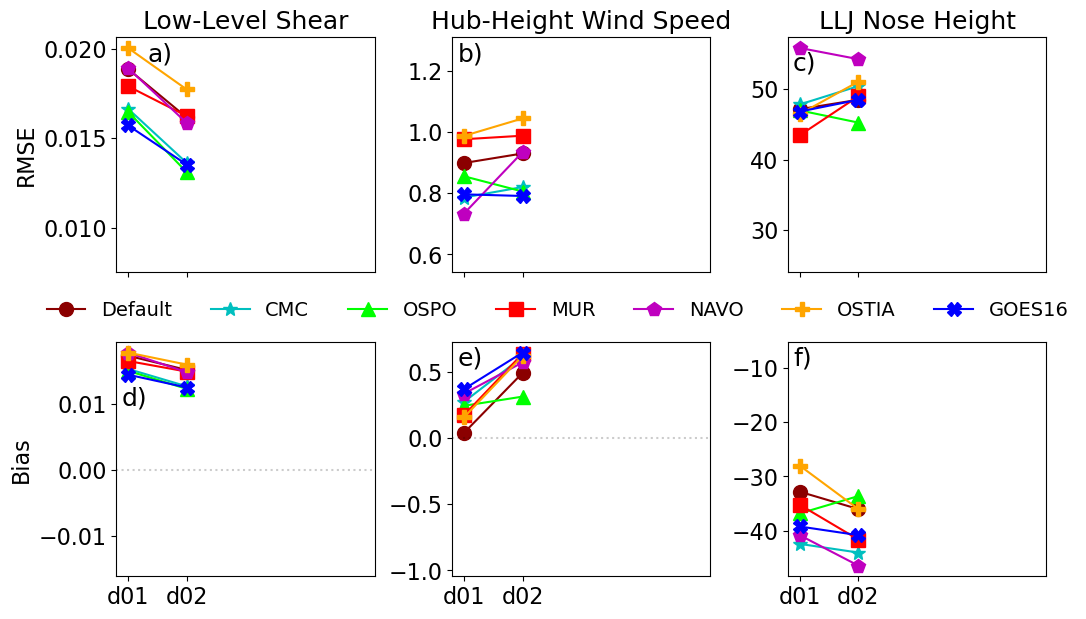

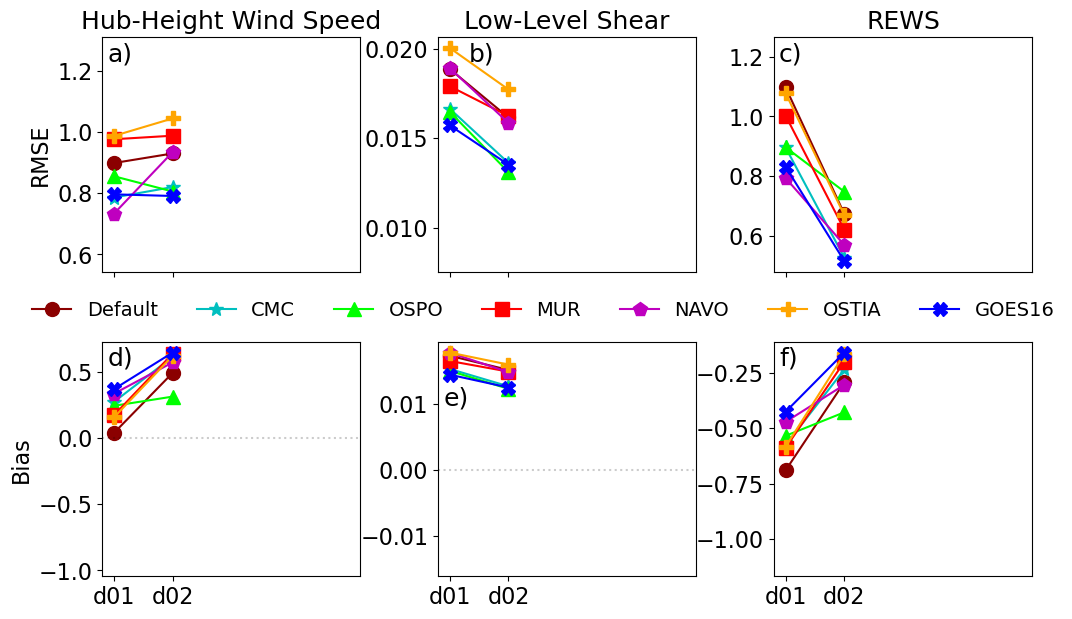

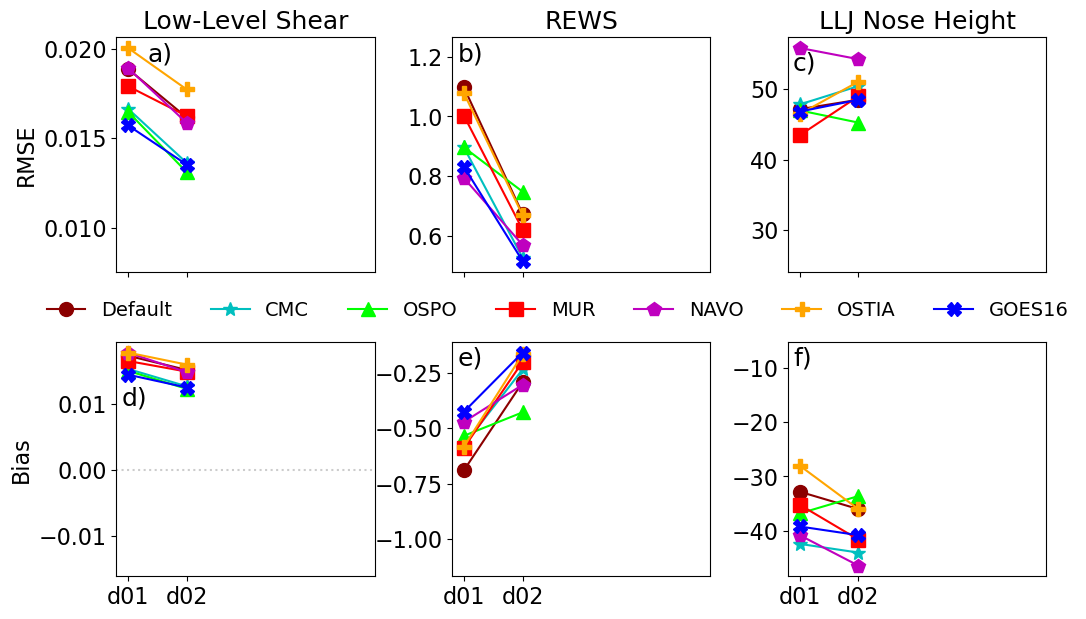

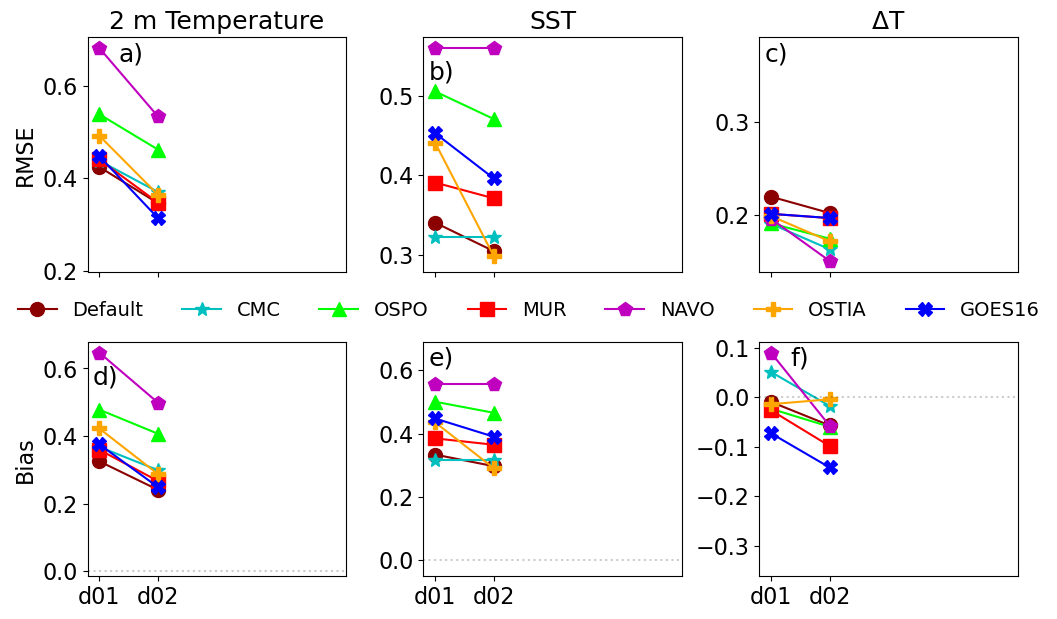

In [131]:
#variables = ['t2','sst','delT','low_shear','max_wspd','hub_wspd','llj_height']
variable_groups = [['low_shear','hub_wspd','llj_height'],
                   ['hub_wspd','low_shear','rews'],
                   ['low_shear','rews','llj_height'],
                   ['t2','tsk','delT',]]

doms_of_interest_sub = [1,2]

for vg,variables in enumerate(variable_groups):

    #plt_start = pd.to_datetime(case_start)
    plt_start = pd.to_datetime(case_start)
    plt_end = pd.to_datetime(case_end)

    fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(4*len(variables),7),sharex=True)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)

    lid = 'E06'

    var_min_dict = {}
    var_max_dict = {}
    for vv,varn in enumerate(variables):
        var_min_dict[varn] = 999
        var_max_dict[varn] = -999

    cases_of_interest_dom = cases.copy()
    bias_dict = {}
    rmse_dict = {}

    for vv,varn in enumerate(variables):
        bias_dict[varn] = {}
        rmse_dict[varn] = {}
        for cc,case in enumerate(cases_of_interest_dom):
            case_str = case.replace('_{}'.format(dom_str),'')
            bias_dict[varn][case] = []
            rmse_dict[varn][case] = []
            for dd,dom in enumerate(doms_of_interest_sub):
                mean_ls = dom_dict[dom]['ls']
                ls = '-'

                dom_str = 'd0{}'.format(dom)

                sim = ens_dict[dom_str].sel(case='{}_{}'.format(case,dom_str))[varn]
                obs = ens_ds.sel(case='obs')[varn]

                sim = sim.where(~np.isnan(obs)).dropna(how='all',dim='datetime')
                obs = obs.dropna(how='all',dim='datetime')

                sim = sim.sel(datetime=slice(case_start,case_end))
                obs = obs.sel(datetime=slice(case_start,case_end))

                bias = float(obs.mean() - sim.mean())
                rmse = float(np.sqrt(((sim - obs)**2).mean()))
                bias_dict[varn][case] += [bias]
                rmse_dict[varn][case] += [rmse]
                
            if vv == 0:
                plt_lbl = case_dict[case_str]['case_name']
                if 'DFLT' in case:
                    plt_lbl = 'Default'
                else:
                    plt_lbl = case_dict[case_str]['sst']
            else:
                plt_lbl = None
                
            ax[0,vv].plot(range(0,len(doms_of_interest_sub)),
                          rmse_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          marker=marker_dict[case_str],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            ax[1,vv].plot(range(0,len(doms_of_interest_sub)),
                          bias_dict[varn][case],
                          c=case_dict[case_str]['color'],
                          marker=marker_dict[case_str],
                          markersize=10,
                          ls='-',
                          label=plt_lbl)
            

        xlbl = []
        for dd,dom in enumerate(doms_of_interest_sub):
            xlbl += ['d0{}'.format(dom)]
        ax[1,vv].set_xticks(np.arange(0,len(doms_of_interest_sub)))
        ax[1,vv].set_xticklabels(xlbl)
        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            txt_x = 0.02
            txt_y = 0.98
            if (varn == 'low_shear') and (axi == 0): txt_x = 0.12
            if (varn == 'low_shear') and (axi == 1): txt_y = 0.81
            if (varn == 'llj_height') and (axi == 0): txt_y = 0.94
            if (varn == 'tsk') and (axi == 0): txt_y = 0.90
            if (varn == 't2') and (axi == 0): txt_x = 0.12
            if (varn == 't2') and (axi == 1): txt_y = 0.90
            if (varn == 'delT') and (axi == 1): txt_x = 0.12
            if (varn == 'tsk') and (axi == 1): ax[axi,vv].set_ylim(-0.05,0.69)
            ax[axi,vv].text(txt_x,txt_y,'{})'.format(ascii_lowercase[vv + axi*3]),
                            ha='left',va='top',fontsize=18,
                            transform = ax[axi,vv].transAxes)
            
            left_limit = limit_dict[vg][vv][axi]['x1']
            right_limit = limit_dict[vg][vv][axi]['x2']
            low_limit = limit_dict[vg][vv][axi]['y1']
            up_limit = limit_dict[vg][vv][axi]['y2']

            ax[axi,vv].set_xlim(left_limit,right_limit)
            ax[axi,vv].set_ylim(low_limit,up_limit)

        var_str = variable_dict[varn]['title']
        ax[0,vv].set_title(var_str,size=18)

        ax[1,vv].axhline(0.0,c='k',alpha=0.2,ls=':')
    ax[0,0].set_ylabel('RMSE',size=16)
    ax[1,0].set_ylabel('Bias',size=16)
    ax[1,0].legend(frameon=False,ncol=7,fontsize=14,loc=(-0.3,1.06))

    fig_name = '{}ErrorBias_{}_mesoOnly'.format(save_dir,'_'.join(variables))

    if save_figs: 
        for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type,bbox_inches='tight')
    plt.show()

# Vertical profiles of Wind Speed for OSPO, CMC, obs

2020-04-06 02:00:00
2020-04-06 03:00:00
2020-04-06 04:00:00
2020-04-06 05:00:00
2020-04-06 06:00:00


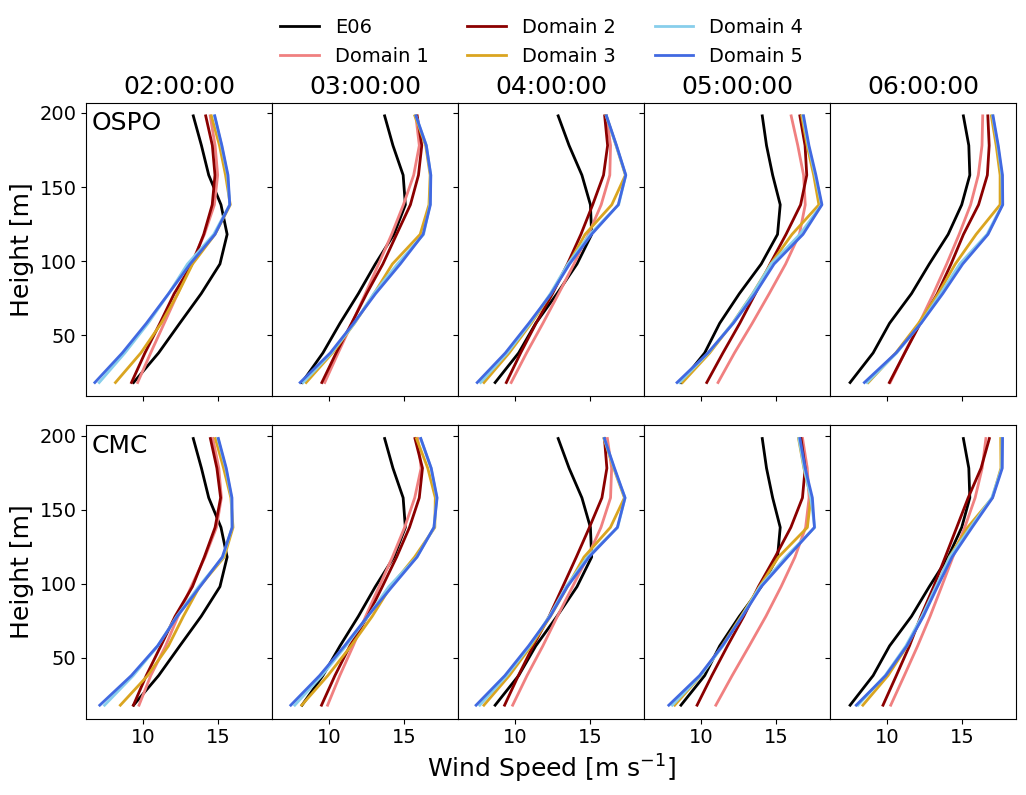

In [36]:
cases_for_this_plot = ['obs','MERRA2_OSPO_NOSK_CHRN_MDIS','MERRA2_CMCS_NOSK_CHRN_MDIS']
ptimes = pd.date_range(plt_start,plt_end,periods=5)

domains_to_plot = [1,2,3,4,5]

fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(12,8),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)

for pp,ptime in enumerate(ptimes):
    for cc,case in enumerate(cases_for_this_plot):
        if case != 'obs':
            for dom in domains_to_plot:
                c = dom_dict[dom]['color']
                dom_str = 'd0{}'.format(dom)
                case_str = '{}_{}'.format(case,dom_str)
                ds = lidar_ds_full.sel(case=case_str).sel(datetime=ptime)
                ds.wspd.plot(y='level',c=c,ax=ax[cc-1,pp],lw=2.0,label='Domain {}'.format(dom))
        else:
            ds = lidar_ds_full.sel(case=case).sel(datetime=ptime)
            for axi in range(2):
                ds.wspd.plot(y='level',c='k',ax=ax[axi,pp],lw=2.0, label='E06')

    if pp != 0:
        for axi in range(2):
            ax[axi,pp].set_ylabel('')
    else:
        for cc,case in enumerate(cases_for_this_plot[1:]):
            plt_label = case_dict[case]['sst']
            ax[cc,pp].text(0.03,0.97,plt_label, transform=ax[cc,pp].transAxes,ha='left',va='top',size=18)
    ax[0,pp].set_xlabel('')
    ax[1,pp].set_xlabel('')
    print(ptime)
    ax[0,pp].set_title(str(ptime).split(' ')[1],size=18)
    ax[1,pp].set_title('')

    for axi in range(2):
        ax[axi,pp].tick_params(labelsize=14)
ax[1,2].set_xlabel('Wind Speed [m s$^{-1}$]',size=18)
for axi in range(2):
    ax[axi,0].set_ylabel('Height [m]',size=18)

ax[0,1].legend(frameon=False,loc=(0.0,1.1),ncol=3,fontsize=14)
plt.show()


# Vertical profiles of temperature:

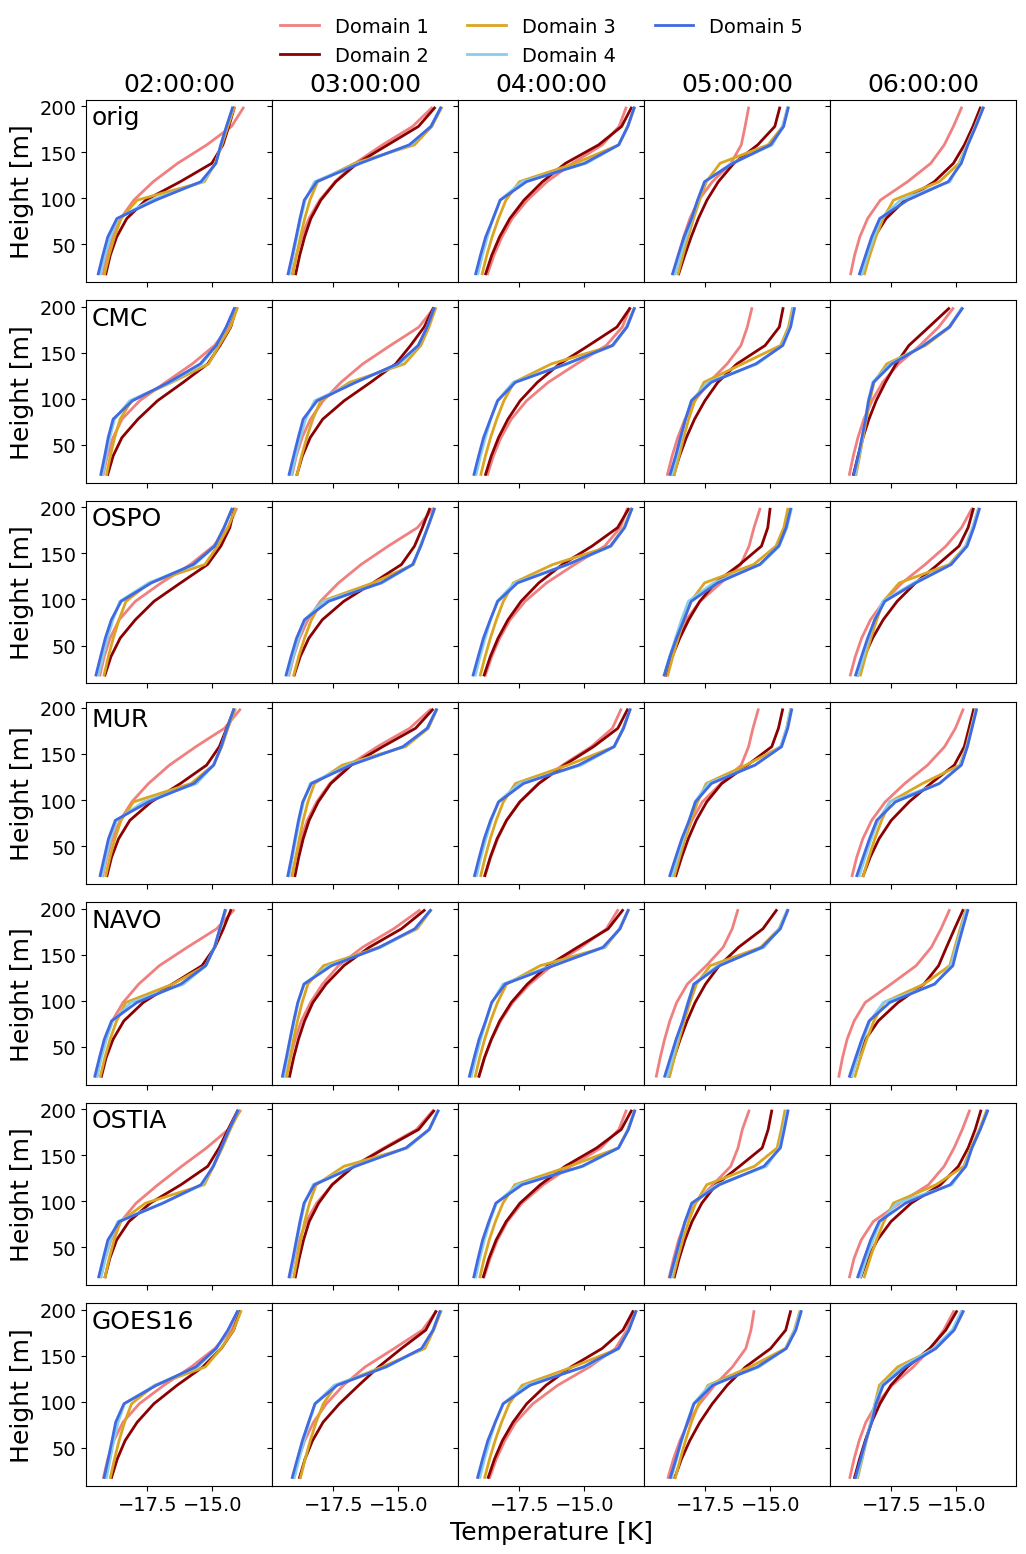

In [37]:
cases_for_this_plot = cases_of_interest_dom
ptimes = pd.date_range(plt_start,plt_end,periods=5)

domains_to_plot = [1,2,3,4,5]

fig,ax = plt.subplots(ncols=5,nrows=len(cases_for_this_plot),figsize=(12,18),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)

for pp,ptime in enumerate(ptimes):
    for cc,case in enumerate(cases_for_this_plot):
        for dom in domains_to_plot:
            c = dom_dict[dom]['color']
            dom_str = 'd0{}'.format(dom)
            case_str = '{}_{}'.format(case,dom_str)
            ds = wrf_ds_full.sel(case=case_str).sel(datetime=ptime)
            ds.T.plot(y='level',c=c,ax=ax[cc,pp],lw=2.0,label='Domain {}'.format(dom))


    if pp != 0:
        for axi in range(len(cases_for_this_plot)):
            ax[axi,pp].set_ylabel('')
    else:
        for cc,case in enumerate(cases_for_this_plot):
            plt_label = case_dict[case]['sst']
            ax[cc,pp].text(0.03,0.97,plt_label, transform=ax[cc,pp].transAxes,ha='left',va='top',size=18)
    for axi in range(len(cases_for_this_plot)):
        ax[axi,pp].set_xlabel('')
        ax[axi,pp].set_title('')

    ax[0,pp].set_title(str(ptime).split(' ')[1],size=18)

    for axi in range(len(cases_for_this_plot)):
        ax[axi,pp].tick_params(labelsize=14)
ax[len(cases_for_this_plot)-1,2].set_xlabel('Temperature [K]',size=18)
for axi in range(len(cases_for_this_plot)):
    ax[axi,0].set_ylabel('Height [m]',size=18)

ax[0,1].legend(frameon=False,loc=(0.0,1.15),ncol=3,fontsize=14)
plt.show()


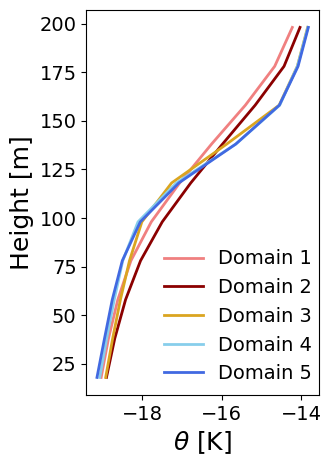

In [38]:
cases_for_this_plot = cases_of_interest_dom
ptimes = pd.date_range(plt_start,plt_end,periods=5)

domains_to_plot = [1,2,3,4,5]

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(3,5),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)

#for pp,ptime in enumerate(ptimes):
#for cc,case in enumerate(cases_for_this_plot):
for dom in domains_to_plot:
    c = dom_dict[dom]['color']
    dom_str = 'd0{}'.format(dom)
    case_str = '{}_{}'.format(case,dom_str)
    cases_to_avg = []
    for case in wrf_ds_full.case:
        case = str(case.data)
        if dom_str in case:
            cases_to_avg += [case]
    ds = wrf_ds_full.sel(case=cases_to_avg).mean(dim='case').mean(dim='datetime')

    ds.T.plot(y='level',c=c,ax=ax,lw=2.0,label='Domain {}'.format(dom))


#ax.set_title('Average Temperature',size=18)


ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\theta$ [K]',size=18)

ax.set_ylabel('Height [m]',size=18)

ax.legend(frameon=False,loc=(0.30,.01),ncol=1,fontsize=14)
plt.show()

# Compare 2m temp and lowest model level temperature:

In [ ]:
# There are no data for temperature in the obs... already checked!


# 